In [1]:
import sys
sys.path.append('/hildafs/projects/phy200040p/sukhdeep/project/Public-code/Hankel_transform/')

from scipy.special import factorial
from scipy.interpolate import interp2d,interp1d
from projected_corr_rsd import *
from astropy.cosmology import Planck18 #use Planck15 if you can
from power_spectra import *

In [2]:
from jk_utils import *

In [3]:
import seaborn as sns
colors2=sns.color_palette("colorblind")

In [4]:
fig_home='/hildafs/projects/phy200040p/sukhdeep/project/IA_multipole_lowz/data/figures/'
fig_format='pdf'

In [5]:
cosmo=Planck18.clone()#we want h=1 for some comparisons
cosmo_h=Planck18.clone(H0=100)#we want h=1 for some comparisons

In [6]:
kmax=30
kmin=1.e-4
k_smooth=1
nk=8000
rmin=.1
rmax=120
non_linear=1

r_bins=np.logspace(np.log10(rmin),np.log10(rmax),41) #np.logspace(0,2,11)

In [7]:
cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'As':2.12e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,'w':-1,'wa':0})
pk_params={'non_linear':non_linear,'kmax':kmax,'kmin':kmin,'nk':nk}

In [8]:
def taper(k=[],pk=[],large_k_lower=10,large_k_upper=30,low_k_lower=1.e-4,low_k_upper=1.e-3):
    pk_out=np.copy(pk)
    x=k>large_k_lower
    pk_out[x]*=np.cos((k[x]-large_k_lower)/(large_k_upper-large_k_lower)*np.pi/2.)
    x=k>large_k_upper
    pk_out[x]=0
    x=k<low_k_upper
    pk_out[x]*=np.cos((k[x]-low_k_upper)/(low_k_upper-low_k_lower)*np.pi/2.)
    x=k<low_k_lower
    pk_out[x]=0
    return pk_out

def DZ_int(z=[0],cosmo=None,rtol=1.e-4,tol=1.e-5): #linear growth factor.. full integral.. eq 63 in Lahav and suto
        Ez_func=cosmo.efunc
        def intf(z):
            return (1.+z)/(cosmo.H(z=z).value**3)
        dz=np.zeros_like(z,dtype='float32')
        inf=np.inf
        j=0
        for i in z:
            dz[j]+=cosmo.H(i).value*scipy_int1d(intf,i,inf,epsrel=rtol,epsabs=tol)[0]
            j=j+1
        dz=dz*2.5*cosmo.Om0*cosmo.H0**2
        return dz/dz[0] #check for normalization

In [9]:
PS=Power_Spectra(cosmo_params=cosmo_fid,pk_params=pk_params)

In [10]:
z_mean=0.26
pk,kh =PS.camb_pk(z=[z_mean])
pk=taper(k=kh,pk=pk[0])

In [11]:
b_g=1.8
A_I=4.5
C1_rhoC=0.0134
Om=cosmo.Om0
Dz=DZ_int(z=np.append([0],z_mean),cosmo=cosmo)# Dz is normalized to 1 at lowest z. 
                                    #Hence appending 0 in front to get Dz normalized to 1 at z=0
Dz=Dz[1]/Dz[0]

#prefactors in front of wmm or wm+.
#if doing fits, set b_g and AI to be 1 here and then in the fitting function 
# you can simply multiply the correlation function with the correct values.
wgg_f=b_g**2
wgp_f=b_g*A_I*C1_rhoC*Om/Dz
wgp_f0=C1_rhoC*Om/Dz
wgp_f0=wgp_f0.value
wpp_f=(A_I*C1_rhoC*Om/Dz)**2

In [12]:
def jk_read(dataset='',var=None,njk=100,auto_cross='_cross',bins='_bins',
            home='',corr='_final',skiprows=0,**kwargs):
    data_jk={}
    filename=dataset
    try:
        data_jk['data']=np.genfromtxt(home+filename+bins+auto_cross+'_jk_final.dat',
                                      names=True,skip_header=skiprows)
    except:
        print ('file not found',home+filename+bins+auto_cross+'_jk_final.dat')
    try:
        data_jk['data0']=np.genfromtxt(home+filename+bins+auto_cross+corr+'.dat',
                                       names=True,skip_header=skiprows)
    except:
        print ('file not found',home+filename+bins+auto_cross+corr+'.dat')
    for i in np.arange(njk):
        data_jk[i]=np.genfromtxt(home+filename+bins+auto_cross+'_jk'+str(i)+corr+'.dat',names=True,
                                 skip_header=skiprows)
    cc=cov_corr()
    if var and njk>0:
        data_jk['cov']={}
        data_jk['corr']={}
        for v in var:
            cov,corr=cc.dict_cov(dic=data_jk,var=v,stack=1,ignore_keys=['data','data0','cov','corr'])
            cov*=njk-1.
            data_jk['cov'][v]=cov
            data_jk['corr'][v]=corr
    return data_jk


In [13]:
file_home='/hildafs/projects/phy200040p/sukhdeep/project/IA_multipole_lowz/data_out/ia/coor_data_out/'
file_name='full_full_wt0'

In [14]:
njk=100

In [15]:
w_jk=jk_read(dataset=file_name,var=['wgg','wgp'],njk=njk,auto_cross='_cross',bins='_bins',
            home=file_home,corr='_final',skiprows=0)

In [16]:
file_home='/hildafs/projects/phy200040p/sukhdeep/project/IA_multipole_lowz/data_out/ia/coor_data_out/'
file_name='full_full_wt0'
xi_jk=jk_read(dataset=file_name,var=['wgg','wgp'],njk=njk,auto_cross='_cross',bins='_bins2D',
            home=file_home,corr='_final',skiprows=0)

//hildafs/projects///phy200040p/sukhdeep/project/code/python_scripts/cov_corr.py:93: RuntimeWarning: invalid value encountered in true_divide
  return cov_mat/np.sqrt(np.outer(diag,diag))


In [17]:
file_home='/hildafs/projects/phy200040p/sukhdeep/project/IA_multipole_lowz/data_out/ia/coor_data_out/'
file_name='full_full_wt0_lin'
xi_jk_lin=jk_read(dataset=file_name,var=['wgg','wgp'],njk=njk,auto_cross='_cross',bins='_bins2D',
            home=file_home,corr='_final',skiprows=0)

In [18]:
file_home='/hildafs/projects/phy200040p/sukhdeep/project/IA_multipole_lowz/data_out/ia_proj/coor_data_out/'
file_name='full_full_wt0'
xi_jk_proj=jk_read(dataset=file_name,var=['wgg','wgp'],njk=njk,auto_cross='_cross',bins='_bins2D',
            home=file_home,corr='_final',skiprows=0)

In [19]:
def jk_mean(p={},njk=100):
    if check_empty(p):
        print ('jk-mean: got empty dict')
        return p
    p2={}
    nn=np.arange(njk)
    for i in nn: #p.keys():
        #if i in nn:
        p2[i]=p[i]
    jk_vals=np.array(list(p2.values()))
    mean=np.mean(jk_vals,axis=0)
    #print mean
    var=np.var(jk_vals,axis=0,ddof=0)*(njk-1)
    p['jk']=mean
    p['jk_err']=np.sqrt(var)
    p['cov']=np.cov(jk_vals,rowvar=0)*(njk-1)
    return p

In [20]:
def calc_multipole(xi_jk,njk=100,var='wgp',L=[2,4],rp_cut=0):
    nrp=len(np.unique(xi_jk['data']['rp']))
    npi=len(np.unique(xi_jk['data']['pi']))
    
    rp= xi_jk['data']['rp']*np.sqrt(1-xi_jk['data']['pi']**2)
    mu=np.unique(xi_jk['data']['pi'])
    x=rp>rp_cut
    
    aL={}
    norm={}
    multipo_jk={}
    spin=2
    if var=='wgg':
        spin=0
        L=[0,2,4]
    for i in L:
        if spin!=0:
            aL[i]=associated_legendre(i,spin,mu)
        else:
            aL[i]=legendre(i,mu)
        norm[i]=(2*i+1)/2*factorial(i-spin)/factorial(i+spin)
        print(norm[i])
        multipo_jk[i]={}
    for i in range(njk):
        xi_t=xi_jk[i][var]*x
        w=xi_t.reshape(nrp,npi)
        for i_l in L:
            multipo_jk[i_l][i]=w@(aL[i_l]*np.gradient(mu))
            multipo_jk[i_l][i]*=norm[i_l]
    for i in L:
        multipo_jk[i]=jk_mean(multipo_jk[i])
    multipo_jk['r']=np.unique(xi_jk['data']['rp'])
    return multipo_jk

In [21]:
m_jk2_gg=calc_multipole(xi_jk,rp_cut=2,var='wgg')
m_jk5_gg=calc_multipole(xi_jk,rp_cut=5,var='wgg')

0.5
2.5
4.5
0.5
2.5
4.5


In [22]:
m_jk=calc_multipole(xi_jk)
m_jk2=calc_multipole(xi_jk,rp_cut=2)
m_jk5=calc_multipole(xi_jk,rp_cut=5)
m_jk5_lin=calc_multipole(xi_jk_lin,rp_cut=5)

m_jk5_lin_gg=calc_multipole(xi_jk_lin,rp_cut=5,var='wgg')

0.10416666666666667
0.0125
0.10416666666666667
0.0125
0.10416666666666667
0.0125
0.10416666666666667
0.0125
0.5
2.5
4.5


[]

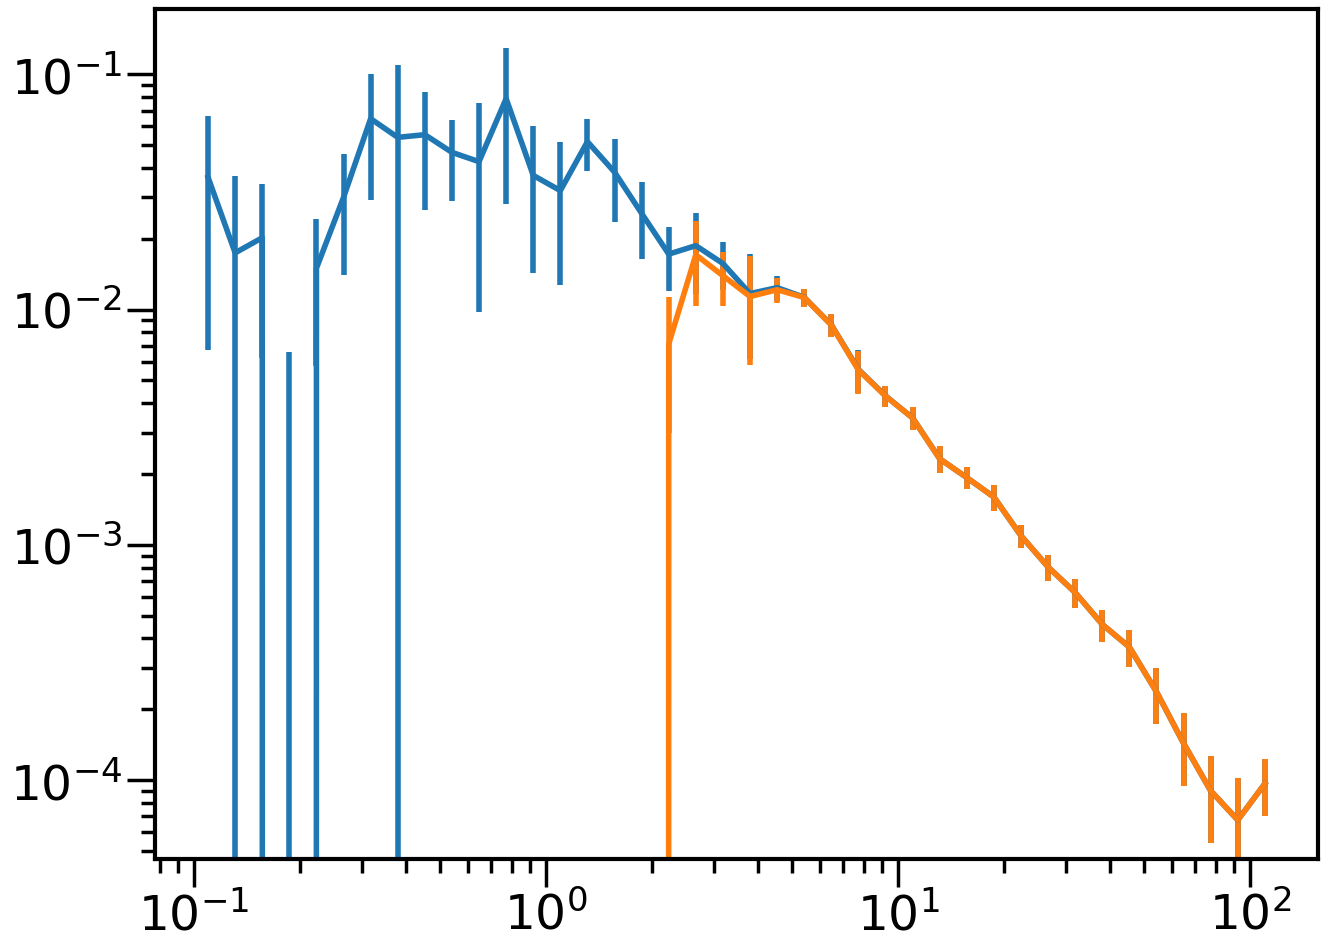

In [23]:
errorbar(m_jk['r'],m_jk[2]['jk'],m_jk[2]['jk_err'])
errorbar(m_jk['r'],m_jk2[2]['jk'],m_jk2[2]['jk_err'])
loglog()

In [24]:
rp= xi_jk['data']['rp']*np.sqrt(1-xi_jk['data']['pi']**2)
pi= xi_jk['data']['rp']*xi_jk['data']['pi']

rp_G=np.logspace(-1,2,20)
pi_G=np.linspace(-100,100,50)

In [25]:
rp_G2,pi_G2=meshgrid(rp_G,pi_G)

In [26]:
xi_intp=interp2d(rp,pi,xi_jk['data']['wgp'],kind='linear',bounds_error=False,fill_value=0)
xi2=xi_intp(rp_G,pi_G)#.reshape(50,20)

//hildafs/projects/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,5 m=4000 fp=1668.395560 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [27]:
colors=['r','b','g','m','c']

In [28]:
def get_2Dplot_dat(dat=[],var='wgp',pi_cut=0,SN=0,pi='pi',rp='rp',tol=1.e-4,rmu=0,**kwargs):
    pi_v=pi
    rp_v=rp
    pi=np.unique(dat[pi_v])
    if pi_cut!=0:
        #pi=pi[pi>0]
        x=dat[pi_v]<0
        for i in dat[x]:
            x1=np.absolute(dat[pi_v])==np.absolute(i[pi_v])
            x2=dat[rp_v]==i[rp_v]
            dat[var][x1*x2*x]=dat[var][x1*x2*(x==False)]
            if SN!=0:
                dat[var_err[var]][x1*x2*x]=dat[var_err[var]][x1*x2*(x==False)]
    rp=np.unique(dat[rp_v])
    rp=np.append(-rp[::-1],rp)
    rpp,ppi=meshgrid(rp,pi)
    d=np.zeros((len(pi),len(rp)))
    for i in np.arange(len(rp)):
        for j in np.arange(len(pi)):
            x1=np.absolute(dat[rp_v]-np.absolute(rp[i]))<tol
            x2=np.absolute(dat[pi_v]-pi[j])<tol
            x=x1*x2
            if sum(x)!=1:
                print(sum(x),rp[i],pi[j]
                     )
                raise Exception('Not found')
            if SN==0:
                d[j][i]=dat[var][x]
            else:
                d[j][i]=(dat[var]/dat[var_err[var]])[x]
    if SN==2:
        d=np.absolute(d)
    if rmu!=0:
        ppi*=100
    return rpp,ppi,d #for imshow() use np.flipud(d)


In [29]:
rpp,ppi,d=get_2Dplot_dat(xi_jk_proj['data'])
rpp_gg,ppi_gg,d_gg=get_2Dplot_dat(xi_jk_proj['data'],var='wgg')

In [30]:
ll=np.logspace(-3,0,6)

In [31]:
ll

array([0.001     , 0.00398107, 0.01584893, 0.06309573, 0.25118864,
       1.        ])

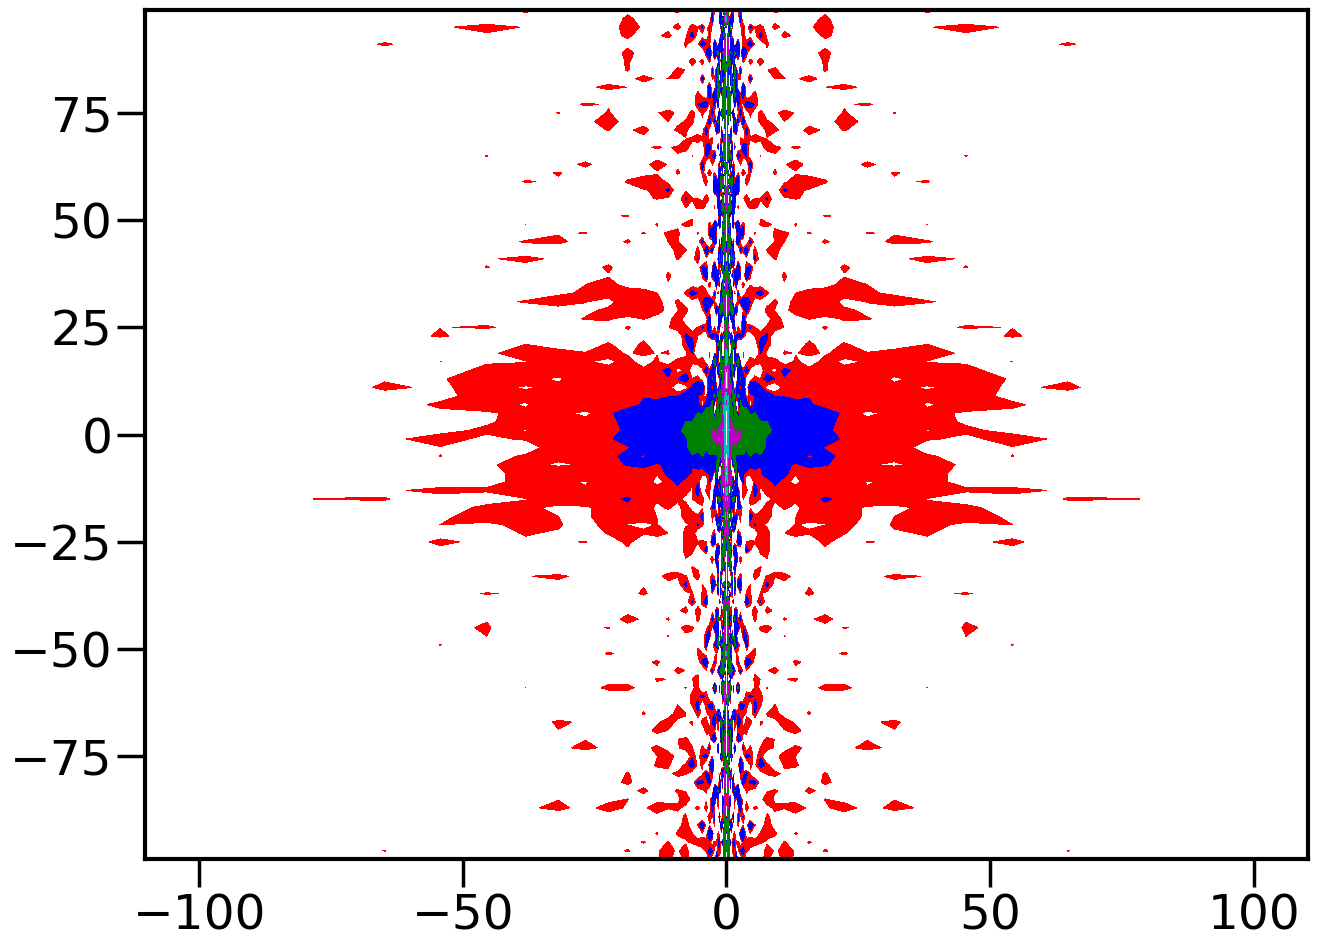

In [32]:
contourf(rpp,ppi,d,levels=ll,colors=colors)

In [33]:
pcr=Projected_Corr_RSD(rp=r_bins,pi_max=100,l=[0,2,4,6],k=kh,spins=[0,2])

/hildafs/projects/phy200040p/sukhdeep/project/Public-code/Hankel_transform/wigner_functions.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  d_mat/=np.sqrt(binom(k+b,b))
//hildafs/projects/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.9/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


In [34]:
def multipole_model(spin=2):
    if spin==0:
        l=[0,2,4]
    else:
        l=[2,4]
    rq,xiq=pcr.get_xi_multipole(pk=pk, l=l)
    beta1=0.66/b_g
    beta2=0.66/b_g
    if spin==2:
        beta1=-1
    for i in l:
        a=pcr.alpha(i,beta1,beta2,spin=spin)
        xiq[i]*=a
    return rq,xiq

In [35]:
def multipole_wedge_model(rp_cut=0,spin=2):
    rq,xiq=multipole_model(spin=spin)
    mu = np.linspace(-1, 1, 500)
    dmu = np.gradient(mu)
    s=spin
    xi_wq={}
    for i in xiq.keys():
        rG, muG = np.meshgrid(rq[i], mu)    

        rpG = np.sqrt(1-muG**2) * rG
        x=rpG>=rp_cut
        if spin==2:
            al=associated_legendre(i,2,muG)
        else:
            al=legendre(i,muG)
        xi_i_interp = np.interp(rG, rq[i], xiq[i], left=0, right=0)

        norm=(2*i+1)/2*factorial(i-s)/factorial(i+s)

        xi = xi_i_interp * al
        cut_xi = xi*x

        xi_wq[i] = norm * (dmu @ (cut_xi * al))
    
    return rq,xi_wq

In [36]:
rq,xiq_gg=multipole_model(spin=0)
rq,xi_wq_gg=multipole_wedge_model(rp_cut=2,spin=0)
rq,xi_wq5_gg=multipole_wedge_model(rp_cut=5,spin=0)


//hildafs/projects/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.9/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [37]:
rq,xiq=multipole_model()
rq,xi_wq=multipole_wedge_model(rp_cut=2)
rq,xi_wq5=multipole_wedge_model(rp_cut=5)
# rq,xiq=pcr.get_xi_multipole(pk=pk, l=[2,4])
# a2=pcr.alpha(2,-1,0.66/b_g,spin=2)
# a4=pcr.alpha(4,-1,0.66/b_g,spin=2)

Text(0, 0.5, '$\\xi_{g+,2}$')

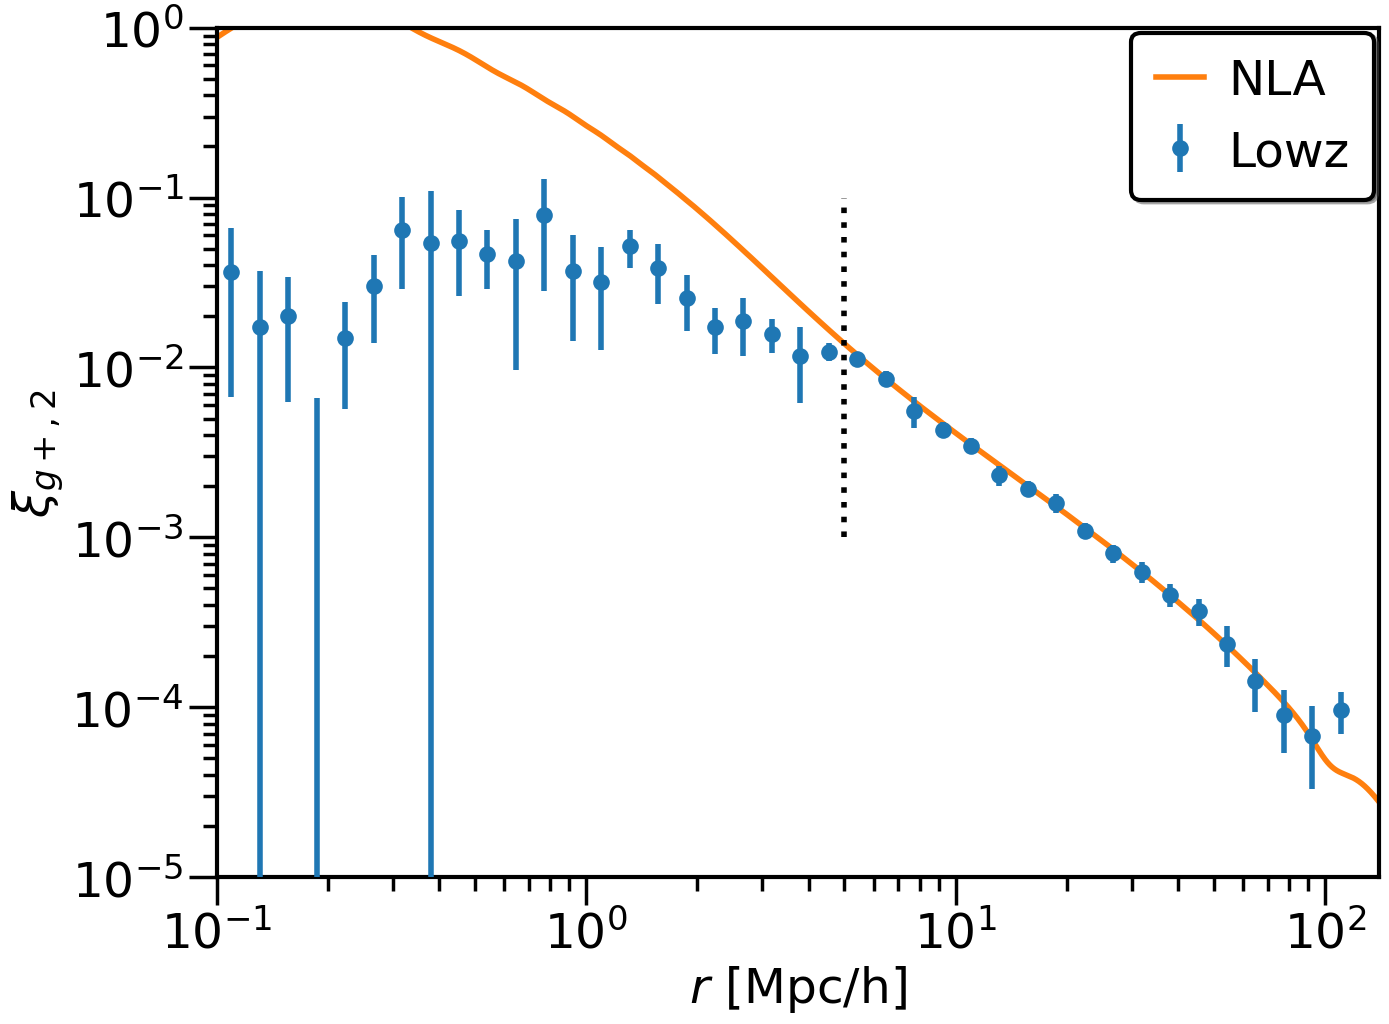

In [38]:
errorbar(m_jk['r'],m_jk[2]['jk'],m_jk[2]['jk_err'],label='Lowz',fmt='o',zorder=10)
plot(rq[2],xiq[2]*wgp_f*-1,label='NLA')
legend()
loglog()
xlim(.1,140)
ylim(.00001,1)
vlines(5,0.001,0.1,color='k',ls=':')
xlabel(r'$r$ [Mpc/h]')
ylabel(r'$\xi_{g+,2}$')

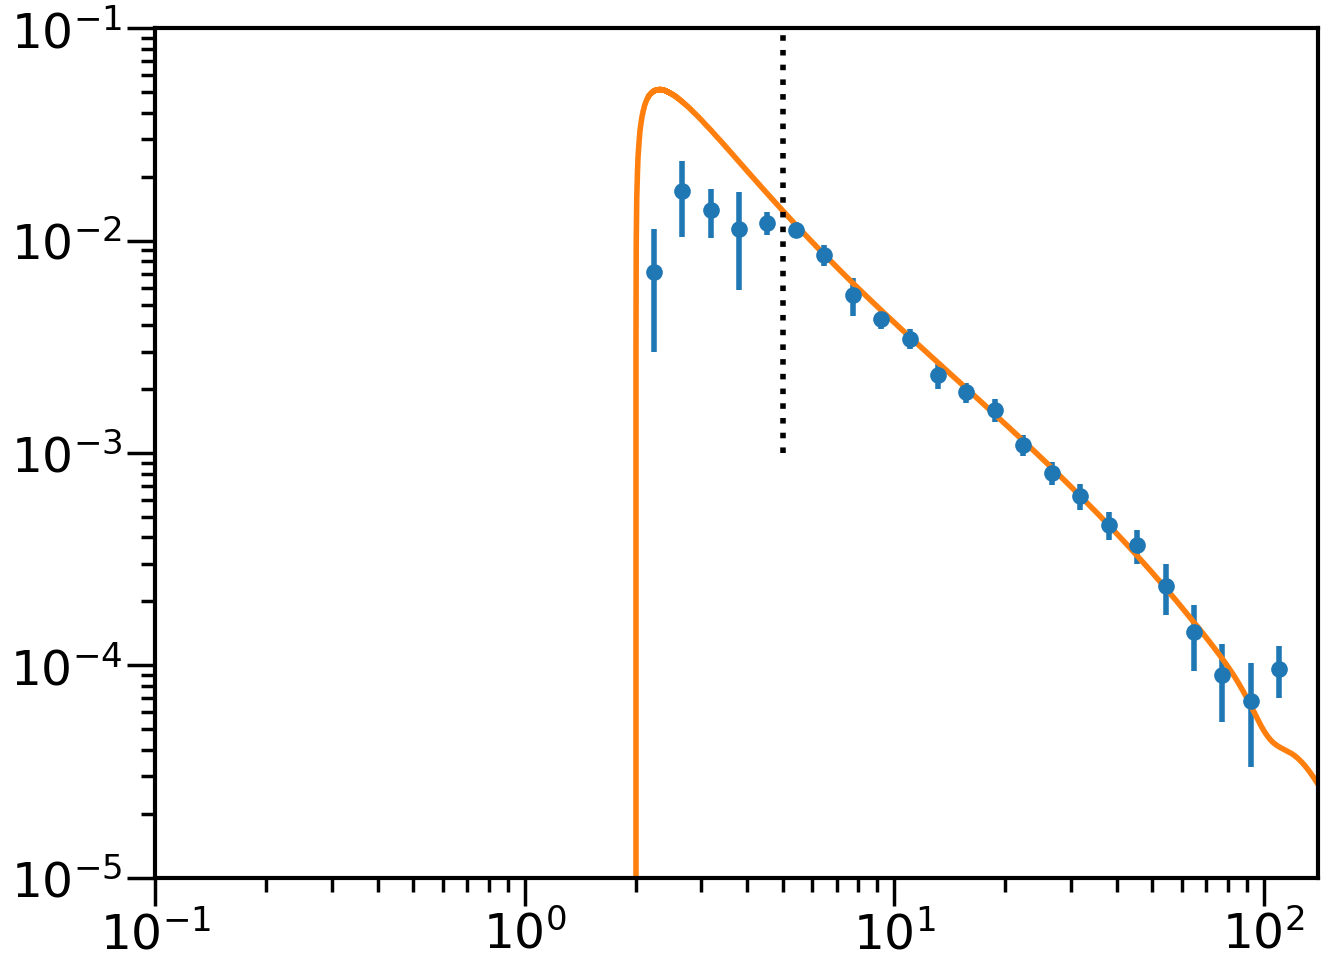

In [39]:
errorbar(m_jk['r'],m_jk2[2]['jk'],m_jk2[2]['jk_err'],fmt='o')
plot(rq[2],xi_wq[2]*wgp_f*-1)
loglog()
xlim(.1,140)
ylim(.00001,.1)
vlines(5,0.001,0.1,color='k',ls=':')

Text(5, 2.0, 'Wedge')

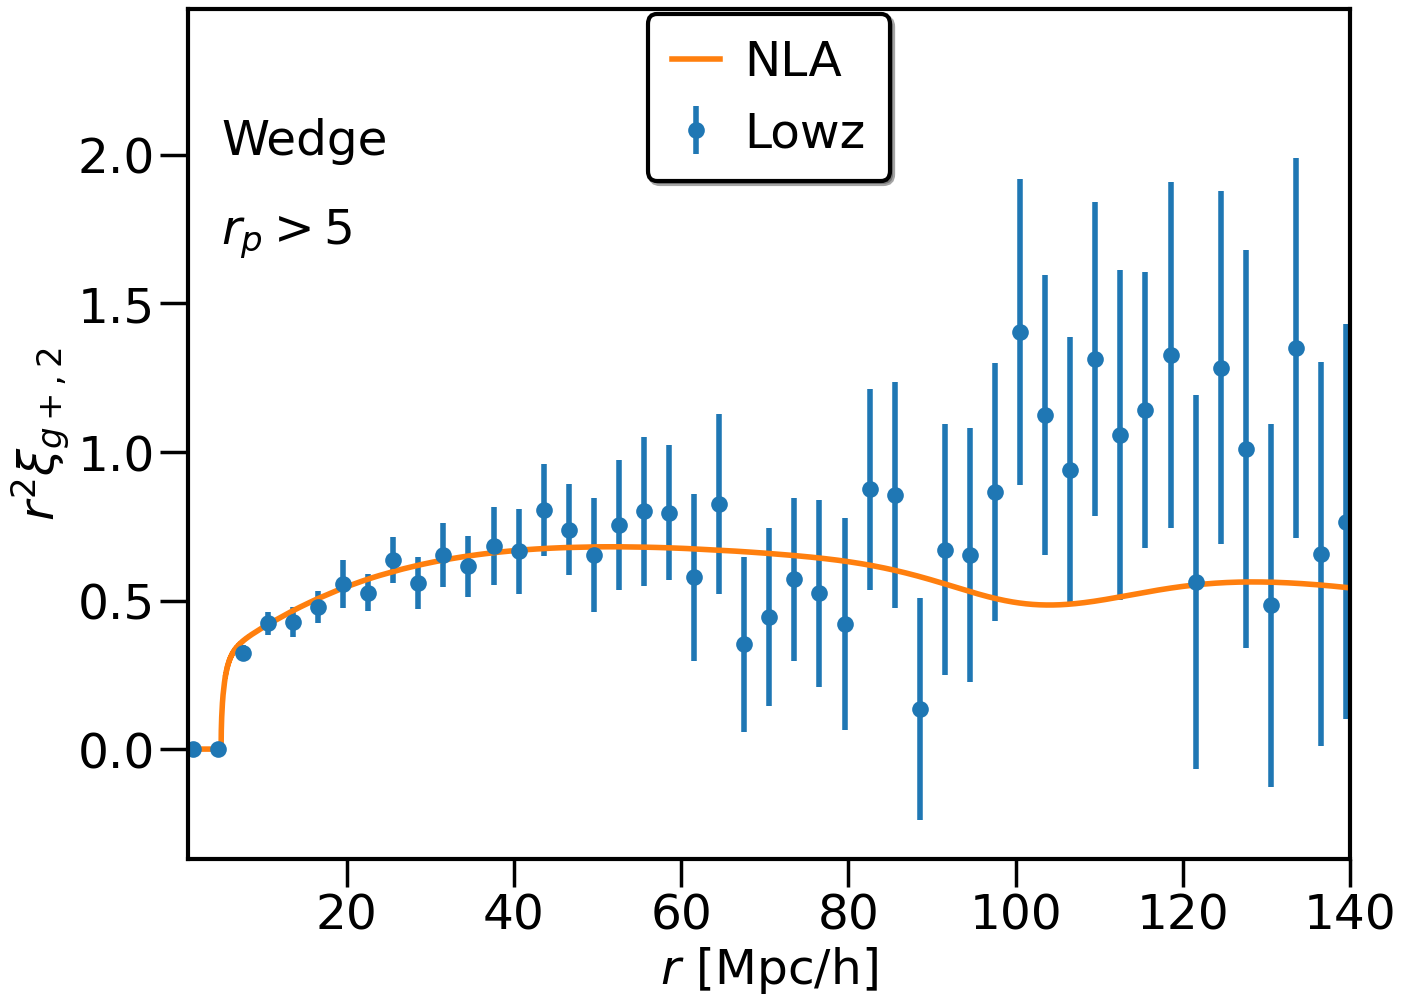

In [40]:
f_pow=2
errorbar(m_jk5_lin['r'],(m_jk5_lin['r']**f_pow)*m_jk5_lin[2]['jk'],(m_jk5_lin['r']**f_pow)*m_jk5_lin[2]['jk_err'],
         label='Lowz',fmt='o')
plot(rq[2],(rq[2]**f_pow)*xi_wq5[2]*wgp_f*-1,label='NLA')
legend(loc='upper center')
# loglog()
# yscale('log')
xlim(1,140)
# ylim(.00001,.1)
xlabel(r'$r$ [Mpc/h]')
ylabel(r'$r^2\xi_{g+,2}$')
text(x=5,y=1.7,s='$r_p>5$')
text(x=5,y=2.,s='Wedge')
# vlines(5,0.001,0.1,color='k',ls=':')

Text(3, 0.05, 'Wedge')

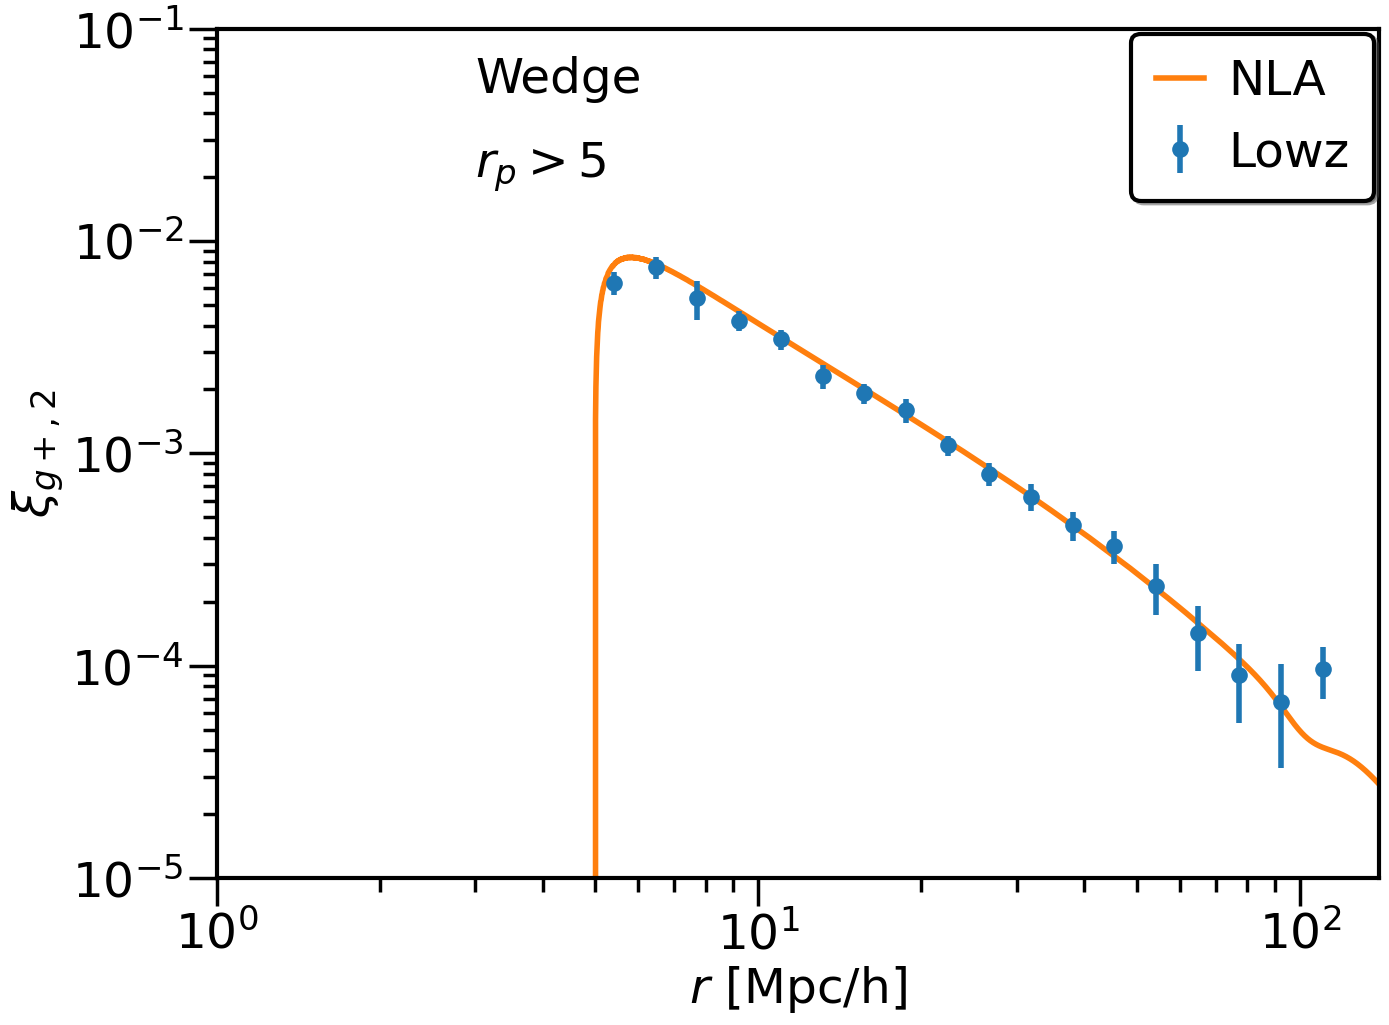

In [41]:
errorbar(m_jk['r'],m_jk5[2]['jk'],m_jk5[2]['jk_err'],label='Lowz',fmt='o',zorder=10)
plot(rq[2],xi_wq5[2]*wgp_f*-1,label='NLA')
legend()
loglog()
xlim(1,140)
ylim(.00001,.1)
xlabel(r'$r$ [Mpc/h]')
ylabel(r'$\xi_{g+,2}$')
text(x=3,y=2.e-2,s='$r_p>5$')
text(x=3,y=5.e-2,s='Wedge')
# vlines(5,0.001,0.1,color='k',ls=':')

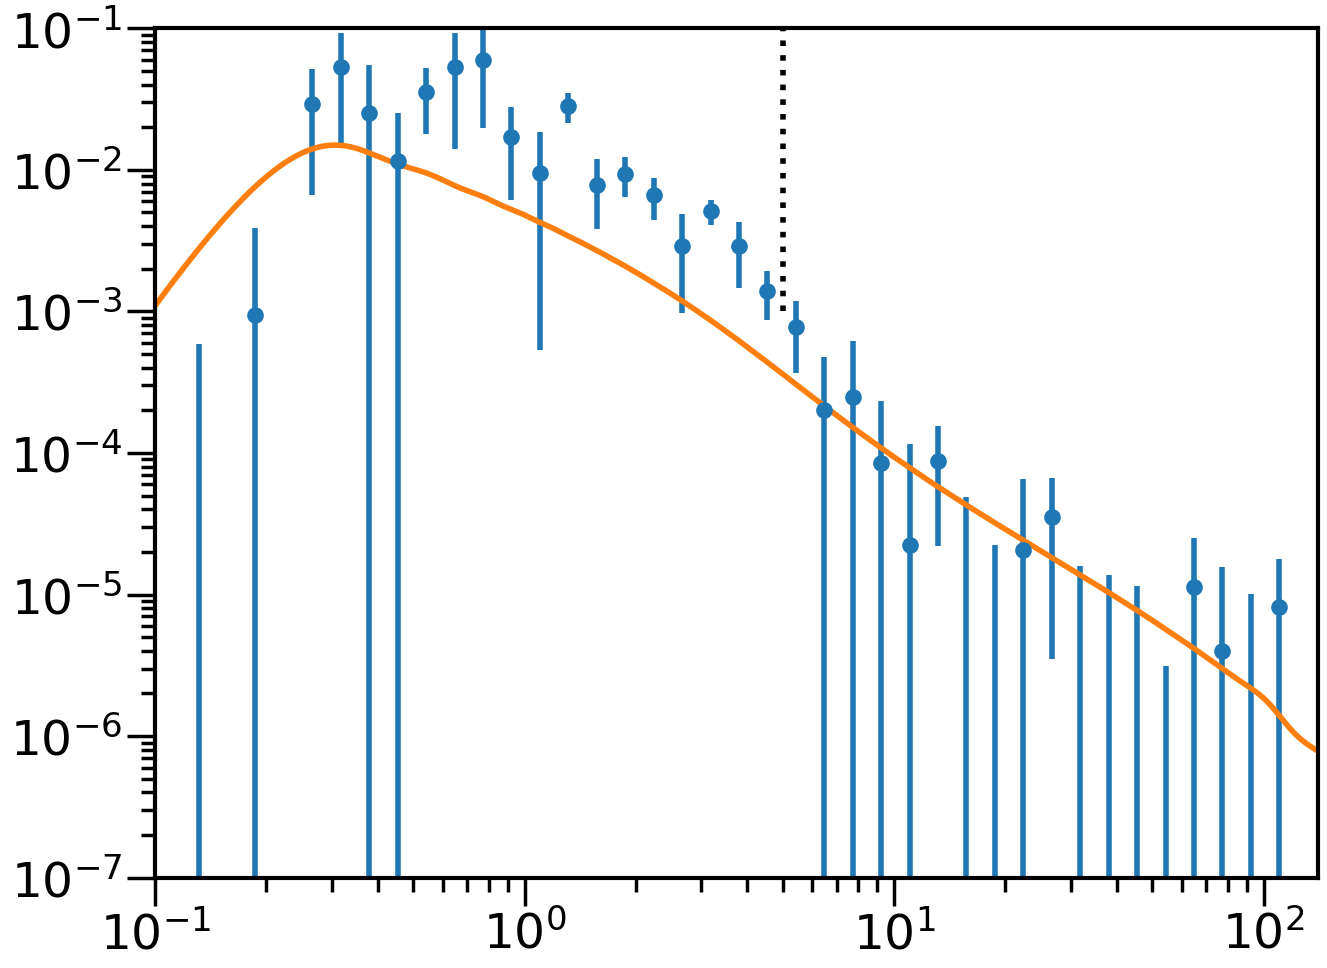

In [42]:
errorbar(m_jk['r'],m_jk[4]['jk'],m_jk[4]['jk_err'],fmt='o')
plot(rq[2],xiq[4]*wgp_f)
loglog()
xlim(.1,140)
ylim(.0000001,.1)
vlines(5,0.001,0.1,color='k',ls=':')

In [43]:
xi_wq_gg[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.68134577e-11, 3.45487053e-11, 3.46134969e-11])

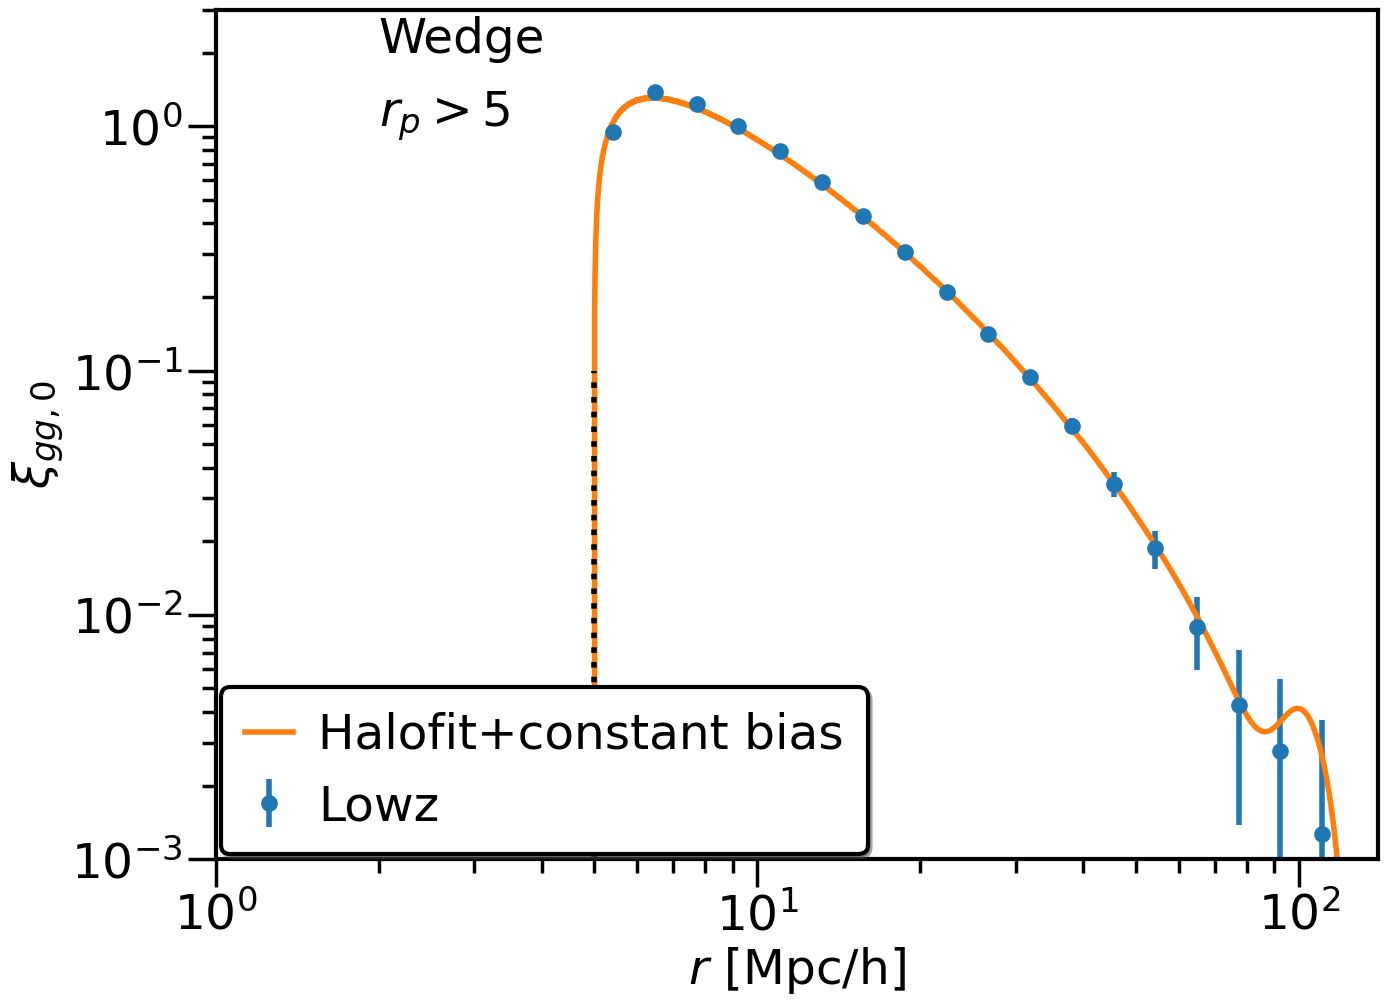

In [44]:
errorbar(m_jk5_gg['r'],m_jk5_gg[0]['jk'],m_jk5_gg[0]['jk_err'],label='Lowz',fmt='o')
plot(rq[2],xi_wq5_gg[0]*wgg_f,label='Halofit+constant bias')
loglog()
xlim(1,140)
ylim(.001,3)
vlines(5,0.001,0.1,color='k',ls=':')
xlabel(r'$r$ [Mpc/h]')
ylabel(r'$\xi_{gg,0}$')
text(x=2,y=1,s='$r_p>5$')
text(x=2,y=2,s='Wedge')
legend()

Text(3, 0.05, 'Wedge')

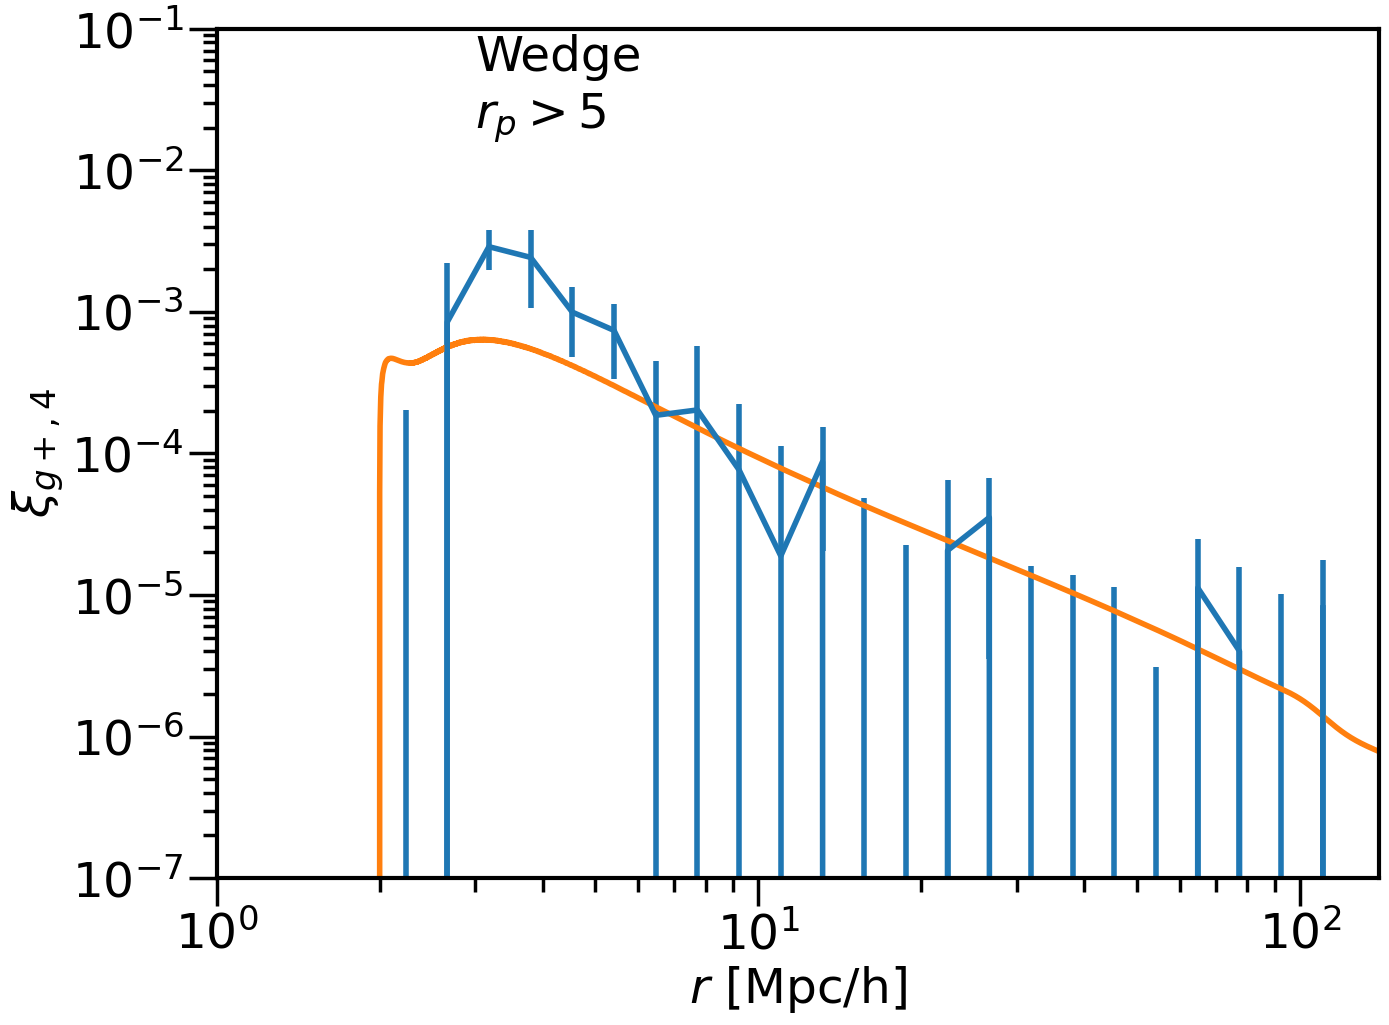

In [45]:
errorbar(m_jk['r'],m_jk2[4]['jk'],m_jk2[4]['jk_err'])
plot(rq[2],xi_wq[4]*wgp_f)
loglog()
xlim(1,140)
ylim(.0000001,.1)
# vlines(5,0.001,0.1,color='k',ls=':')
xlabel(r'$r$ [Mpc/h]')
ylabel(r'$\xi_{g+,4}$')
text(x=3,y=2.e-2,s='$r_p>5$')
text(x=3,y=5.e-2,s='Wedge')


In [46]:
r,xi=pcr.get_xi_multipole(pk=pk,l=[0,2,4])

In [47]:
b_g

1.8

In [48]:
xigp_rp_pi_pcr_gg=pcr.xi_rp_pi(f=0.66,bg1=b_g,pk=pk,l=[0,2,4],spin=0,rp=rpp[0],pi=ppi[:,0])

In [49]:
xigp_rp_pi_pcr=pcr.xi_rp_pi(f=0.66,bg1=b_g,pk=pk,l=[2,4],spin=2,rp=rpp[0],pi=ppi[:,0])
xigp_rp_pi_pcr_f0=pcr.xi_rp_pi(f=0,bg1=b_g,pk=pk,l=[2,4],spin=2,rp=rpp[0],pi=ppi[:,0])

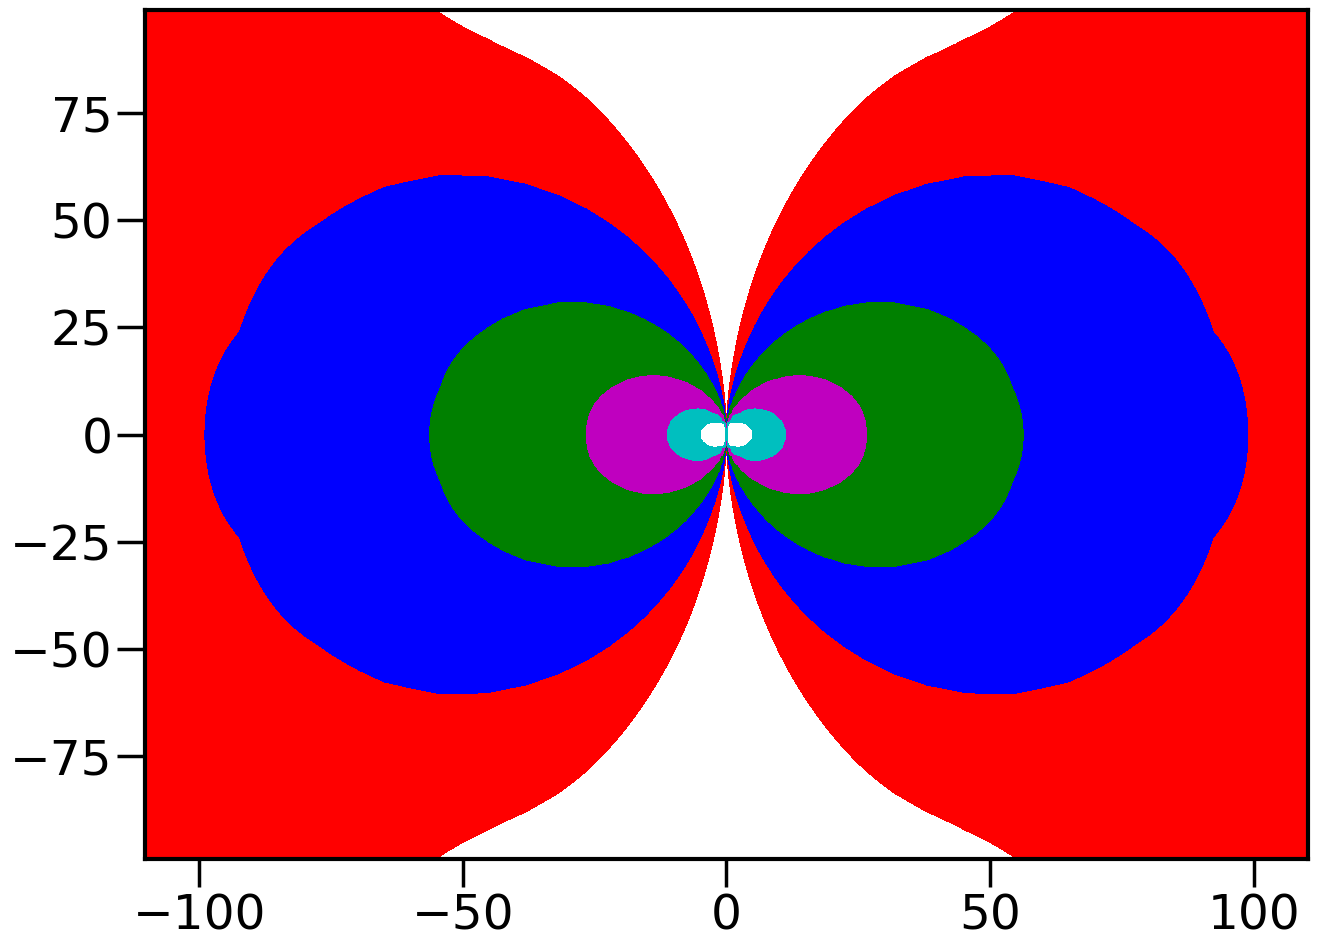

In [50]:
contourf(rpp,ppi,xigp_rp_pi_pcr,levels=ll,colors=colors)

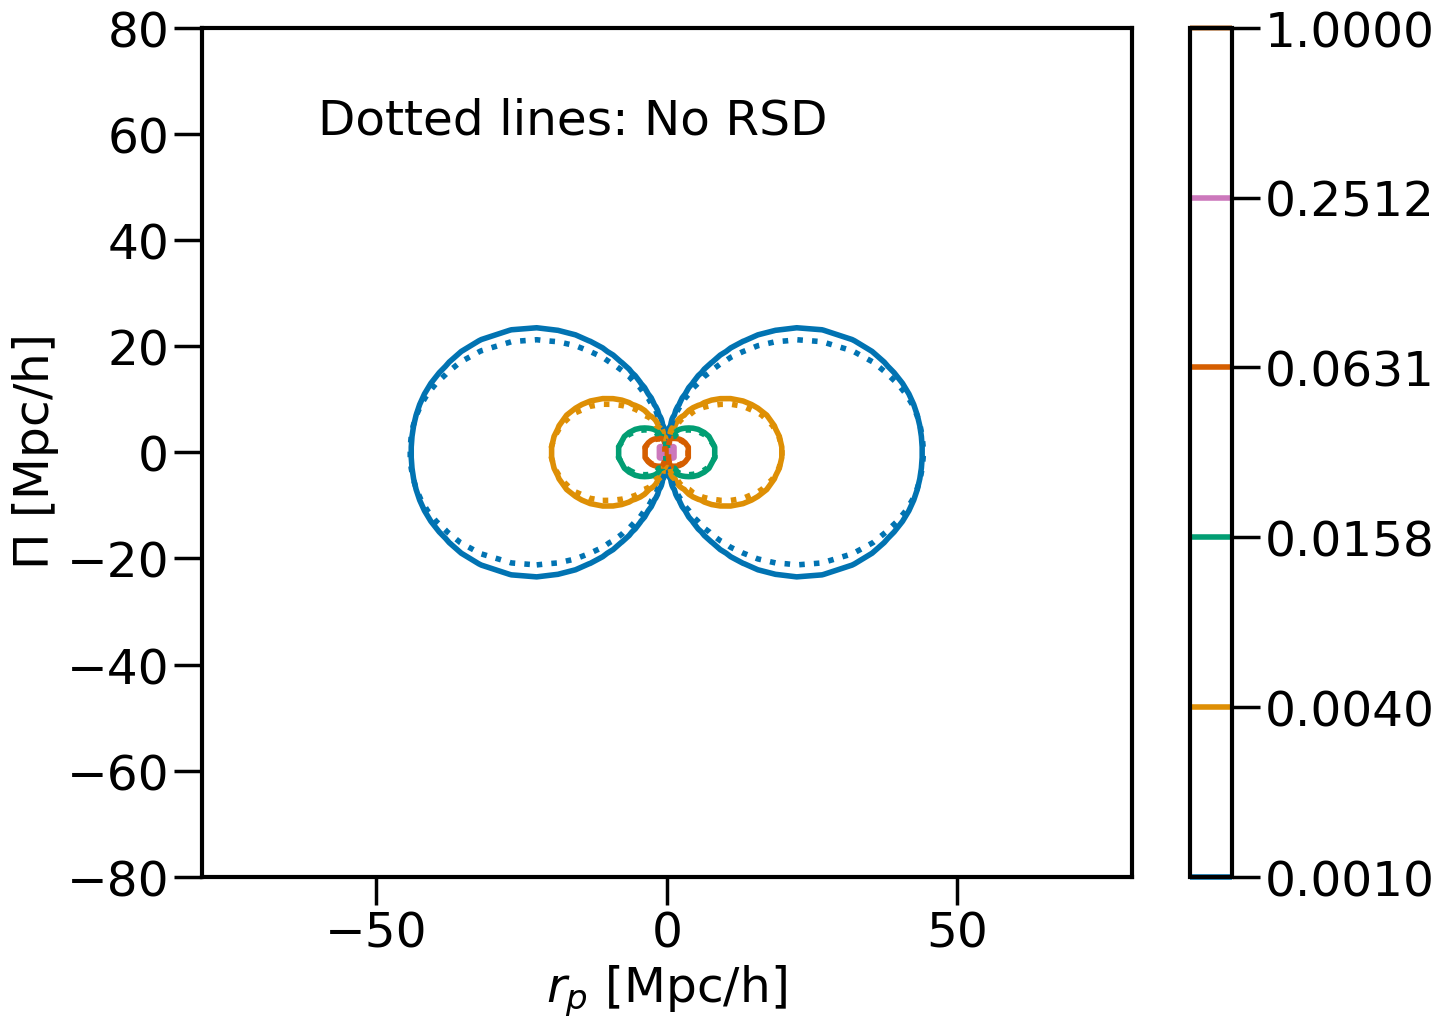

In [51]:
contour(rpp,ppi,xigp_rp_pi_pcr*wgp_f,levels=ll,colors=colors2)
contour(rpp,ppi,xigp_rp_pi_pcr_f0*wgp_f,levels=ll,linestyles=':',colors=colors2)
xlim(-80,80)
ylim(-80,80)
text(y=60,x=-60,s='Dotted lines: No RSD')
xlabel(r'$r_p$ [Mpc/h]')
ylabel(r'$\Pi$ [Mpc/h]')
colorbar()

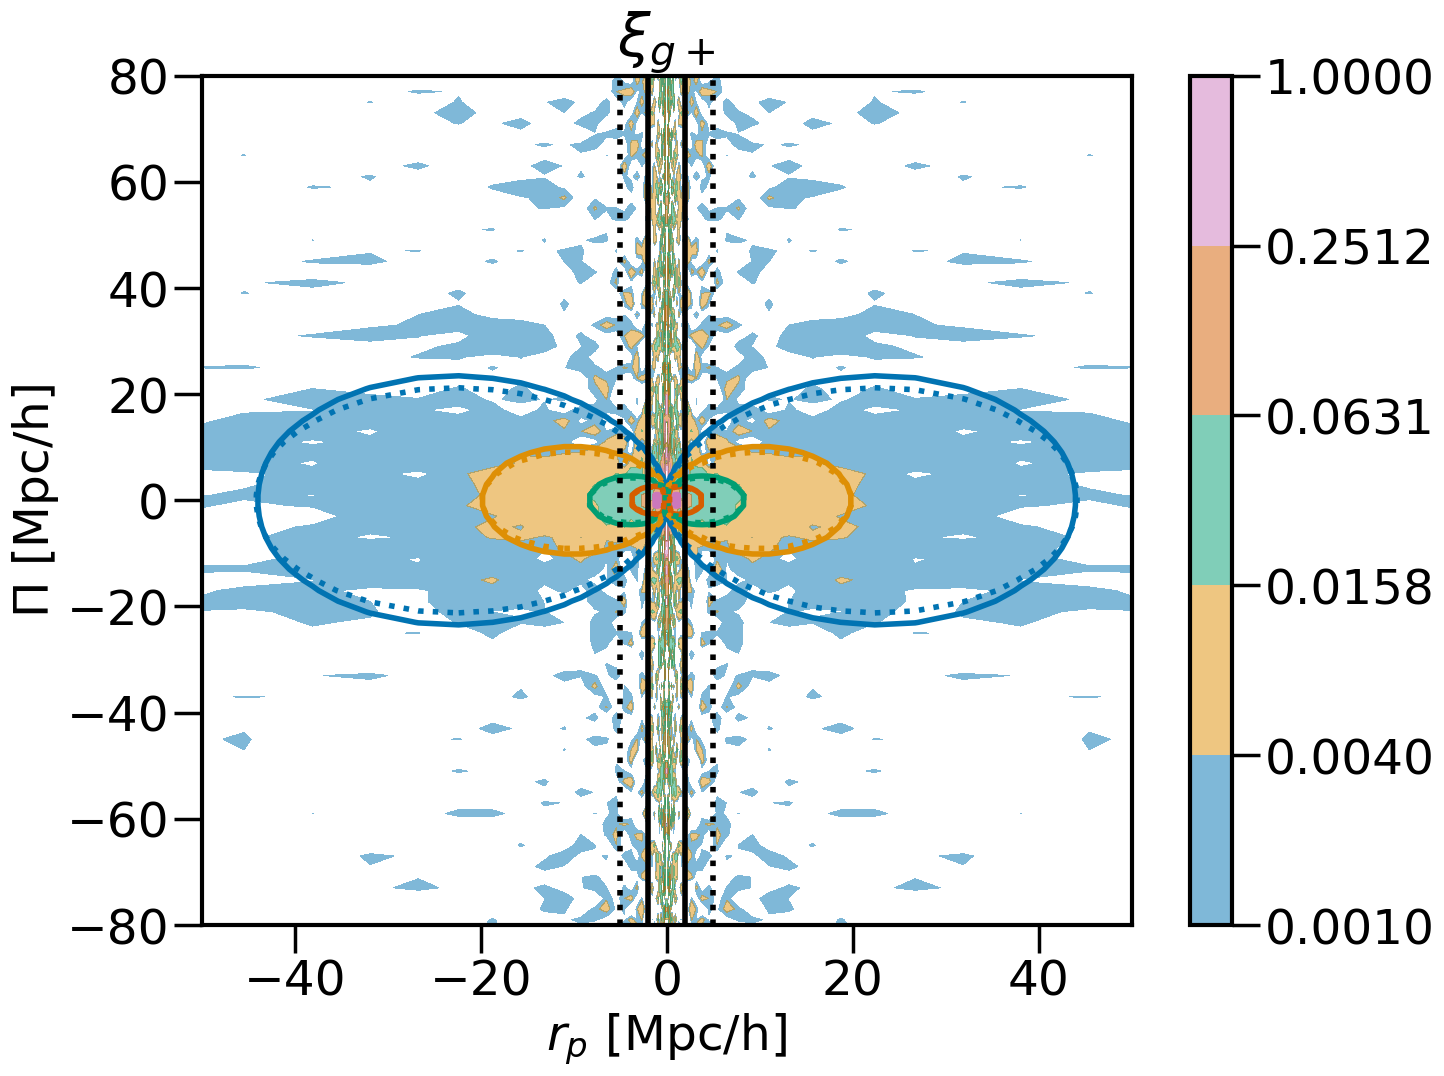

In [52]:
contourf(rpp,ppi,d,levels=ll,colors=colors2,alpha=0.5,zorder=-1)
colorbar()
contour(rpp,ppi,xigp_rp_pi_pcr*wgp_f,levels=ll,colors=colors2)
contour(rpp,ppi,xigp_rp_pi_pcr_f0*wgp_f,levels=ll,linestyles=':',colors=colors2)
xlim(-50,50)
ylim(-80,80)
vlines(2,-80,80,color='k')
vlines(-2,-80,80,color='k')
vlines(5,-80,80,color='k',ls=':')
vlines(-5,-80,80,color='k',ls=':')

xlabel(r'$r_p$ [Mpc/h]')
ylabel(r'$\Pi$ [Mpc/h]')
title(r'$\xi_{g+}$')
fname='xigp_2d.'
savefig(fig_home+fname+fig_format,format=fig_format,bbox_inches='tight')

In [53]:
# r_bins2=np.logspace(np.log10(rmin),np.log10(200),151) #np.logspace(0,2,11)
r_bins2=np.linspace(1,200,900) #np.logspace(0,2,11)
pcr2=Projected_Corr_RSD(rp=r_bins2,pi_max=200,l=[0,2,4,6],k=kh,spins=[0,2])
npi=900
pi2=np.linspace(-200,200,npi)

xigp_rp_pi_pcr2=pcr2.xi_rp_pi(f=0.66,bg1=b_g,pk=pk,l=[2,4],spin=2,rp=r_bins2,pi=pi2)
xigp_rp_pi_pcr2_f0=pcr2.xi_rp_pi(f=0,bg1=b_g,pk=pk,l=[2,4],spin=2,rp=r_bins2,pi=pi2)


/hildafs/projects/phy200040p/sukhdeep/project/Public-code/Hankel_transform/wigner_functions.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  d_mat/=np.sqrt(binom(k+b,b))
//hildafs/projects/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.9/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
//hildafs/projects/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.9/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


Text(0.5, 1.0, '$r\\times\\xi_{g+}$')

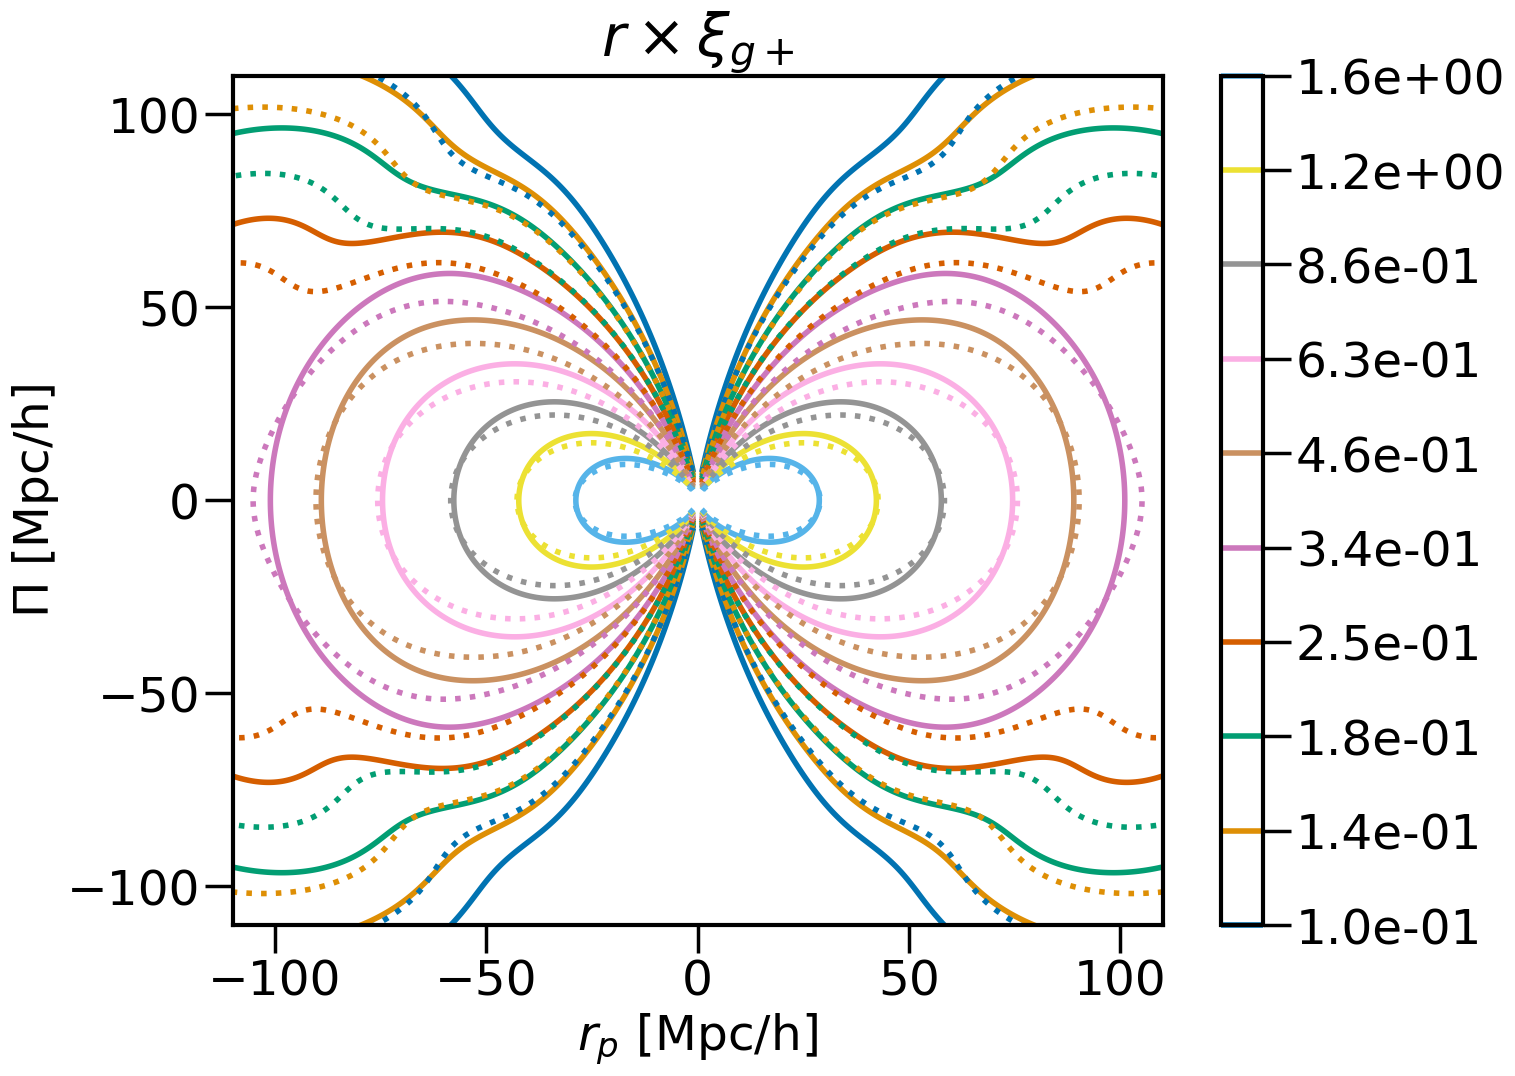

In [54]:

ll2=np.logspace(-1,0.2,10)
# ll2=np.logspace(0,2,10)

# rp2=np.append(-r_bins2[::-1],r_bins2)
rpp2,ppi2=meshgrid(r_bins2,pi2)
r2=np.sqrt(rpp2**2+ppi2**2)
# r2=rpp2**2+ppi2**2
contour(r_bins2,np.linspace(-200,200,npi),r2*xigp_rp_pi_pcr2,levels=ll2,colors=colors2)
contour(r_bins2*-1,np.linspace(-200,200,npi
                              ),xigp_rp_pi_pcr2*r2,levels=ll2,colors=colors2)

contour(r_bins2,np.linspace(-200,200,npi),r2*xigp_rp_pi_pcr2_f0,levels=ll2,colors=colors2,linestyles=':')
contour(r_bins2*-1,np.linspace(-200,200,npi
                              ),xigp_rp_pi_pcr2_f0*r2,levels=ll2,colors=colors2,linestyles=':')


colorbar(format='%.1e')
xlim(-110,110)
ylim(-110,110)

xlabel(r'$r_p$ [Mpc/h]')
ylabel(r'$\Pi$ [Mpc/h]')
title(r'$r\times\xi_{g+}$')

Text(0.5, 1.0, '$\\xi_{g+}$')

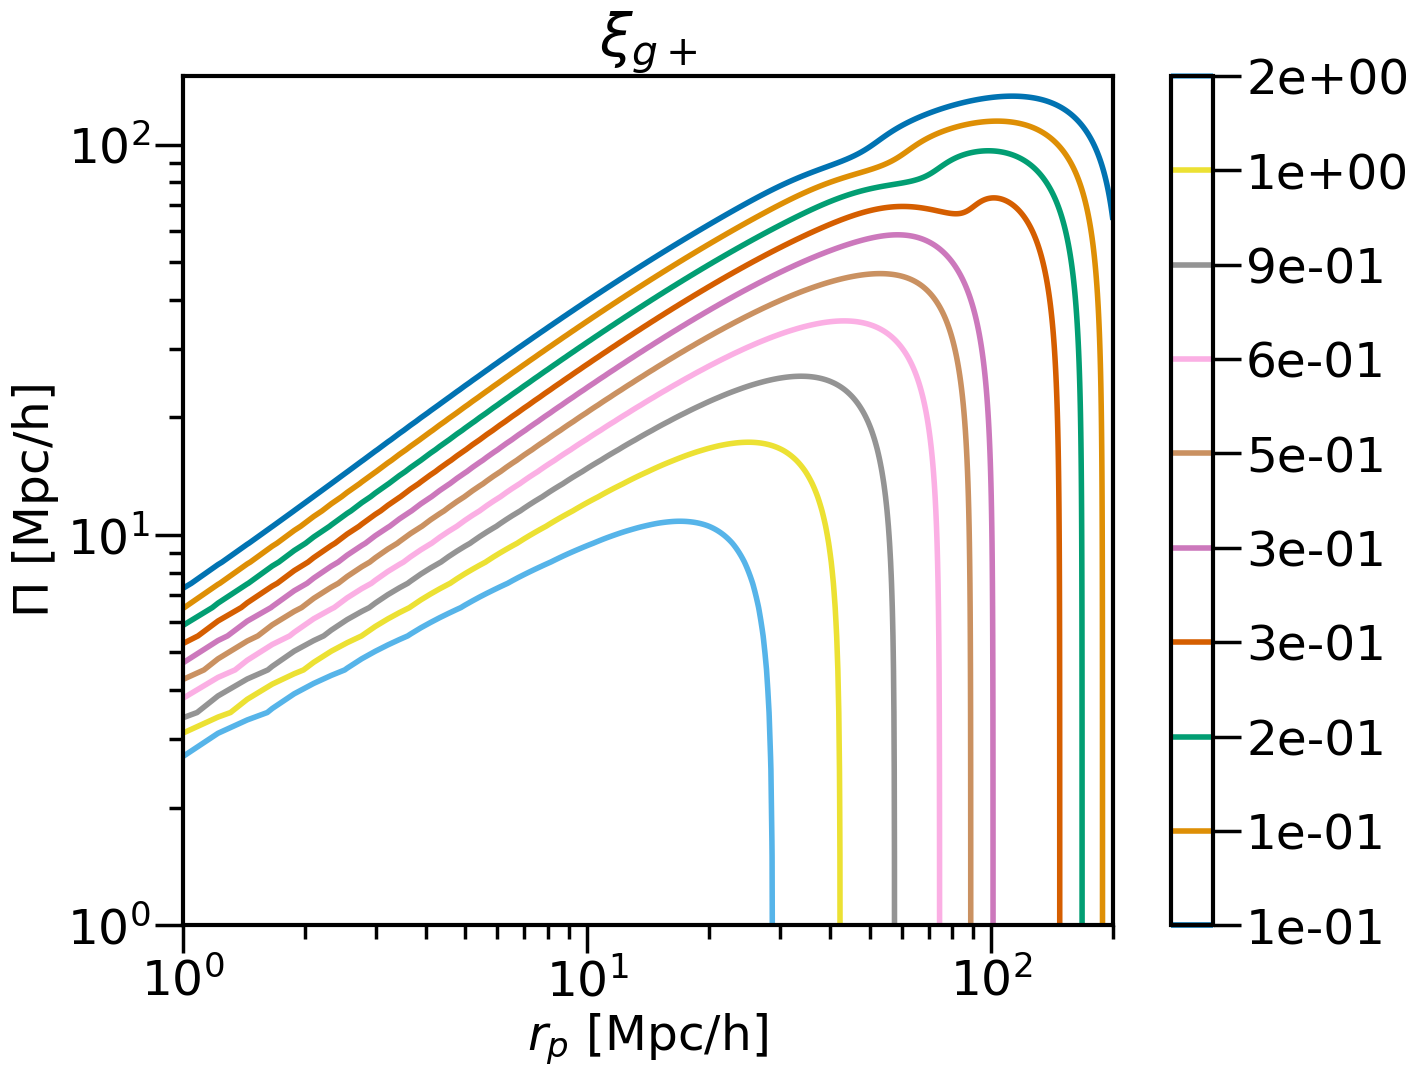

In [55]:
npi=400
pi2=np.linspace(-200,200,npi)
xigp_rp_pi_pcr2=pcr2.xi_rp_pi(f=0.66,bg1=b_g,pk=pk,l=[2,4],spin=2,rp=r_bins2,pi=pi2)

ll2=np.logspace(-1-2,0.2-2,10)
ll2=np.logspace(-1,0.2,10)


# rp2=np.append(-r_bins2[::-1],r_bins2)
rpp2,ppi2=meshgrid(r_bins2,pi2)
r2=np.sqrt(rpp2**2+ppi2**2)
contour(r_bins2,np.linspace(-200,200,npi),xigp_rp_pi_pcr2*r2,levels=ll2,colors=colors2)
# contour(r_bins2*-1,np.linspace(-200,200,npi
#                               ),xigp_rp_pi_pcr2,levels=ll2,colors=colors2)
colorbar(format='%.0e')
xscale('log')
yscale('log')
# xlim(-110,110)
ylim(1,150)

xlabel(r'$r_p$ [Mpc/h]')
ylabel(r'$\Pi$ [Mpc/h]')
title(r'$\xi_{g+}$')

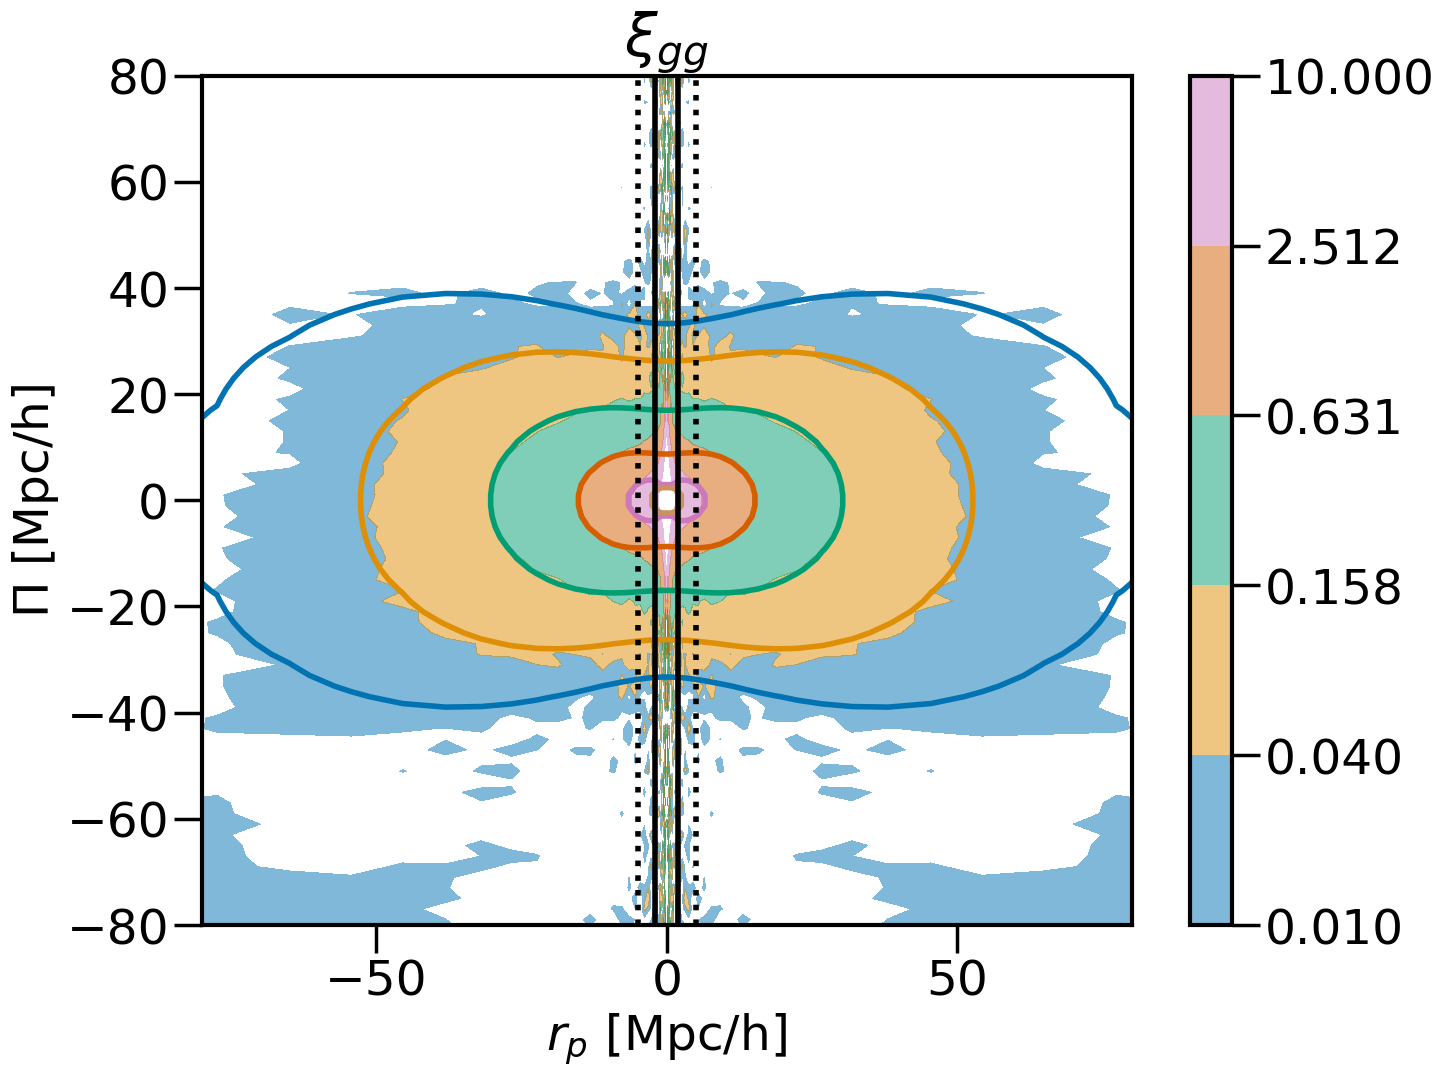

In [56]:
contourf(rpp_gg,ppi_gg,d_gg,levels=ll*10,colors=colors2,alpha=0.5,zorder=-1)
colorbar()
contour(rpp,ppi,xigp_rp_pi_pcr_gg*wgg_f,levels=ll*10,colors=colors2)
xlim(-80,80)
ylim(-80,80)
vlines(2,-80,80,color='k')
vlines(-2,-80,80,color='k')
vlines(5,-80,80,color='k',ls=':')
vlines(-5,-80,80,color='k',ls=':')

xlabel(r'$r_p$ [Mpc/h]')
ylabel(r'$\Pi$ [Mpc/h]')
title(r'$\xi_{gg}$')
fname='xigg_2d.'
savefig(fig_home+fname+fig_format,format=fig_format,bbox_inches='tight')

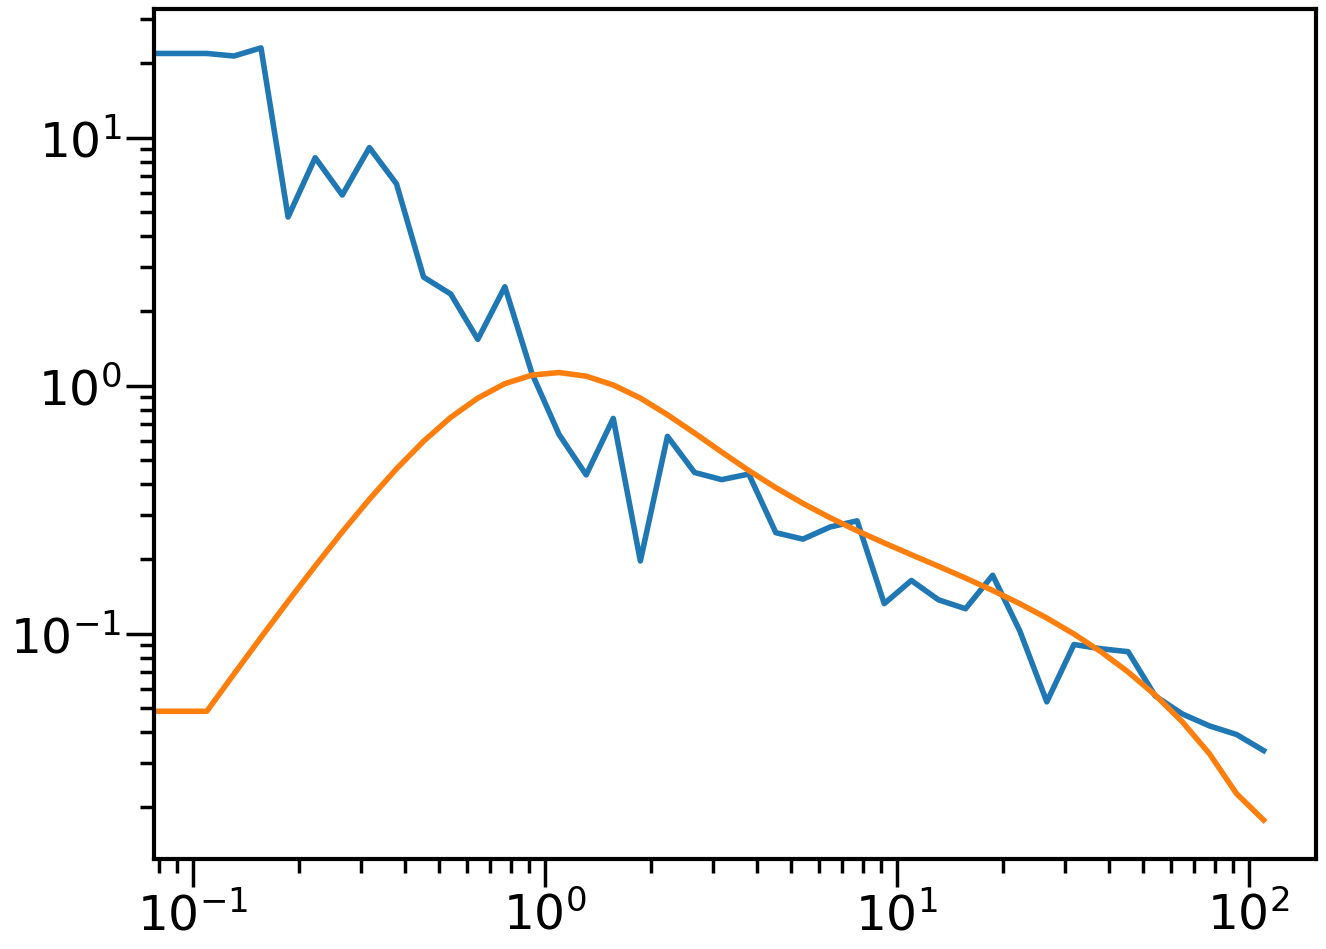

In [57]:
plot(rpp[0],d.T@np.gradient(ppi[:,0]))
plot(rpp[0],xigp_rp_pi_pcr.T@np.gradient(ppi[:,0])*wgp_f)
xscale('log')
yscale('log')

In [58]:
def calc_quadrupole(rG, muG, xiG):
    dmu = np.gradient(muG, axis=0)
    aL = associated_legendre(2,2,muG)
#     return rG[0], (5/2)*np.sum(dmu*aL*xiG, axis=0)
    return rG[0], (5./48.)*np.sum(dmu*aL*xiG, axis=0)

In [59]:
def wedge_quadrupole(r, new_ai, rp_cut=0):
    mu = np.linspace(-1, 1, 500)
    dmu = np.gradient(mu)
    
    rG, muG = np.meshgrid(r, mu)
    
    rpG = np.sqrt(1-muG**2) * rG
    
    alpha = pcr.alpha(2, f/bias, f/bias, spin=2)
    prefactor = -1 * float(alpha) * zeta * new_ai * bias
    
    r_i, xi_i = pcr.get_xi_multipole(pk=pk, l=[2,4])
    xi_i_interp = np.interp(rG, r_i[2], prefactor * xi_i[2], left=0, right=0)
    
    xi = xi_i_interp * associated_legendre(2,2,muG)
    cut_xi = cut_data(rG, muG, xi, thresh=thresh)
    
    quad = (5./48.) * (dmu @ (cut_xi * associated_legendre(2,2,muG)))
    
    return quad

In [60]:
def jk_diff(d1={},d2={},njk=100): #difference between two vectors, with jackknife mean and error
    diff={}
    for i in np.arange(njk):
        diff[i]=d1[i]-d2[i]
    diff=jk_mean(diff)
    return diff

def round_significant_digit(val,err1,err2=None): #round off numbers, for printing in figures
    #val=dat['val'][0]
    #err=dat['err'][0]
    err=err1
    sn=val/err
    dat={}
    val_sign=1
    add_zero=0
    if val<0:
        val_sign=-1
        val=val*val_sign
    try:
        n=int(floor(log10(err)))
    except Exception as e:
        print ('rounding error: ',e)
        n=0
    decimals=np.amax([0,-n+1])
    dat['val']=np.around(val,decimals=decimals)*val_sign
    dat['err1']=np.around(err1,decimals=decimals)
    if not err2 is None:
        dat['err2']=np.around(err2,decimals=decimals)
        
    val_str=str(dat['val'])
    err_str=str(dat['err1'])
    val_err_str=val_str+'$\pm$'+err_str
    if not err2 is None:
        err_str2=str(dat['err2'])
        val_err_str='$'+val_str+'^{+'+err_str+'}_{-'+err_str2+'}$'
    return val_err_str


In [61]:
def w_models(params,rp,rp_cut):
    wgm=pcr.DS_calc(f=0.66,bg=params[0],l=[2,4],pk=pk)
    wgg=pcr.wgg_calc(f=0.66,bg=params[0],pk=pk)

    wgm*=params[1]
    wgm*=wgp_f0*-1
    
    wgg_model=np.interp(rp,pcr.rp,wgg,left=0,right=0)
    wgm_model=np.interp(rp,pcr.rp,wgm,left=0,right=0)
    return wgg_model,wgm_model

In [62]:
def wdge_models(params,rp,rp_cut):
    rgg,wgg_model=multipole_wedge_model(rp_cut=rp_cut,spin=0)
    
    rgm,wgm_model=multipole_wedge_model(rp_cut=rp_cut,spin=2)

    wgg_model[0]*=params[0]**2
    wgm_model[2]*=params[0]*params[1]
    wgm_model[2]*=wgp_f0*-1
    
    wgg_model=np.interp(rp,rgg[0],wgg_model[0],left=0,right=0)
    wgm_model=np.interp(rp,rgm[2],wgm_model[2],left=0,right=0)
    return wgg_model,wgm_model

In [63]:
def chisq_dat(params,rp,wgg,wgm,cov_inv_gg,cov_inv_gm,rp_cut,bg1,wgg_model,wgm_model):
    njk=100
    hf=(njk-1.)/(njk-2.-len(rp))
    
    wgg_model_i=wgg_model*params[0]**2
    wgm_model_i=wgm_model*params[0]*params[1]

    loss_gg=wgg-wgg_model_i
    loss_gm=wgm-wgm_model_i
    chisq_gg=loss_gg@cov_inv_gg@loss_gg
    chisq_gp=loss_gm@cov_inv_gm@loss_gm
    
    chisq=chisq_gg+chisq_gp

#     chisq/=hf
#     print(chisq_gg,chisq_gp,params)
    return .5*chisq#,wgg_model,wgm_model

In [64]:
def multipole_cut(dat={},r_max=65,r_min=5,njk=100,diag_cov=True):
    dc={}
    x=dat['r']>r_min
    x*=dat['r']<r_max
    for i_l in dat.keys():
        if i_l=='r':
            continue
        dc[i_l]={}
        for i in range(njk):
            dc[i_l][i]=dat[i_l][i][x]
        dc[i_l]=jk_mean(dc[i_l])
        if diag_cov:
            dc[i_l]['cov']=np.diag(np.diag(dc[i_l]['cov']))
        dc[i_l]['cov_inv']=np.linalg.inv(dc[i_l]['cov'])
    dc['r']=dat['r'][x]
    return dc

In [65]:
def w_cut(dat={},r_max=65,r_min=5,njk=100,diag_cov=True):
    dc={}
    x=dat[0]['rp']>r_min
    x*=dat[0]['rp']<r_max
    for i_l in ['wgg','wgp']:
        dc[i_l]={}
        for i in range(njk):
#             print(x.shape,dat[i].shape)
            dc[i_l][i]=dat[i][i_l][x]
        dc[i_l]=jk_mean(dc[i_l])
        if diag_cov:
            dc[i_l]['cov']=np.diag(np.diag(dc[i_l]['cov']))
        dc[i_l]['cov_inv']=np.linalg.inv(dc[i_l]['cov'])
    dc['r']=dat[0]['rp'][x]
    return dc

In [66]:
mjk_cut=multipole_cut(dat=m_jk2,njk=100)

In [67]:
def fit_dat(home='',dataset='',corr='ia',z=0.27,r_max=80,r_min=5,rp_cut=5,njk=100,lbl='',use_chisq=True,diag_cov=False,bg1=None,
           use_tatt_model=False,minimize_method='Nelder-Mead',multipole=True):
    kargs=locals()
    
    if multipole:
        dat0=jk_read(home=home,dataset=dataset,njk=njk,bins='_bins2D')
        m_jk2=calc_multipole(dat0,rp_cut=rp_cut)
        m_jk2=multipole_cut(dat=m_jk2,r_max=r_max,r_min=r_min,njk=100)
        m_jk2_gg=calc_multipole(dat0,rp_cut=rp_cut,var='wgg')
        m_jk2_gg=multipole_cut(dat=m_jk2_gg,r_max=r_max,r_min=r_min,njk=100)
        dat=m_jk2
        rp=dat['r']
        wgg_model,wgm_model=wdge_models([1,1],rp,rp_cut)
    else:
        dat0=jk_read(home=home,dataset=dataset,njk=njk,bins='_bins')
        dat=w_cut(dat=dat0,r_max=r_max,r_min=r_min,njk=100)
        m_jk2={2:dat['wgp'],'r':dat['r']}
        m_jk2_gg={0:dat['wgg'],'r':dat['r']}
        rp=dat['r']
        wgg_model,wgm_model=w_models([1,1],rp,rp_cut)

    
    p0=[1.75,4.2]
    params={}
    bg1_i=None
    
    for i in np.arange(njk):
        if bg1 is not None:
            bg1_i=bg1[i]

        pm=minimize(chisq_dat,p0,args=(rp,m_jk2_gg[0][i],m_jk2[2][i],m_jk2_gg[0]['cov_inv'],m_jk2[2]['cov_inv'], 
                                           rp_cut,bg1_i,wgg_model,wgm_model) ,method=minimize_method)
        params[i]=pm.x
#         print(i,params[i])
    params=jk_mean(params,njk=njk)
    chisq_jk=2*chisq_dat(params['jk'],rp,m_jk2_gg[0][i],m_jk2[2][i],m_jk2_gg[0]['cov_inv'],m_jk2[2]['cov_inv'], 
                                           rp_cut,bg1_i,wgg_model,wgm_model)
    chisq_jk_gg=2*chisq_dat(params['jk'],rp,m_jk2_gg[0][i],m_jk2[2][i],m_jk2_gg[0]['cov_inv'],m_jk2[2]['cov_inv'], 
                                           rp_cut,bg1_i,wgg_model,wgm_model)
    chisq_jk_gm=2*chisq_dat(params['jk'],rp,m_jk2_gg[0][i],m_jk2[2][i],m_jk2_gg[0]['cov_inv'],m_jk2[2]['cov_inv'], 
                                           rp_cut,bg1_i,wgg_model,wgm_model)
    out={}
    out['m_gg']=m_jk2_gg
    out['m_gm']=m_jk2
    out['params']=params
    out['chisq']=chisq_jk
    out['chisq_gg']=chisq_jk_gg
    out['chisq_gm']=chisq_jk_gm
    
    r=m_jk2['r']
    out['r']=r
    bg=np.atleast_1d(params['jk'][0])
    bg2=bg
    A_I=np.atleast_1d(params['jk'][1])
    if bg1 is not None:
        bg2=bg1['jk']
    out['wgg_model']=wgg_model#*bg**2
    out['wgp_model']=wgm_model#*bg*A_I
    out['corr']=corr
    out['r_max']=r_max
    out['r_min']=r_min
    out['label']=lbl
    out['z']=z

    return out

In [68]:
xx=np.logspace(-1,np.log10(120),41)
0.5*(xx[1:]+xx[:-1])

array([1.09696592e-01, 1.30970253e-01, 1.56369553e-01, 1.86694587e-01,
       2.22900611e-01, 2.66128134e-01, 3.17738851e-01, 3.79358528e-01,
       4.52928222e-01, 5.40765422e-01, 6.45637051e-01, 7.70846627e-01,
       9.20338325e-01, 1.09882122e+00, 1.31191763e+00, 1.56634022e+00,
       1.87010345e+00, 2.23277604e+00, 2.66578239e+00, 3.18276245e+00,
       3.80000140e+00, 4.53694263e+00, 5.41680023e+00, 6.46729022e+00,
       7.72150365e+00, 9.21894900e+00, 1.10067967e+01, 1.31413649e+01,
       1.56898939e+01, 1.87326637e+01, 2.23655235e+01, 2.67029105e+01,
       3.18814548e+01, 3.80642837e+01, 4.54461600e+01, 5.42596170e+01,
       6.47822839e+01, 7.73456309e+01, 9.23454108e+01, 1.10254125e+02])

In [69]:
file_home='/hildafs/projects/phy200040p/sukhdeep/project/IA_multipole_lowz/data_out/ia/coor_data_out/'
file_name='full_full_wt0'

fp=fit_dat(home=file_home,dataset=file_name)

0.10416666666666667
0.0125
0.5
2.5
4.5


//hildafs/projects/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.9/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [70]:
file_home='/hildafs/projects/phy200040p/sukhdeep/project/IA_multipole_lowz/data_out/ia_proj/coor_data_out/'
file_name='full_full_wt0'

fp_w=fit_dat(home=file_home,dataset=file_name,multipole=False)

In [71]:
fp['params']['jk'],fp['params']['jk_err']

(array([1.80687503, 4.22755657]), array([0.02823169, 0.22581536]))

In [72]:
fp_w['params']['jk'],fp_w['params']['jk_err']

(array([1.77813991, 4.25975186]), array([0.04218273, 0.41208806]))

[]

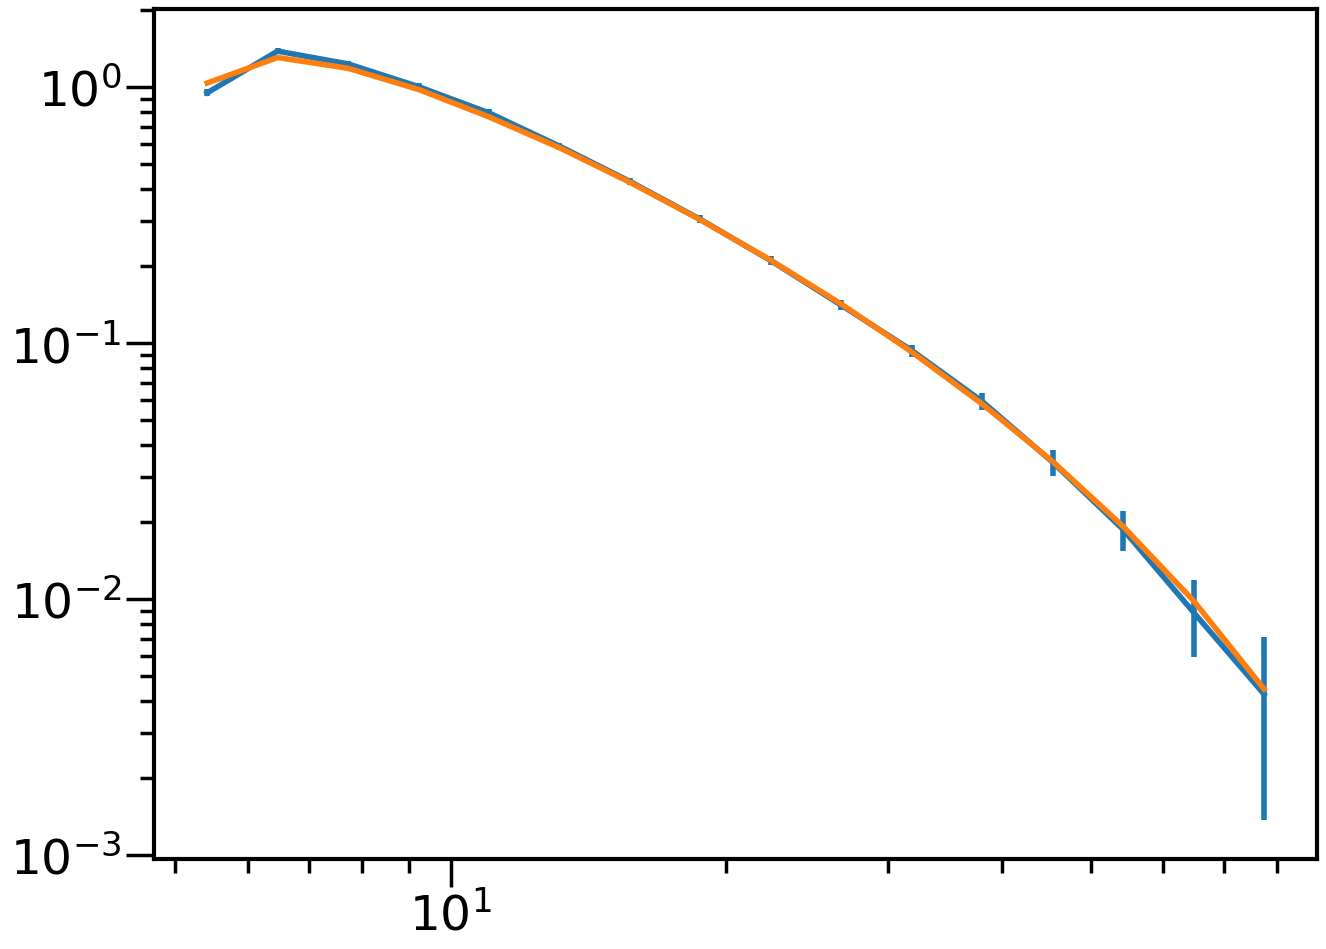

In [73]:
errorbar(fp['m_gg']['r'],fp['m_gg'][0]['jk'],fp['m_gg'][0]['jk_err'])
errorbar(fp['m_gg']['r'],fp['wgg_model']*b_g**2)
loglog()

[]

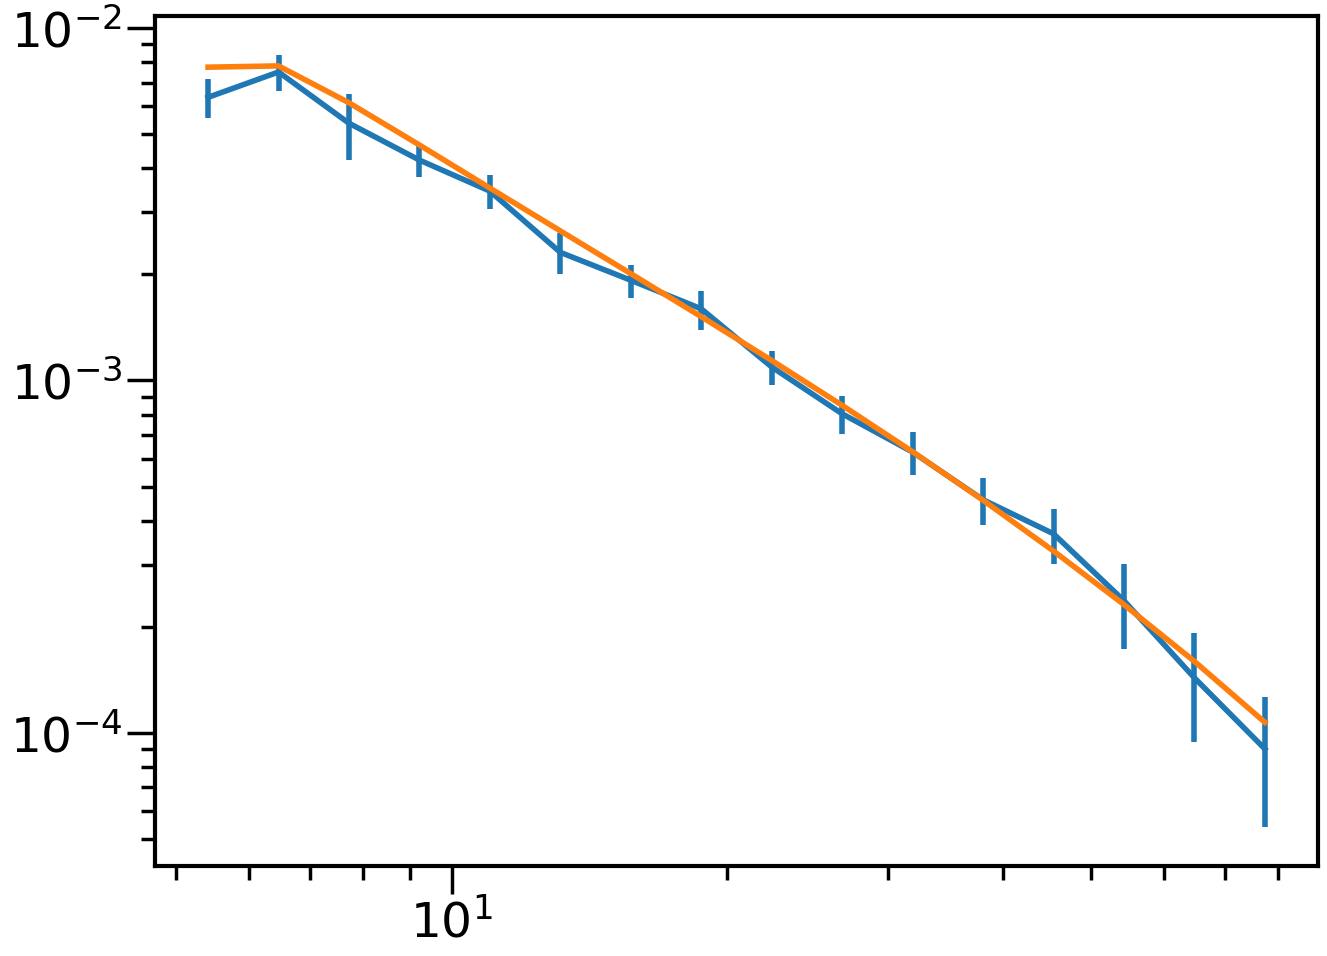

In [74]:
errorbar(fp['m_gm']['r'],fp['m_gm'][2]['jk'],fp['m_gm'][2]['jk_err'])
errorbar(fp['m_gm']['r'],fp['wgp_model']*b_g*A_I)
loglog()

In [75]:
fp['m_gm'][2][0]@fp['m_gm'][2]['cov_inv']@fp['m_gm'][2][0]

830.3674040138847

In [76]:
(fp['m_gm'][2][0]-fp['wgp_model']*b_g*A_I)@fp['m_gm'][2]['cov_inv']@(fp['m_gm'][2][0]-fp['wgp_model']*b_g*A_I)

6.498021208133717

In [77]:
chisq_dat([b_g,A_I],fp['m_gm']['r'],fp['m_gg'][0][0],fp['m_gm'][2][0],fp['m_gg'][0]['cov_inv'],fp['m_gm'][2]['cov_inv']
          ,5,1.8,fp['wgg_model'],fp['wgp_model'])

11.563742378244426

In [78]:
shape_samples=["full", "central", "satellite", "field", "group", "bcg", "lum1", "lum2", "lum3", "lum4"]

In [79]:
samp_labels=["Lowz", "Central", "Satellite", "Field", "Group", "BGG", "$L_1$", "$L_2$", "$L_3$", "$L_4$"]
samp_labels={shape_samples[i]:samp_labels[i] for i in range(len(samp_labels))}

In [80]:
mutipole_fits={}
file_home='/hildafs/projects/phy200040p/sukhdeep/project/IA_multipole_lowz/data_out/ia/coor_data_out/'
for samp in shape_samples:
    file_name=samp+'_full_wt0'
    mutipole_fits[samp]=fit_dat(home=file_home,dataset=file_name)

0.10416666666666667
0.0125
0.5
2.5
4.5
0.10416666666666667
0.0125
0.5
2.5
4.5
0.10416666666666667
0.0125
0.5
2.5
4.5
0.10416666666666667
0.0125
0.5
2.5
4.5
0.10416666666666667
0.0125
0.5
2.5
4.5
0.10416666666666667
0.0125
0.5
2.5
4.5
0.10416666666666667
0.0125
0.5
2.5
4.5
0.10416666666666667
0.0125
0.5
2.5
4.5
0.10416666666666667
0.0125
0.5
2.5
4.5
0.10416666666666667
0.0125
0.5
2.5
4.5


In [81]:
w_fits={}
file_home='/hildafs/projects/phy200040p/sukhdeep/project/IA_multipole_lowz/data_out/ia_proj/coor_data_out/'
for samp in shape_samples:
    file_name=samp+'_full_wt0'
    w_fits[samp]=fit_dat(home=file_home,dataset=file_name,multipole=False)

In [82]:
markers=['o','^','>','v','<','s']

Text(1.6, -1, 'Closed markers= w fit')

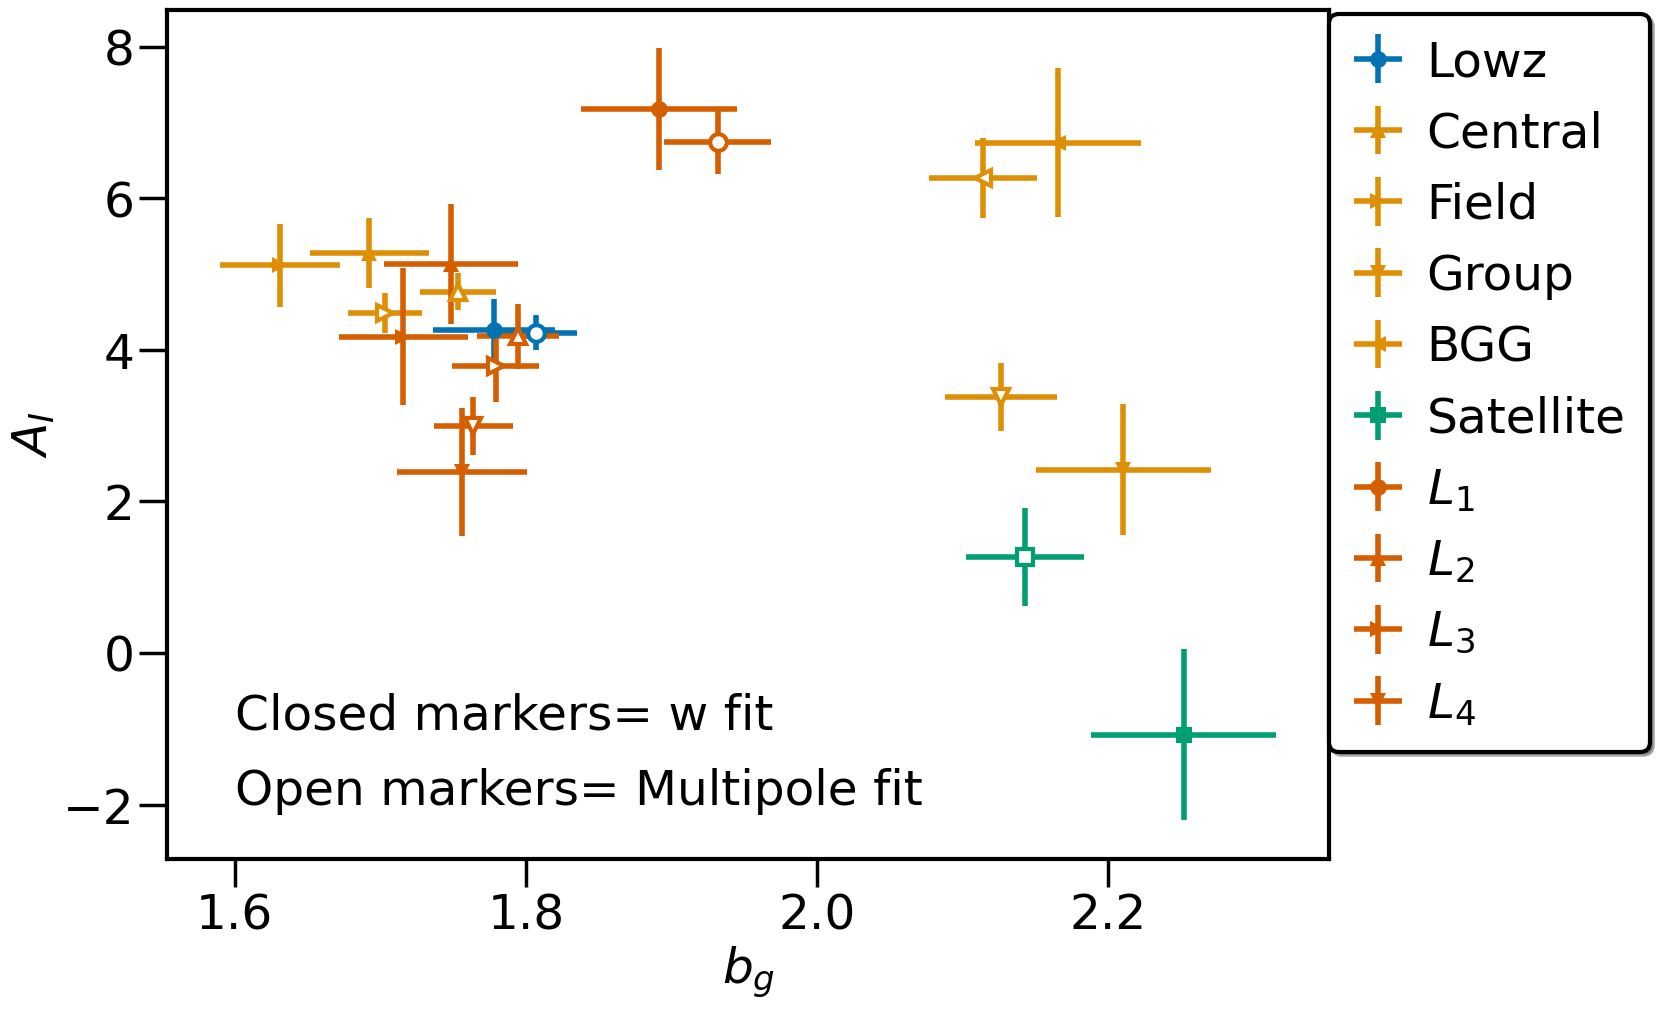

In [83]:
i=0
j=0
for samp in ['full']: #w_fits.keys():#shape_samples:
    errorbar(w_fits[samp]['params']['jk'][0],w_fits[samp]['params']['jk'][1],
            xerr=w_fits[samp]['params']['jk_err'][0],yerr=w_fits[samp]['params']['jk_err'][1],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp],ms=12)
    errorbar(mutipole_fits[samp]['params']['jk'][0],mutipole_fits[samp]['params']['jk'][1],
            xerr=mutipole_fits[samp]['params']['jk_err'][0],yerr=mutipole_fits[samp]['params']['jk_err'][1],
             c=colors2[i],fmt=markers[j%len(markers)],mew=3,mfc='white',ms=12)
    j+=1
    i+=1

for samp in ["central", "field", "group", "bcg"]: #w_fits.keys():#shape_samples:
    errorbar(w_fits[samp]['params']['jk'][0],w_fits[samp]['params']['jk'][1],
            xerr=w_fits[samp]['params']['jk_err'][0],yerr=w_fits[samp]['params']['jk_err'][1],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp])
    errorbar(mutipole_fits[samp]['params']['jk'][0],mutipole_fits[samp]['params']['jk'][1],
            xerr=mutipole_fits[samp]['params']['jk_err'][0],yerr=mutipole_fits[samp]['params']['jk_err'][1],
             c=colors2[i],fmt=markers[j%len(markers)],mew=3,mfc='white')
    j+=1
i+=1
for samp in ["satellite"]: #w_fits.keys():#shape_samples:
    errorbar(w_fits[samp]['params']['jk'][0],w_fits[samp]['params']['jk'][1],
            xerr=w_fits[samp]['params']['jk_err'][0],yerr=w_fits[samp]['params']['jk_err'][1],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp])
    errorbar(mutipole_fits[samp]['params']['jk'][0],mutipole_fits[samp]['params']['jk'][1],
            xerr=mutipole_fits[samp]['params']['jk_err'][0],yerr=mutipole_fits[samp]['params']['jk_err'][1],
             c=colors2[i],fmt=markers[j%len(markers)],mew=3,mfc='white')
    j+=1
i+=1

for samp in ["lum1", "lum2", "lum3", "lum4"]: #w_fits.keys():#shape_samples:
    errorbar(w_fits[samp]['params']['jk'][0],w_fits[samp]['params']['jk'][1],
            xerr=w_fits[samp]['params']['jk_err'][0],yerr=w_fits[samp]['params']['jk_err'][1],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp])
    errorbar(mutipole_fits[samp]['params']['jk'][0],mutipole_fits[samp]['params']['jk'][1],
            xerr=mutipole_fits[samp]['params']['jk_err'][0],yerr=mutipole_fits[samp]['params']['jk_err'][1],
             c=colors2[i],fmt=markers[j%len(markers)],mew=3,mfc='white')
    j+=1
i+=1


legend(loc='upper right',bbox_to_anchor=(1.28,1),)
xlabel(r'$b_g$')
ylabel(r'$A_I$')
text(x=1.6,y=-2,s='Open markers= Multipole fit')
text(x=1.6,y=-1,s='Closed markers= w fit')

Text(0, 0.5, '$b_g [\\xi_{gg,0}]$')

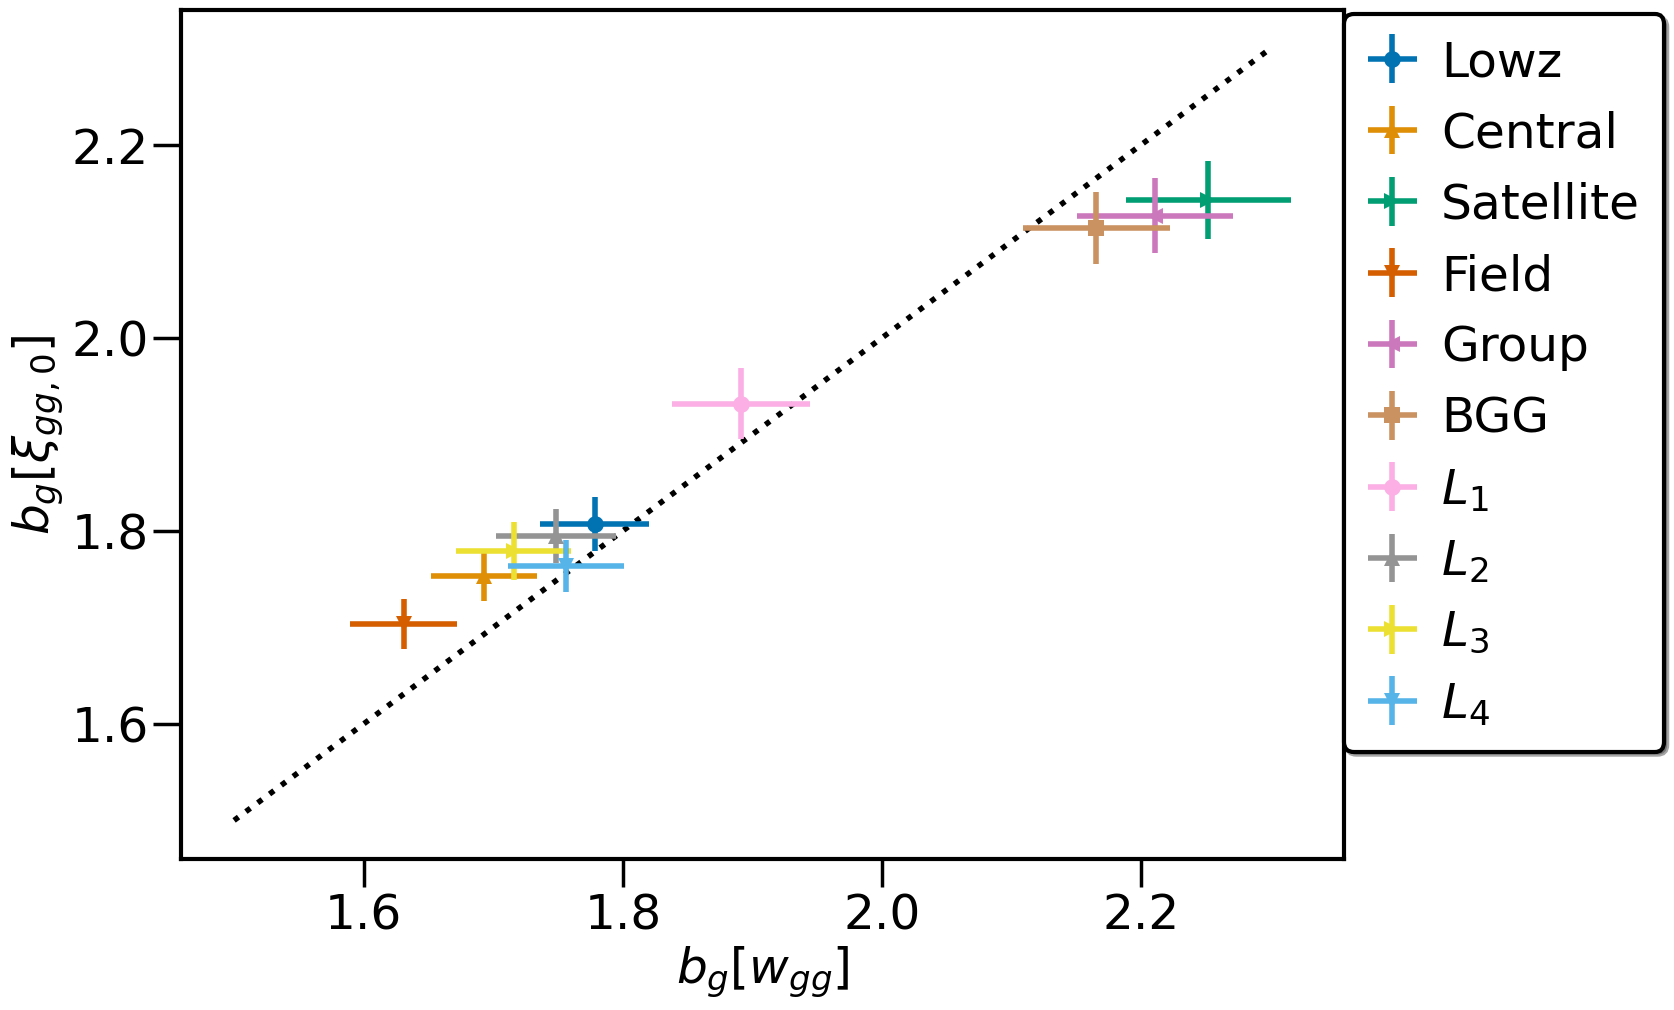

In [84]:
i=0
for samp in w_fits.keys():#shape_samples:
    errorbar(w_fits[samp]['params']['jk'][0],mutipole_fits[samp]['params']['jk'][0],
            xerr=w_fits[samp]['params']['jk_err'][0],yerr=mutipole_fits[samp]['params']['jk_err'][0],c=colors2[i],
             fmt=markers[i%len(markers)],label=samp_labels[samp])
    i+=1
legend(loc='upper right',bbox_to_anchor=(1.28,1),)
xx=np.linspace(1.5,2.3)
plot(xx,xx,c='k',ls=':',zorder=-1)

xlabel(r'$b_g [w_{gg}]$')
ylabel(r'$b_g [\xi_{gg,0}]$')

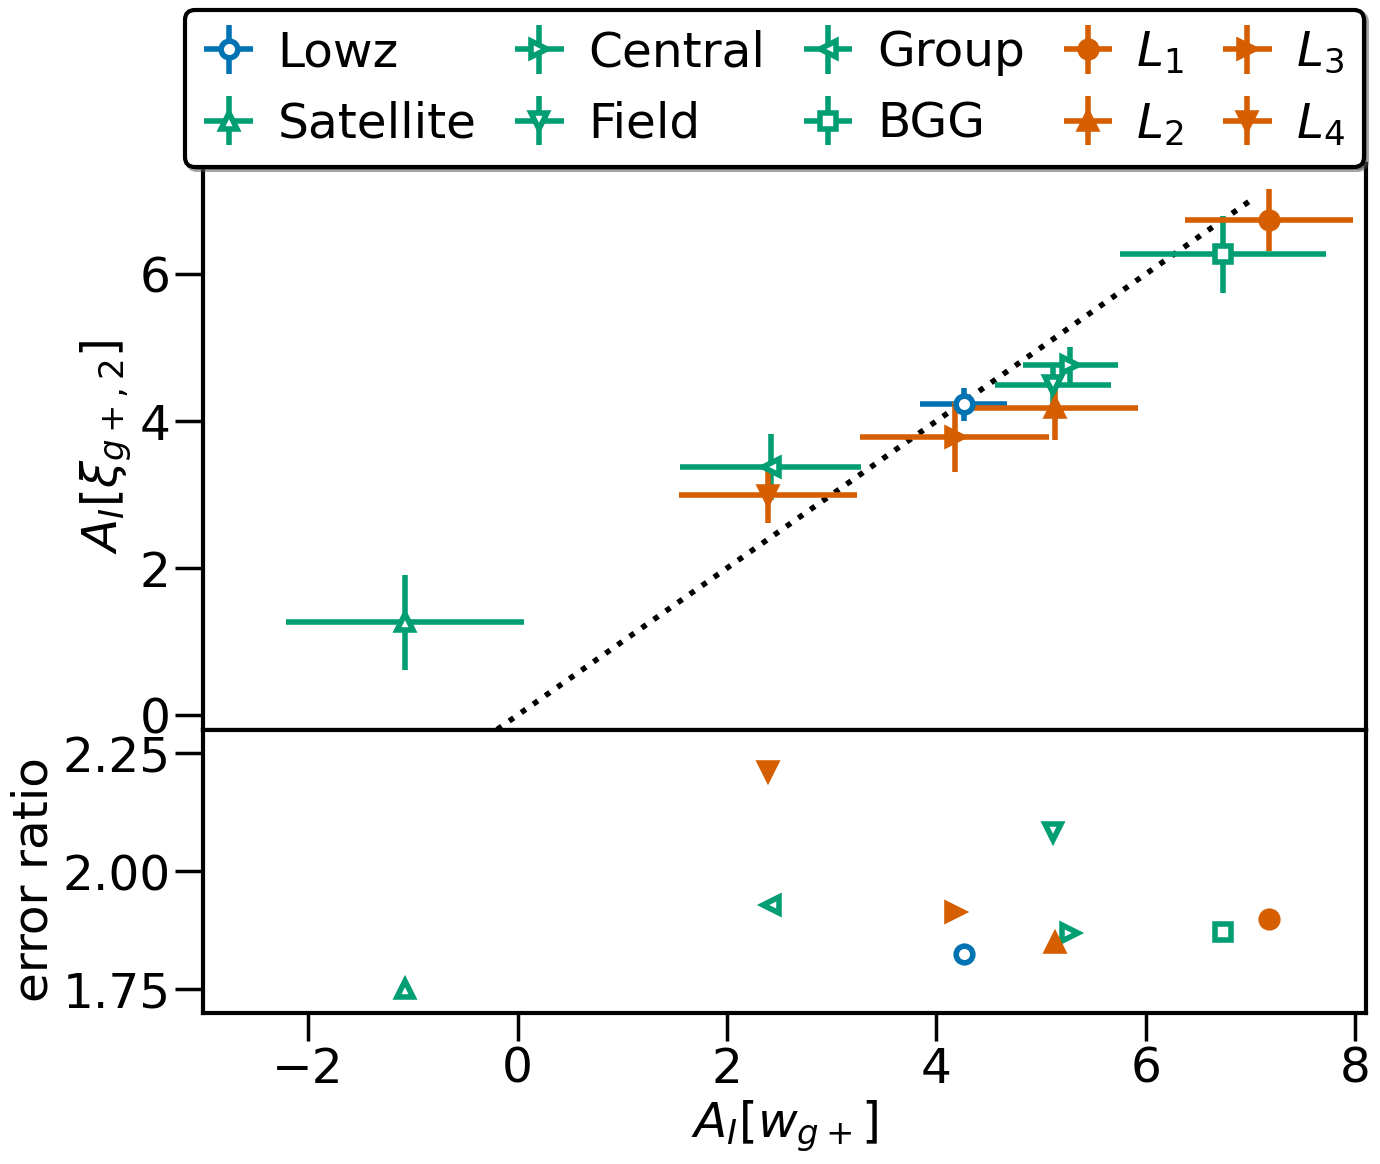

In [232]:
i=0
j=0
fig,axes =subplots(nrows=2, ncols=1, sharex=True, sharey=False,squeeze=True,figsize=(15,11.25),height_ratios=[2,1])
ai_p=axes[0]
air_p=axes[1]
pi=1
ms=12
mfc='white'
mew=4
for samp in ['full']: #w_fits.keys():#shape_samples:
    ai_p.errorbar(w_fits[samp]['params']['jk'][pi],mutipole_fits[samp]['params']['jk'][pi],
            xerr=w_fits[samp]['params']['jk_err'][pi],yerr=mutipole_fits[samp]['params']['jk_err'][pi],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp],ms=ms,mfc=mfc,mew=mew)
    air_p.plot(w_fits[samp]['params']['jk'][pi],
             w_fits[samp]['params']['jk_err'][pi]/mutipole_fits[samp]['params']['jk_err'][pi],
               markers[j%len(markers)],c=colors2[i],ms=ms,mfc=mfc,mew=mew)
    i+=1
    j+=1
i+=1
for samp in ["satellite"]: #w_fits.keys():#shape_samples:
    ai_p.errorbar(w_fits[samp]['params']['jk'][pi],mutipole_fits[samp]['params']['jk'][pi],
            xerr=w_fits[samp]['params']['jk_err'][pi],yerr=mutipole_fits[samp]['params']['jk_err'][pi],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp],ms=ms,mfc=mfc,mew=mew)
    air_p.plot(w_fits[samp]['params']['jk'][pi],
             w_fits[samp]['params']['jk_err'][pi]/mutipole_fits[samp]['params']['jk_err'][pi],
               markers[j%len(markers)],c=colors2[i],ms=ms,mfc=mfc,mew=mew)
    j+=1
# i+=1
for samp in ["central", "field", "group", "bcg"]: #w_fits.keys():#shape_samples:
    ai_p.errorbar(w_fits[samp]['params']['jk'][pi],mutipole_fits[samp]['params']['jk'][pi],
            xerr=w_fits[samp]['params']['jk_err'][pi],yerr=mutipole_fits[samp]['params']['jk_err'][pi],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp],ms=ms,mfc=mfc,mew=mew)
    air_p.plot(w_fits[samp]['params']['jk'][pi],
             w_fits[samp]['params']['jk_err'][pi]/mutipole_fits[samp]['params']['jk_err'][pi],
               markers[j%len(markers)],c=colors2[i],ms=ms,mfc=mfc,mew=mew)
    j+=1
i+=1
mfc=None
for samp in ["lum1", "lum2", "lum3", "lum4"]: #w_fits.keys():#shape_samples:
    ai_p.errorbar(w_fits[samp]['params']['jk'][pi],mutipole_fits[samp]['params']['jk'][pi],
            xerr=w_fits[samp]['params']['jk_err'][pi],yerr=mutipole_fits[samp]['params']['jk_err'][pi],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp],ms=ms,mfc=mfc,mew=mew)
    air_p.plot(w_fits[samp]['params']['jk'][pi],
             w_fits[samp]['params']['jk_err'][pi]/mutipole_fits[samp]['params']['jk_err'][pi],
               markers[j%len(markers)],c=colors2[i],ms=ms,mfc=mfc,mew=mew)
    j+=1
i+=1
xx=np.linspace(-1,7)
air_p.set_ylim(1.7,2.3)
air_p.set_xlim(-3,8.1)
ai_p.set_ylim(-0.2,7.5)
ai_p.plot(xx,xx,c='k',ls=':',zorder=-1)
# ai_p.legend(loc='upper right',bbox_to_anchor=(1.28,1),)
ai_p.legend(loc='upper left',ncol=5,columnspacing=0.8,bbox_to_anchor=(-.02,1.28),borderpad=0.4)
# ai_p.legend(loc='upper left',ncol=2,columnspacing=0.7,#bbox_to_anchor=(-.0,1.28),
#             borderpad=0.3,handletextpad=0.1)
# ai_p.legend(loc='upper left',ncol=5,columnspacing=0.8,bbox_to_anchor=(-.0,1.28),
#             borderpad=0.4,handletextpad=0.15)
air_p.set_xlabel(r'$A_I [w_{g+}]$')
ai_p.set_ylabel(r'$A_I [\xi_{g+,2}]$')
air_p.set_ylabel(r'error ratio ') #$w_{g+} / \xi_{g+,2}$
fname='AI_multipole_wgp.'
savefig(fig_home+fname+fig_format,format=fig_format,bbox_inches='tight')

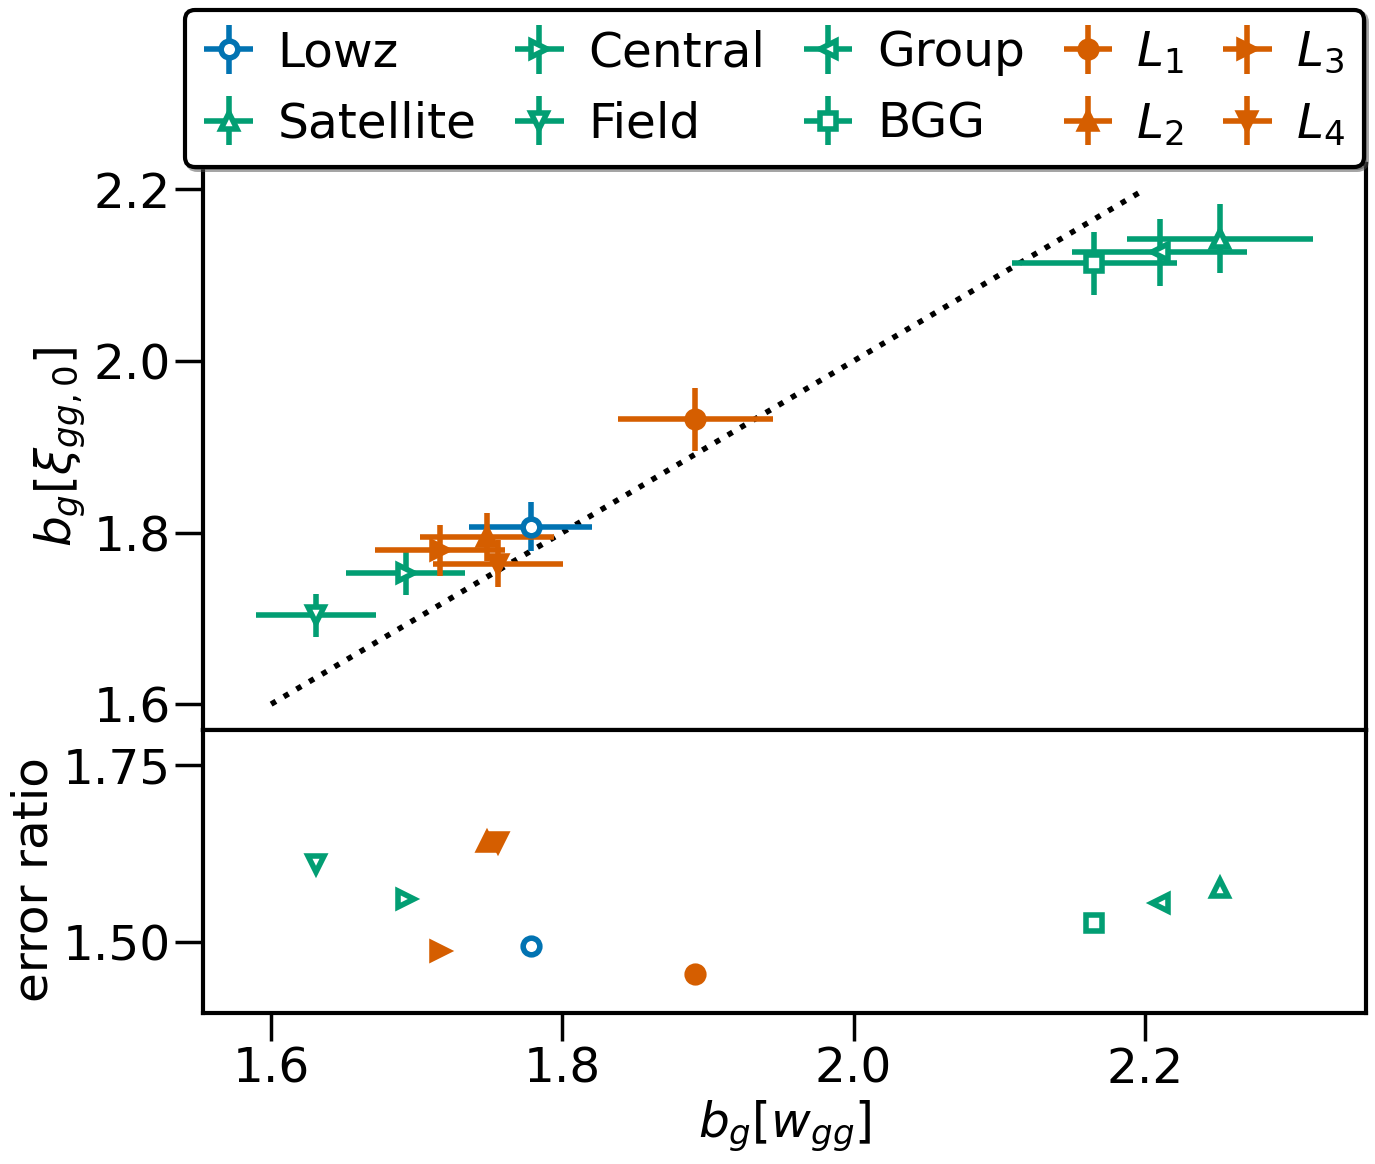

In [231]:
i=0
j=0
fig,axes =subplots(nrows=2, ncols=1, sharex=True, sharey=False,squeeze=True,figsize=(15,11.25),height_ratios=[2,1])
ai_p=axes[0]
air_p=axes[1]
pi=0
ms=12
mfc='white'
mew=4
for samp in ['full']: #w_fits.keys():#shape_samples:
    ai_p.errorbar(w_fits[samp]['params']['jk'][pi],mutipole_fits[samp]['params']['jk'][pi],
            xerr=w_fits[samp]['params']['jk_err'][pi],yerr=mutipole_fits[samp]['params']['jk_err'][pi],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp],ms=ms,mfc=mfc,mew=mew)
    air_p.plot(w_fits[samp]['params']['jk'][pi],
             w_fits[samp]['params']['jk_err'][pi]/mutipole_fits[samp]['params']['jk_err'][pi],
               markers[j%len(markers)],c=colors2[i],ms=ms,mfc=mfc,mew=mew)
    i+=1
    j+=1
i+=1
for samp in ["satellite"]: #w_fits.keys():#shape_samples:
    ai_p.errorbar(w_fits[samp]['params']['jk'][pi],mutipole_fits[samp]['params']['jk'][pi],
            xerr=w_fits[samp]['params']['jk_err'][pi],yerr=mutipole_fits[samp]['params']['jk_err'][pi],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp],ms=ms,mfc=mfc,mew=mew)
    air_p.plot(w_fits[samp]['params']['jk'][pi],
             w_fits[samp]['params']['jk_err'][pi]/mutipole_fits[samp]['params']['jk_err'][pi],
               markers[j%len(markers)],c=colors2[i],ms=ms,mfc=mfc,mew=mew)
    j+=1
# i+=1
for samp in ["central", "field", "group", "bcg"]: #w_fits.keys():#shape_samples:
    ai_p.errorbar(w_fits[samp]['params']['jk'][pi],mutipole_fits[samp]['params']['jk'][pi],
            xerr=w_fits[samp]['params']['jk_err'][pi],yerr=mutipole_fits[samp]['params']['jk_err'][pi],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp],ms=ms,mfc=mfc,mew=mew)
    air_p.plot(w_fits[samp]['params']['jk'][pi],
             w_fits[samp]['params']['jk_err'][pi]/mutipole_fits[samp]['params']['jk_err'][pi],
               markers[j%len(markers)],c=colors2[i],ms=ms,mfc=mfc,mew=mew)
    j+=1
i+=1
mfc=None
for samp in ["lum1", "lum2", "lum3", "lum4"]: #w_fits.keys():#shape_samples:
    ai_p.errorbar(w_fits[samp]['params']['jk'][pi],mutipole_fits[samp]['params']['jk'][pi],
            xerr=w_fits[samp]['params']['jk_err'][pi],yerr=mutipole_fits[samp]['params']['jk_err'][pi],c=colors2[i],
             fmt=markers[j%len(markers)],label=samp_labels[samp],ms=ms,mfc=mfc,mew=mew)
    air_p.plot(w_fits[samp]['params']['jk'][pi],
             w_fits[samp]['params']['jk_err'][pi]/mutipole_fits[samp]['params']['jk_err'][pi],
               markers[j%len(markers)],c=colors2[i],ms=ms,mfc=mfc,mew=mew)
    j+=1
i+=1
xx=np.linspace(1.6,2.2)
air_p.set_ylim(1.4,1.8)
ai_p.plot(xx,xx,c='k',ls=':',zorder=-1)
# ai_p.legend(loc='upper right',bbox_to_anchor=(1.28,1),)
ai_p.legend(loc='upper left',ncol=5,columnspacing=0.8,bbox_to_anchor=(-.02,1.28),borderpad=0.4)
# ai_p.legend(loc='lower right',ncol=2,columnspacing=0.8,#bbox_to_anchor=(-.0,1.28),
#             borderpad=0.4,handletextpad=0.12)
air_p.set_xlabel(r'$b_g [w_{gg}]$')
ai_p.set_ylabel(r'$b_g [\xi_{gg,0}]$')
air_p.set_ylabel(r'error ratio ') #$w_{g+} / \xi_{g+,2}$
fname='bg_multipole_wgg.'
savefig(fig_home+fname+fig_format,format=fig_format,bbox_inches='tight')

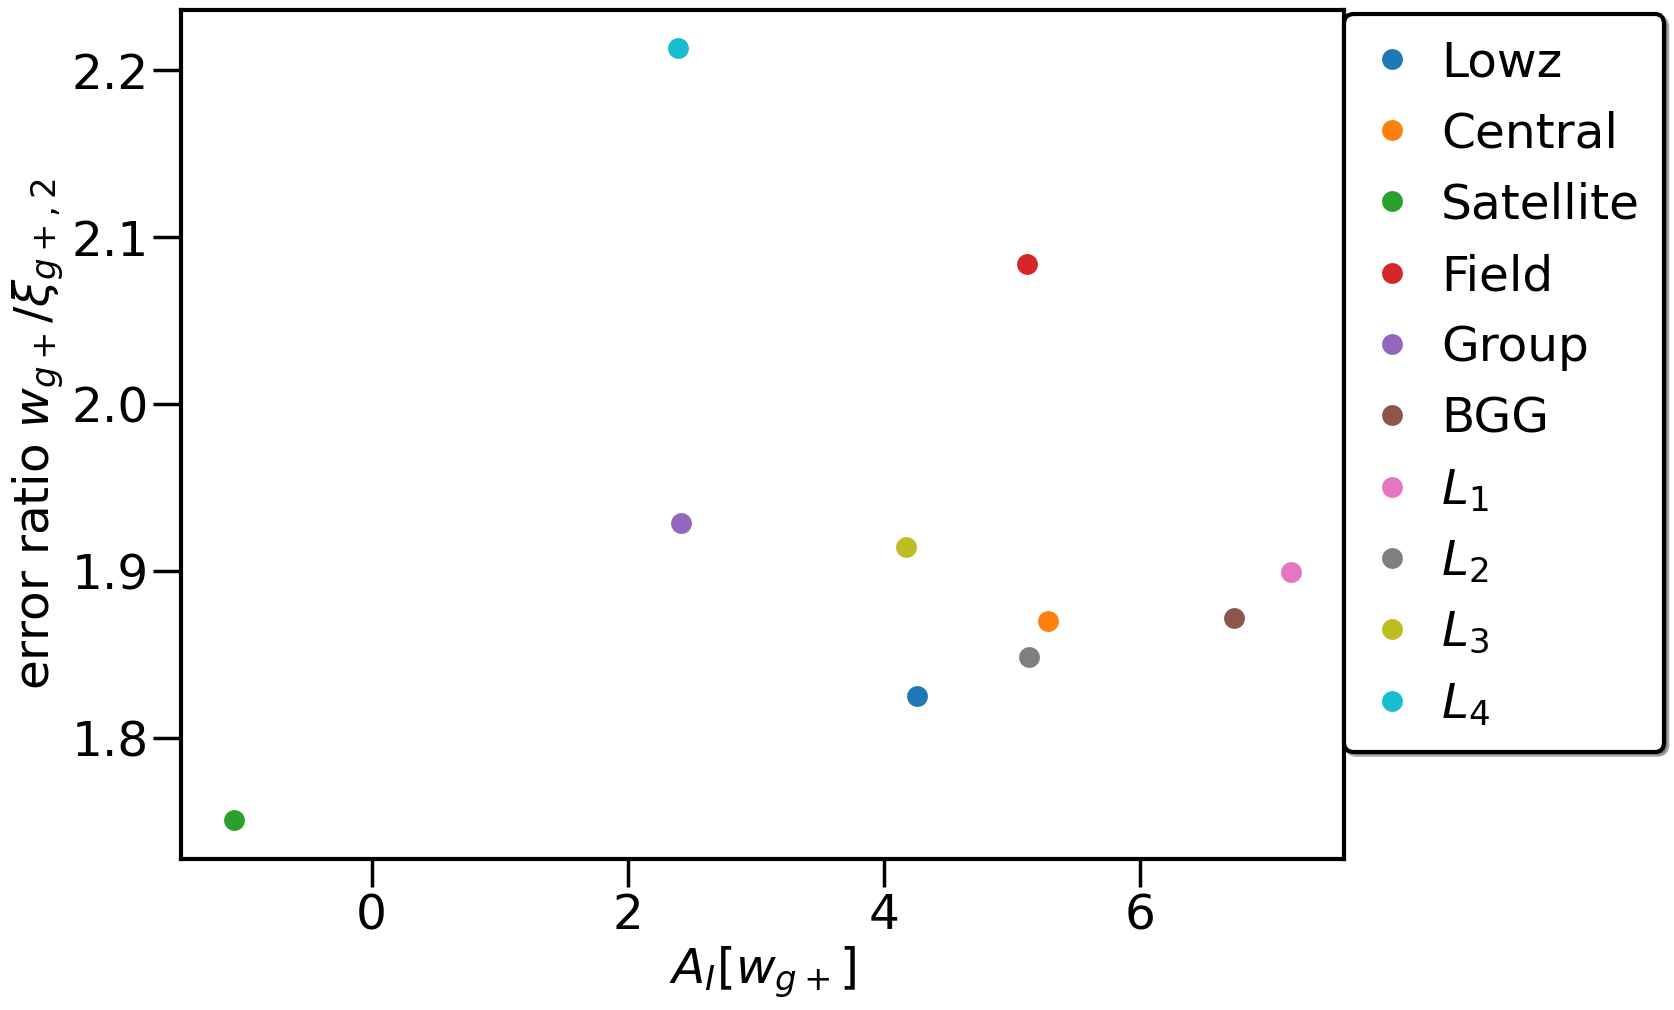

In [87]:
i=0
for samp in w_fits.keys():#shape_samples:
#     plot(w_fits[samp]['params']['jk_err'][1],mutipole_fits[samp]['params']['jk_err'][1],'o',label=samp_labels[samp])
    plot(w_fits[samp]['params']['jk'][1],w_fits[samp]['params']['jk_err'][1]/mutipole_fits[samp]['params']['jk_err'][1],'o',
         label=samp_labels[samp],ms=15)
    i+=1
# xx=np.linspace(0,1)
# plot(xx,xx,c='k',ls=':',zorder=-1,label='x=y')
legend(loc='upper right',bbox_to_anchor=(1.28,1),)
xlabel(r'$A_I [w_{g+}]$')
ylabel(r'error ratio $w_{g+} / \xi_{g+,2}$')
fname='AI_multipole_wgp_ratio.'
savefig(fig_home+fname+fig_format,format=fig_format,bbox_inches='tight')

Text(0, 0.5, 'error ratio $w_{gg} / \\xi_{gg,0}$')

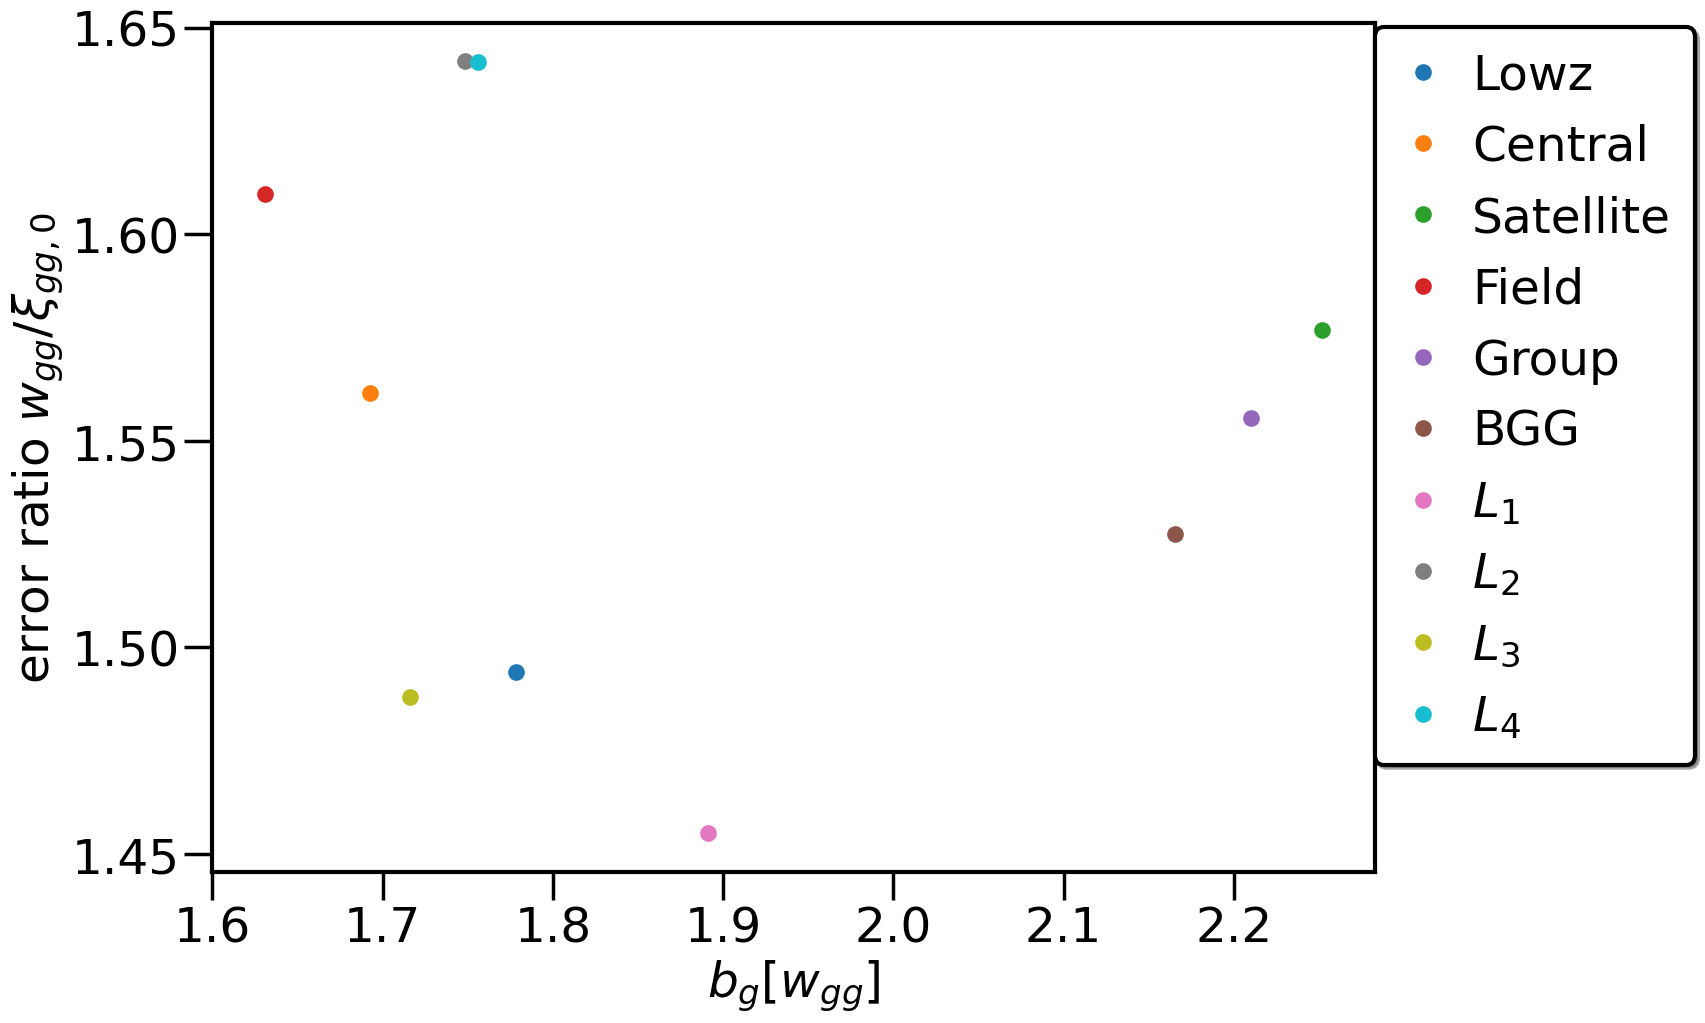

In [88]:
i=0
for samp in w_fits.keys():#shape_samples:
#     plot(w_fits[samp]['params']['jk_err'][0],mutipole_fits[samp]['params']['jk_err'][0],'o',label=samp_labels[samp])
    plot(w_fits[samp]['params']['jk'][0],w_fits[samp]['params']['jk_err'][0]/mutipole_fits[samp]['params']['jk_err'][0],'o',label=samp_labels[samp])
    i+=1
# xx=np.linspace(0,.1)
# plot(xx,xx,c='k',ls=':',zorder=-1,label='x=y')
legend(loc='upper right',bbox_to_anchor=(1.28,1),)
xlabel(r'$b_g [w_{gg}]$')
ylabel(r'error ratio $w_{gg} / \xi_{gg,0}$')

[]

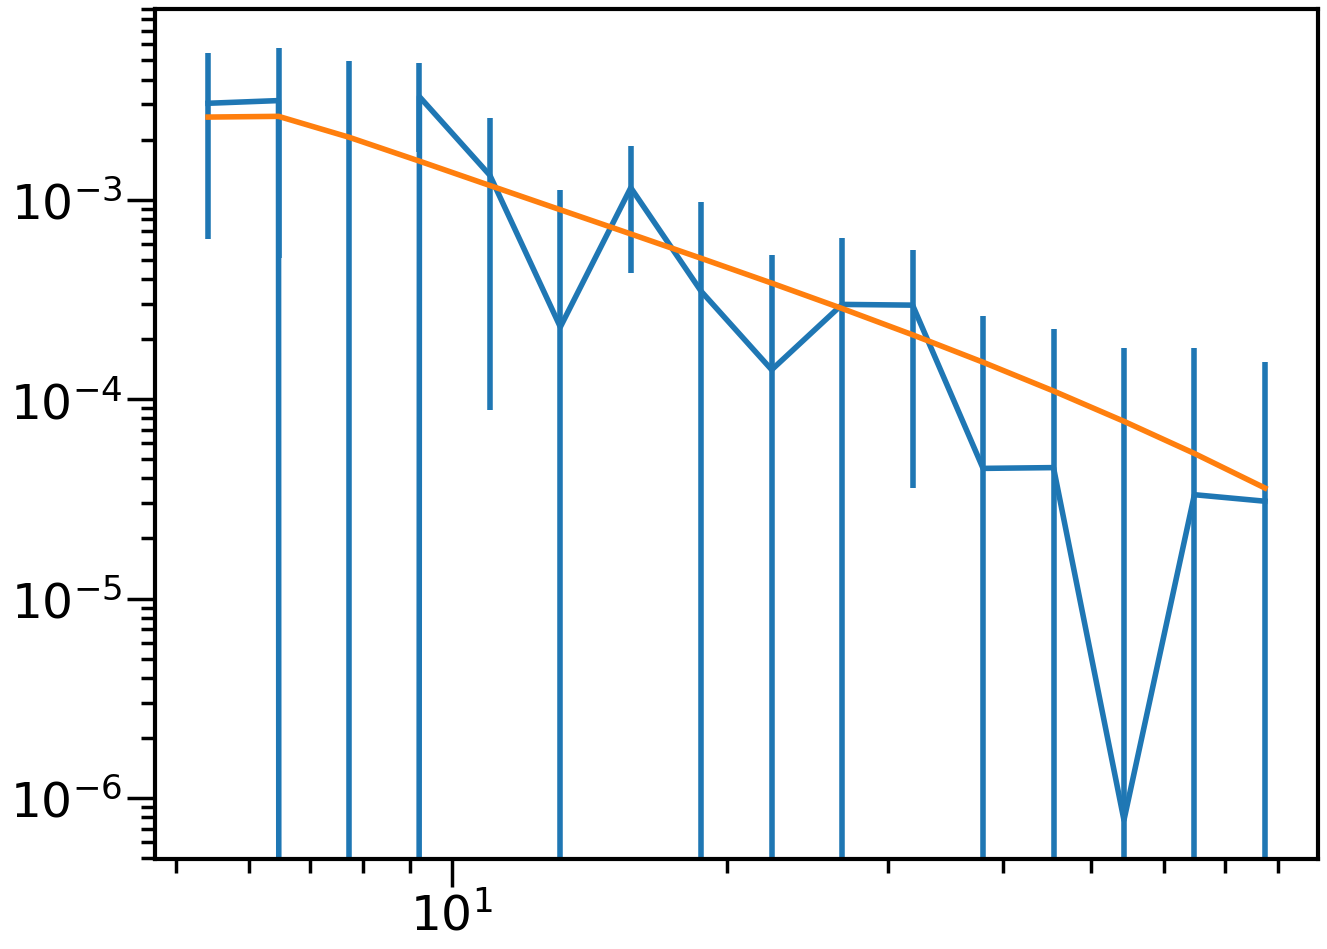

In [89]:
samp='satellite'
errorbar(mutipole_fits[samp]['m_gm']['r'],mutipole_fits[samp]['m_gm'][2]['jk'],mutipole_fits[samp]['m_gm'][2]['jk_err'])
errorbar(mutipole_fits[samp]['m_gm']['r'],
         mutipole_fits[samp]['wgp_model']*mutipole_fits[samp]['params']['jk'][0]*mutipole_fits[samp]['params']['jk'][1])
loglog()

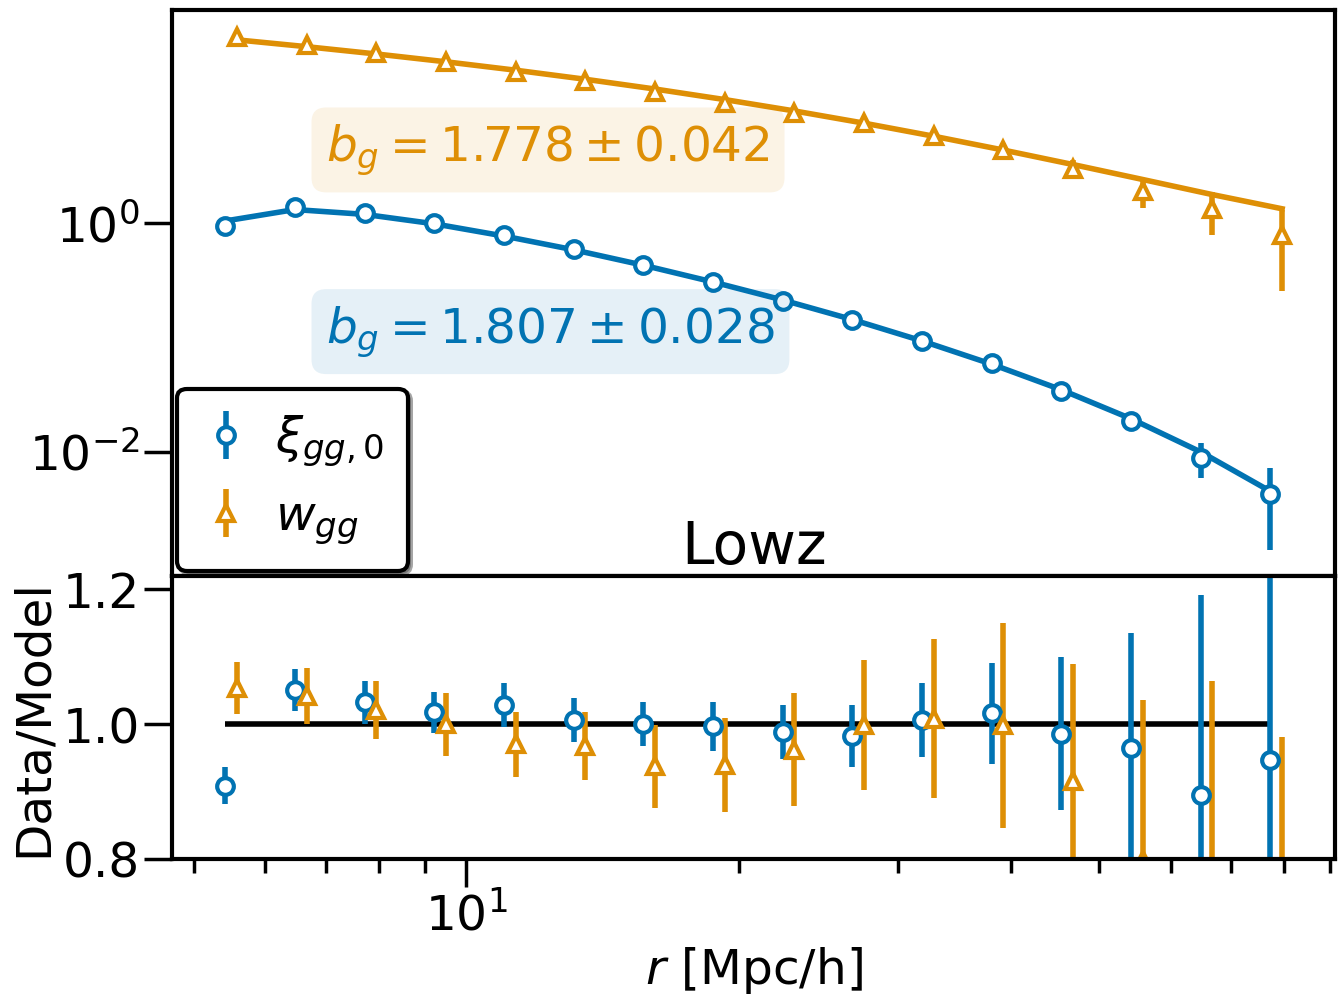

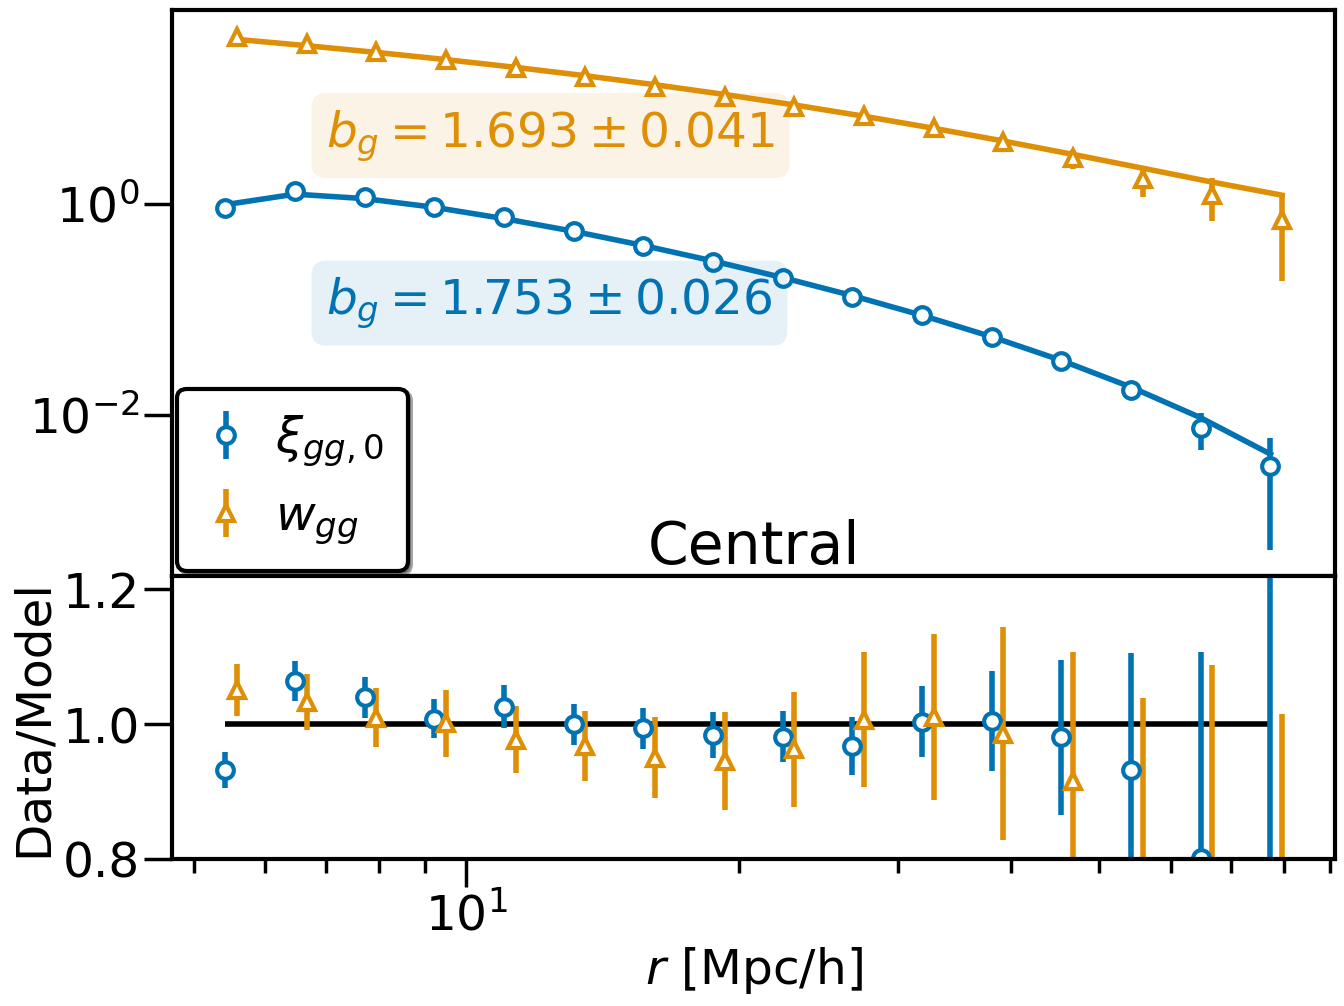

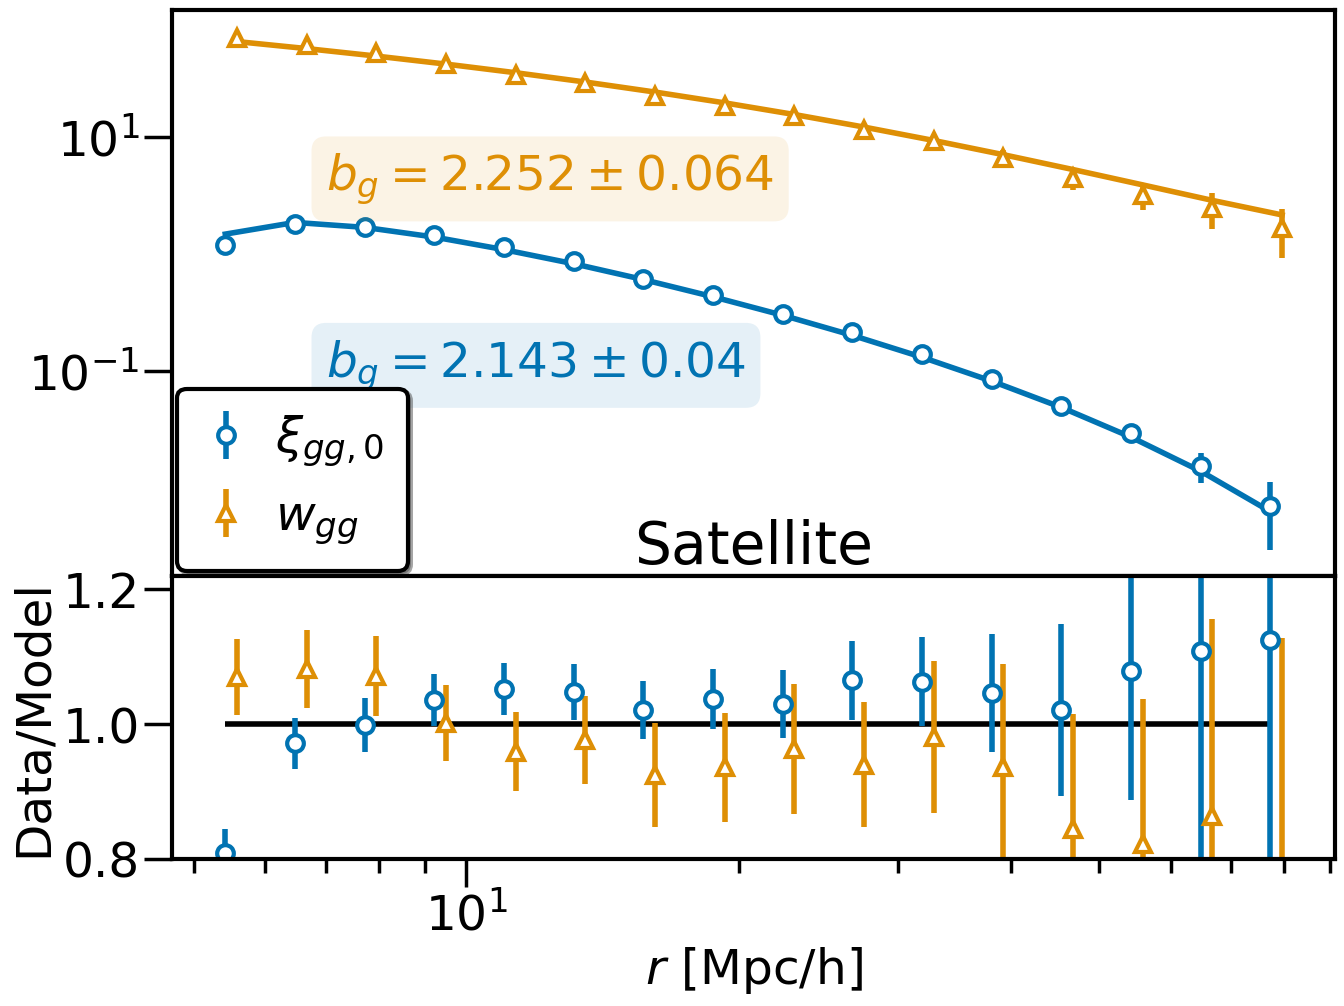

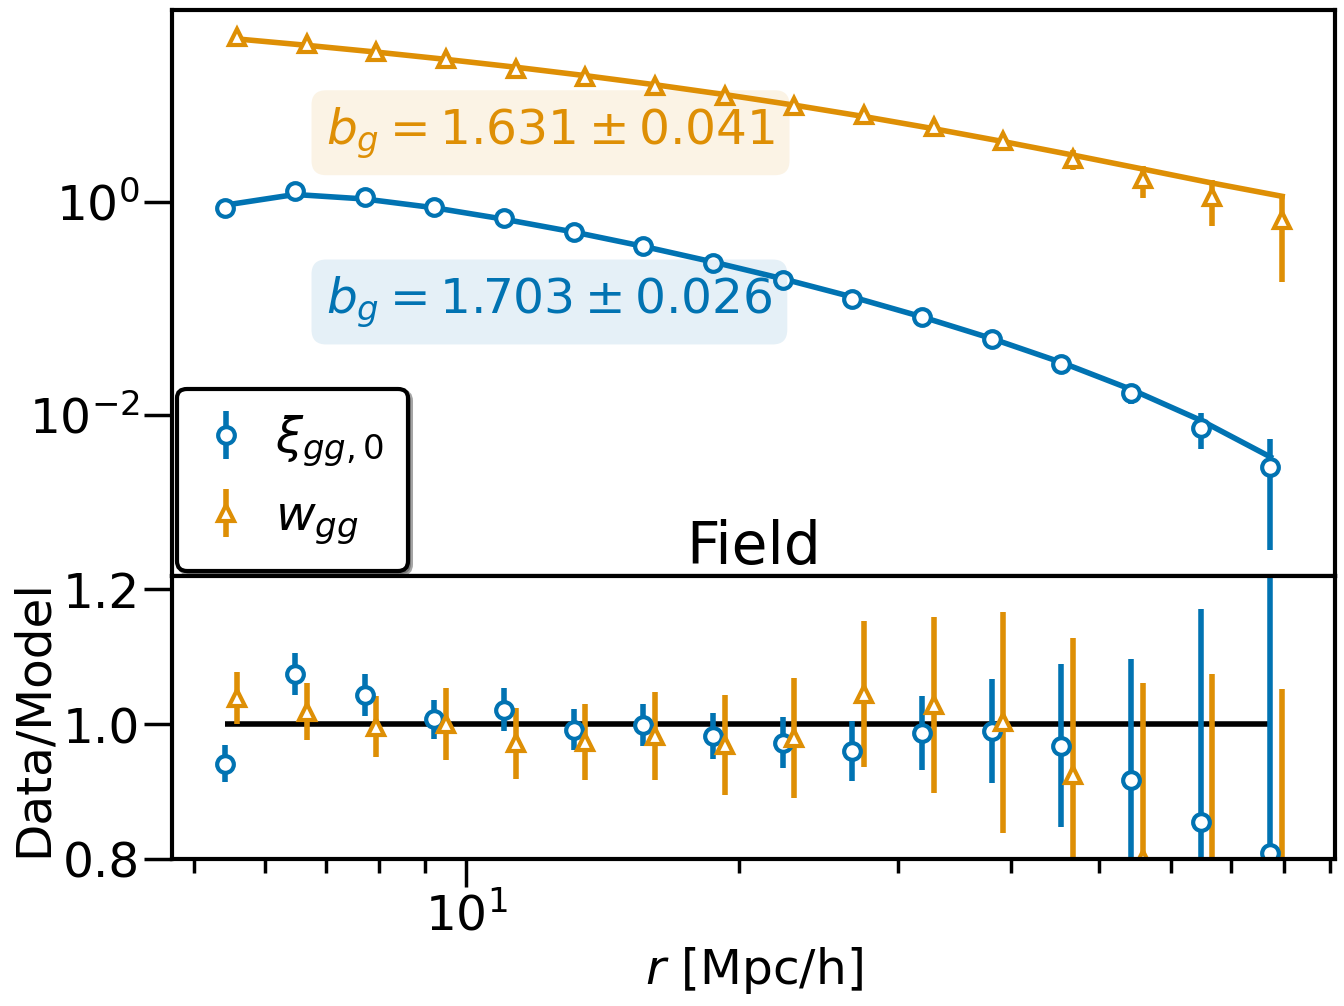

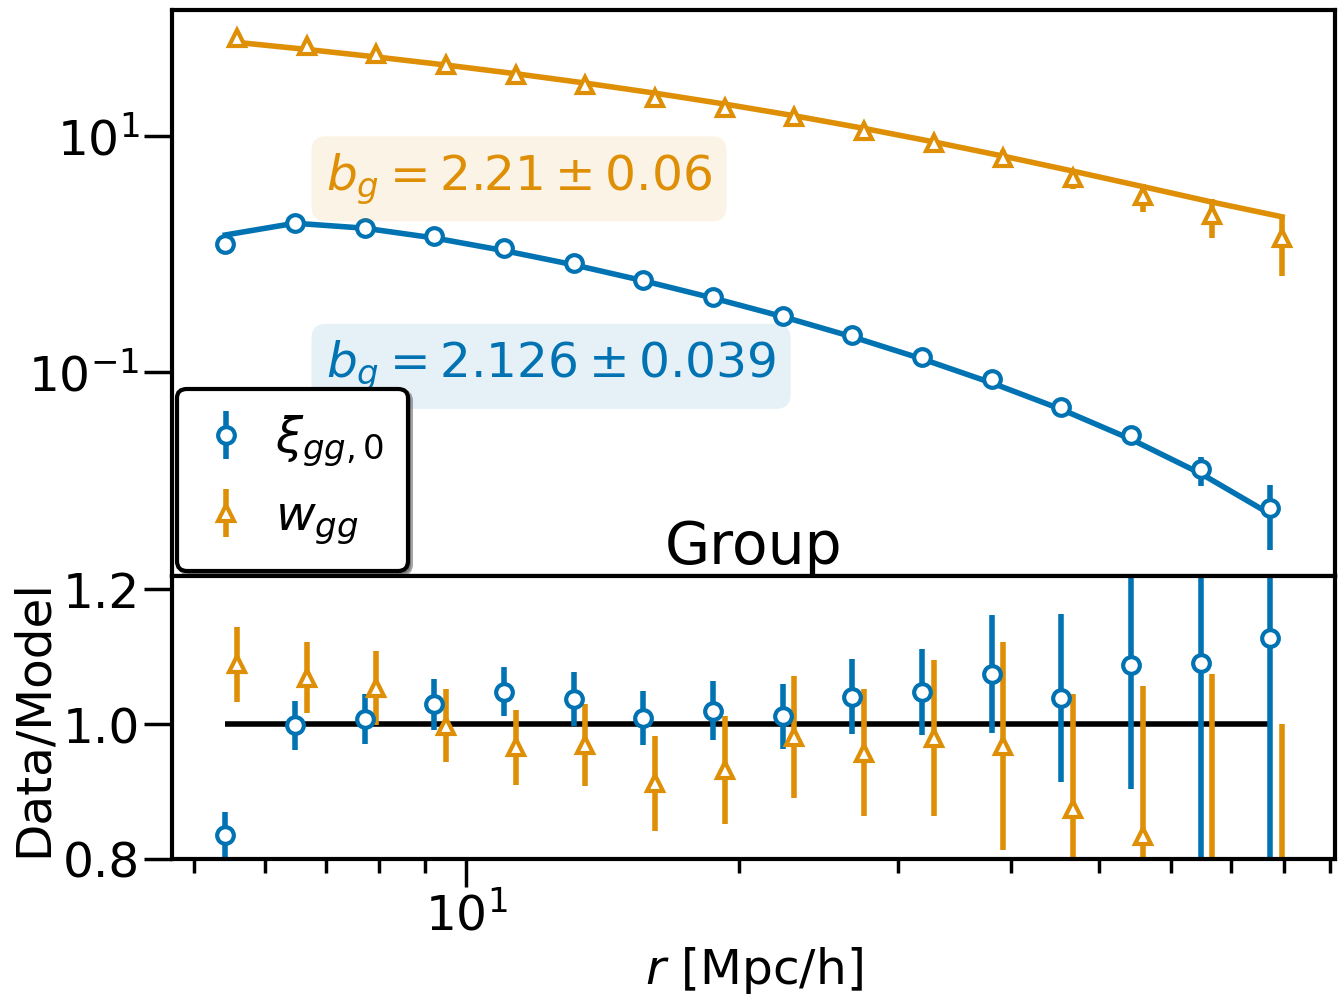

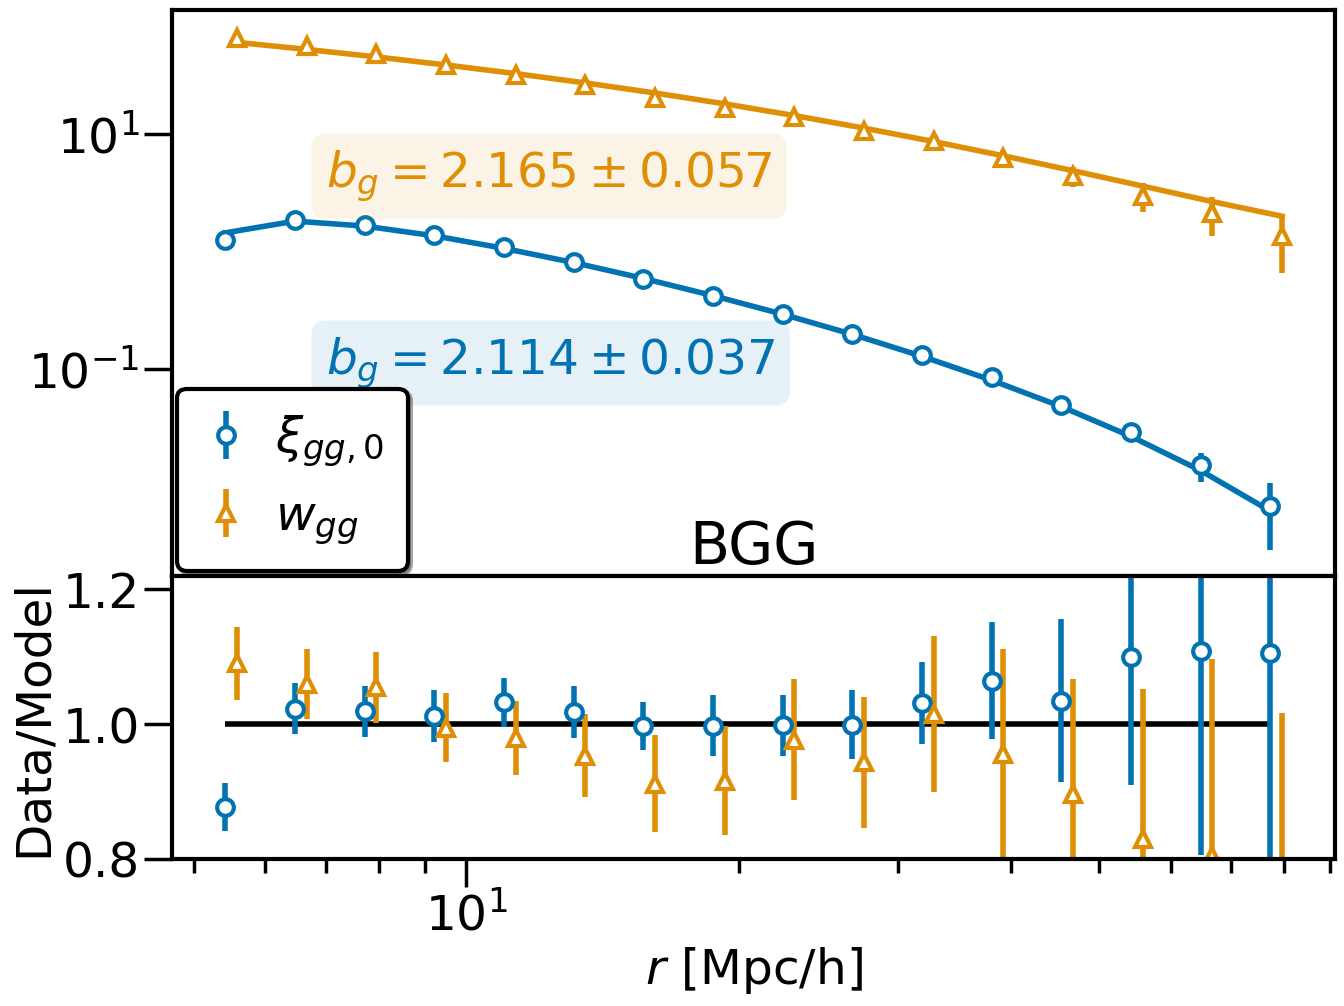

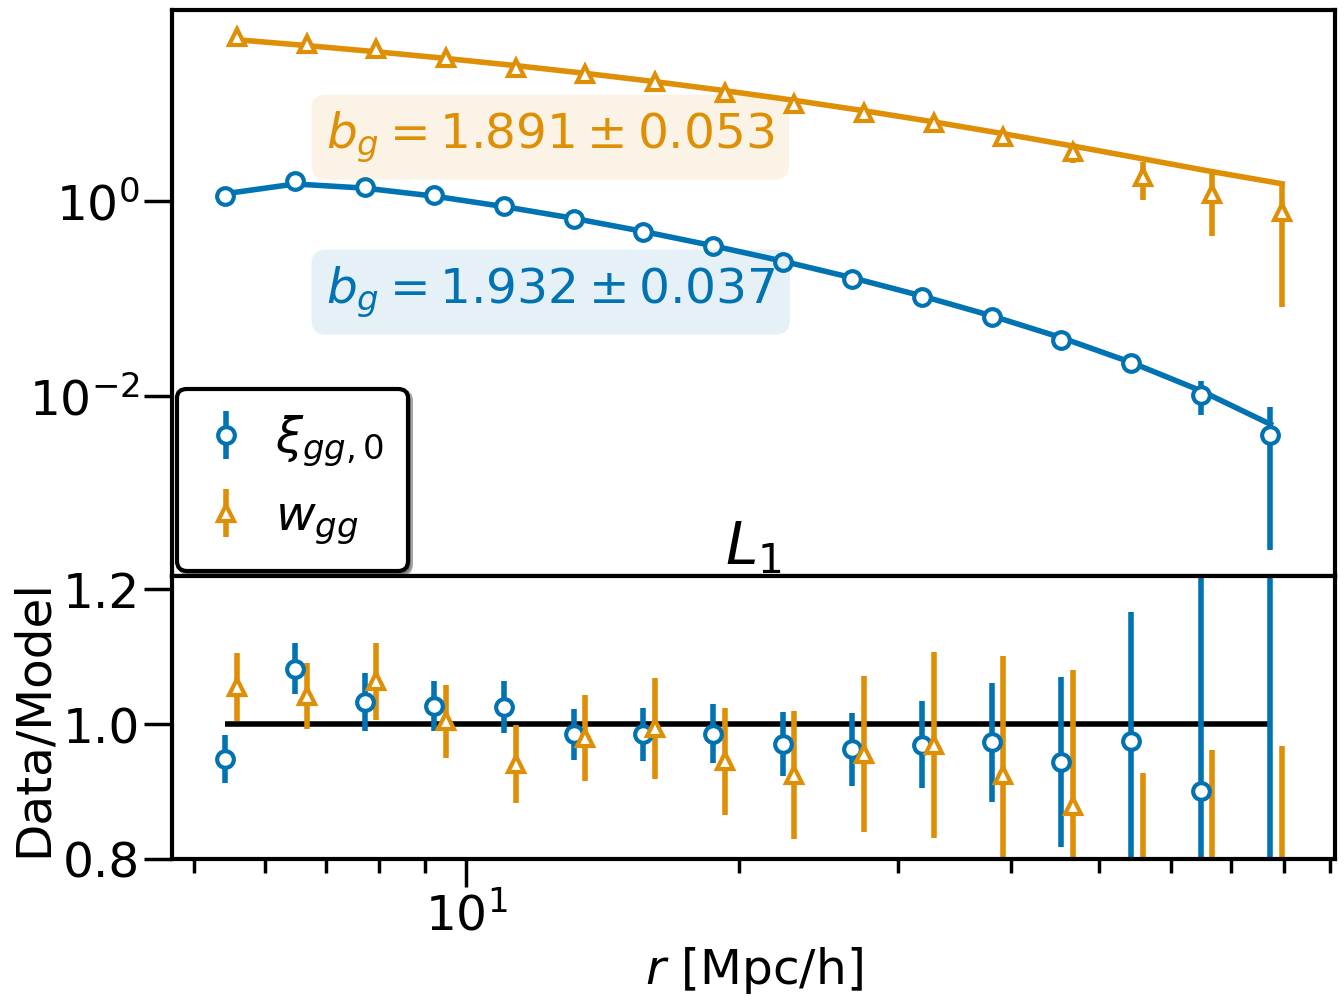

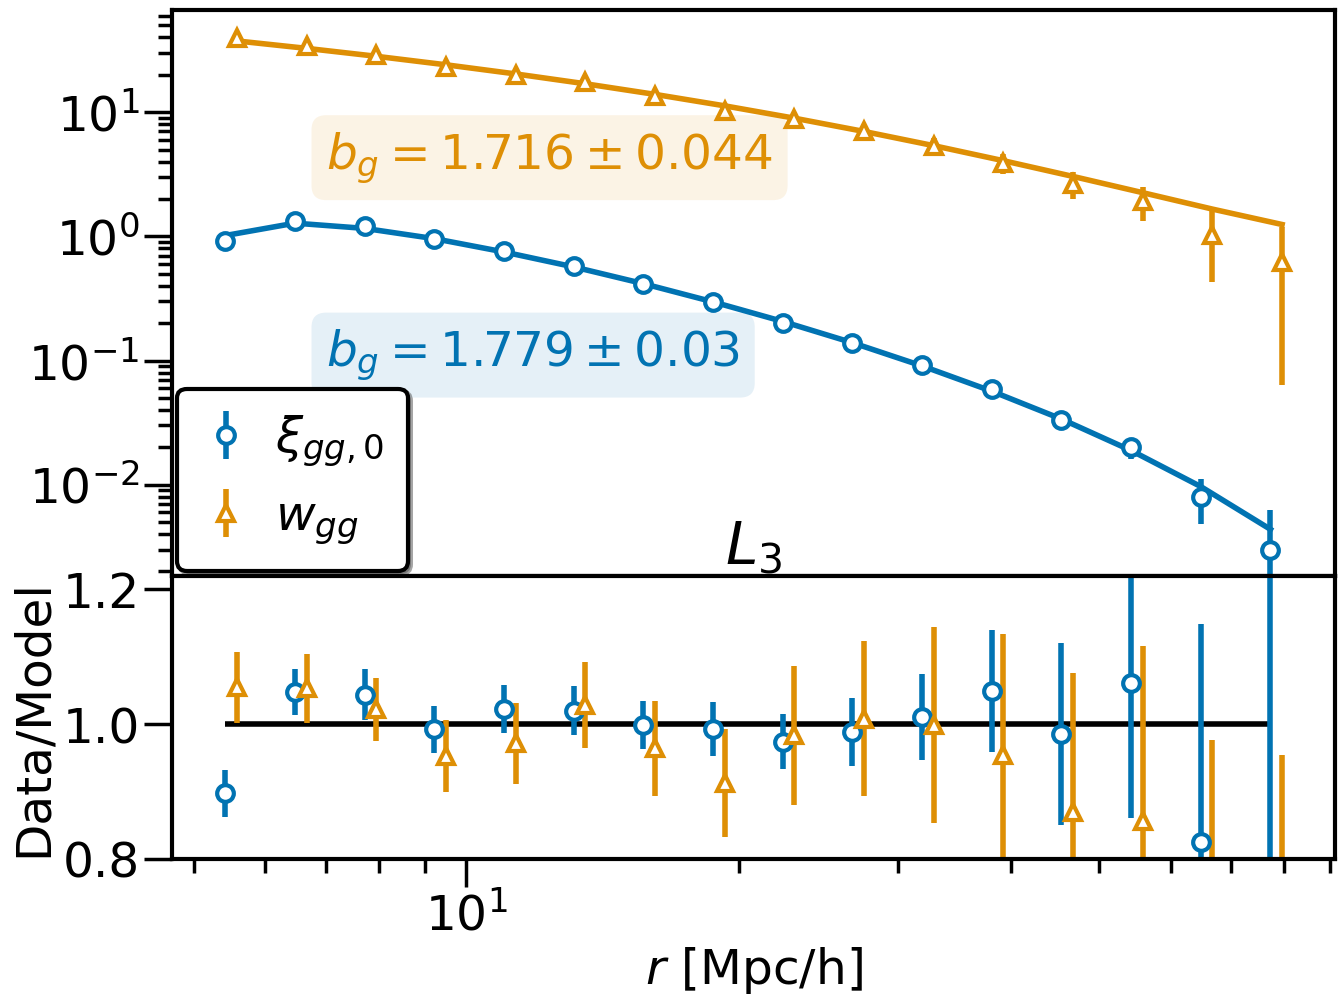

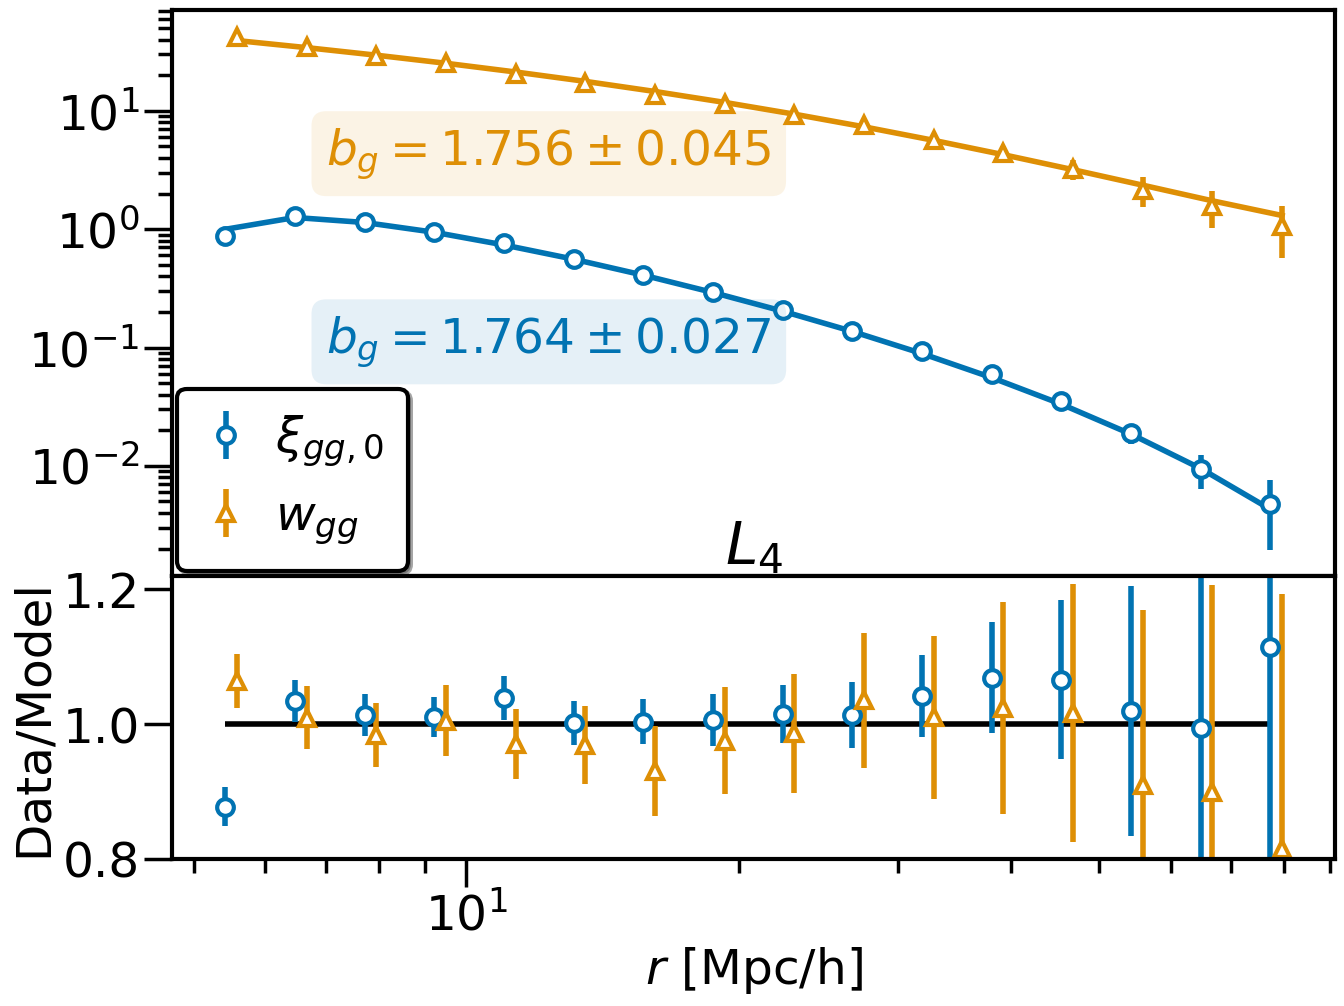

In [150]:
samp='satellite'
for samp in mutipole_fits.keys():
# for _ in range(1):
    fig,axes =subplots(nrows=2, ncols=1, sharex=True, sharey=False,squeeze=True,figsize=(15,11.25),height_ratios=[2,1])
    ai_p=axes[0]
    air_p=axes[1]
    ms=12
    mfc='white'
    mew=3
    i=0
    j=0
    ai_p.errorbar(mutipole_fits[samp]['m_gg']['r'],mutipole_fits[samp]['m_gg'][0]['jk'],
                  mutipole_fits[samp]['m_gg'][0]['jk_err'],label=r'$\xi_{gg,0}$', #samp_labels[samp],
                 c=colors2[i], fmt=markers[j%len(markers)],ms=ms,mfc=mfc,mew=mew)

    wgg_m=mutipole_fits[samp]['wgg_model']*mutipole_fits[samp]['params']['jk'][0]*mutipole_fits[samp]['params']['jk'][0]

    ai_p.plot(mutipole_fits[samp]['m_gg']['r'],wgg_m,c=colors2[i])

    air_p.errorbar(mutipole_fits[samp]['m_gg']['r'],
             mutipole_fits[samp]['m_gg'][0]['jk']/wgg_m,mutipole_fits[samp]['m_gg'][0]['jk_err']/wgg_m,
                  c=colors2[i], fmt=markers[j%len(markers)],ms=ms,mfc=mfc,mew=mew)
    
    n_around=3
    b_label='$b_g='+str(np.around(mutipole_fits[samp]['params']['jk'][0],n_around))
    b_label+='\pm'
    b_label+=str(np.around(mutipole_fits[samp]['params']['jk_err'][0],n_around))+'$'
    t=ai_p.text(x=7,y=0.09,s=b_label,color=colors2[i])
    t.set_bbox(dict(facecolor=colors2[i], alpha=0.1, edgecolor=colors2[i],boxstyle='Round',lw=0))
    
    i+=1
    j+=1
    x_f=1.03
    ai_p.errorbar(w_fits[samp]['m_gg']['r']*x_f,w_fits[samp]['m_gg'][0]['jk'],
                  w_fits[samp]['m_gg'][0]['jk_err'],label=r'$w_{gg}$',#samp_labels[samp],
                 c=colors2[i], fmt=markers[j%len(markers)],ms=ms,mfc=mfc,mew=mew)
    
    wgg_m=w_fits[samp]['wgg_model']*w_fits[samp]['params']['jk'][0]*w_fits[samp]['params']['jk'][0]

    ai_p.plot(w_fits[samp]['m_gg']['r']*x_f,wgg_m,c=colors2[i])

    air_p.errorbar(w_fits[samp]['m_gg']['r']*x_f,
             w_fits[samp]['m_gg'][0]['jk']/wgg_m,w_fits[samp]['m_gg'][0]['jk_err']/wgg_m,
                  c=colors2[i], fmt=markers[j%len(markers)],ms=ms,mfc=mfc,mew=mew)
    
    b_label='$b_g='+str(np.around(w_fits[samp]['params']['jk'][0],n_around))
    b_label+='\pm'
    b_label+=str(np.around(w_fits[samp]['params']['jk_err'][0],n_around))+'$'
    t=ai_p.text(x=7,y=3.5,s=b_label,color=colors2[i])
    t.set_bbox(dict(facecolor=colors2[i], alpha=0.1, edgecolor=colors2[i],boxstyle='Round',lw=0))
    
    air_p.hlines(1,mutipole_fits[samp]['m_gg']['r'].min(),mutipole_fits[samp]['m_gg']['r'].max(),color='k',zorder=-10)
    ai_p.loglog()
    ai_p.legend()
    air_p.set_ylim(0.8,1.22)
    air_p.set_xlabel(r'$r$ [Mpc/h]')
    air_p.set_title(samp_labels[samp])
#     ai_p.set_ylabel(r'$\xi_{gg,0}$')
    air_p.set_ylabel(r'Data/Model')
    fname='wgg_xigg_monopole_fit_'+samp+'.'
    savefig(fig_home+fname+fig_format,format=fig_format,bbox_inches='tight')


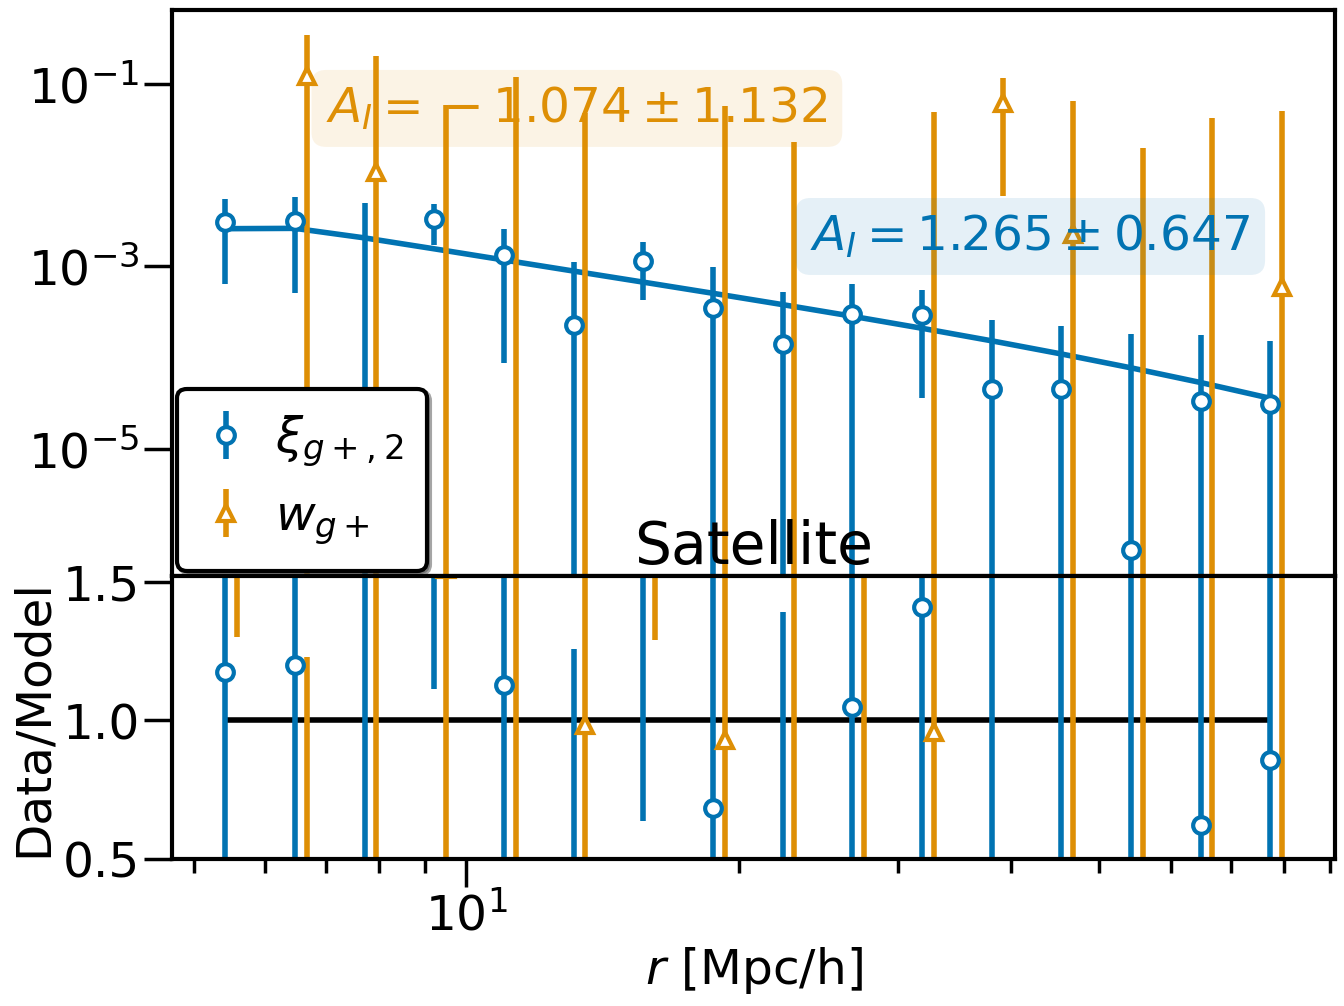

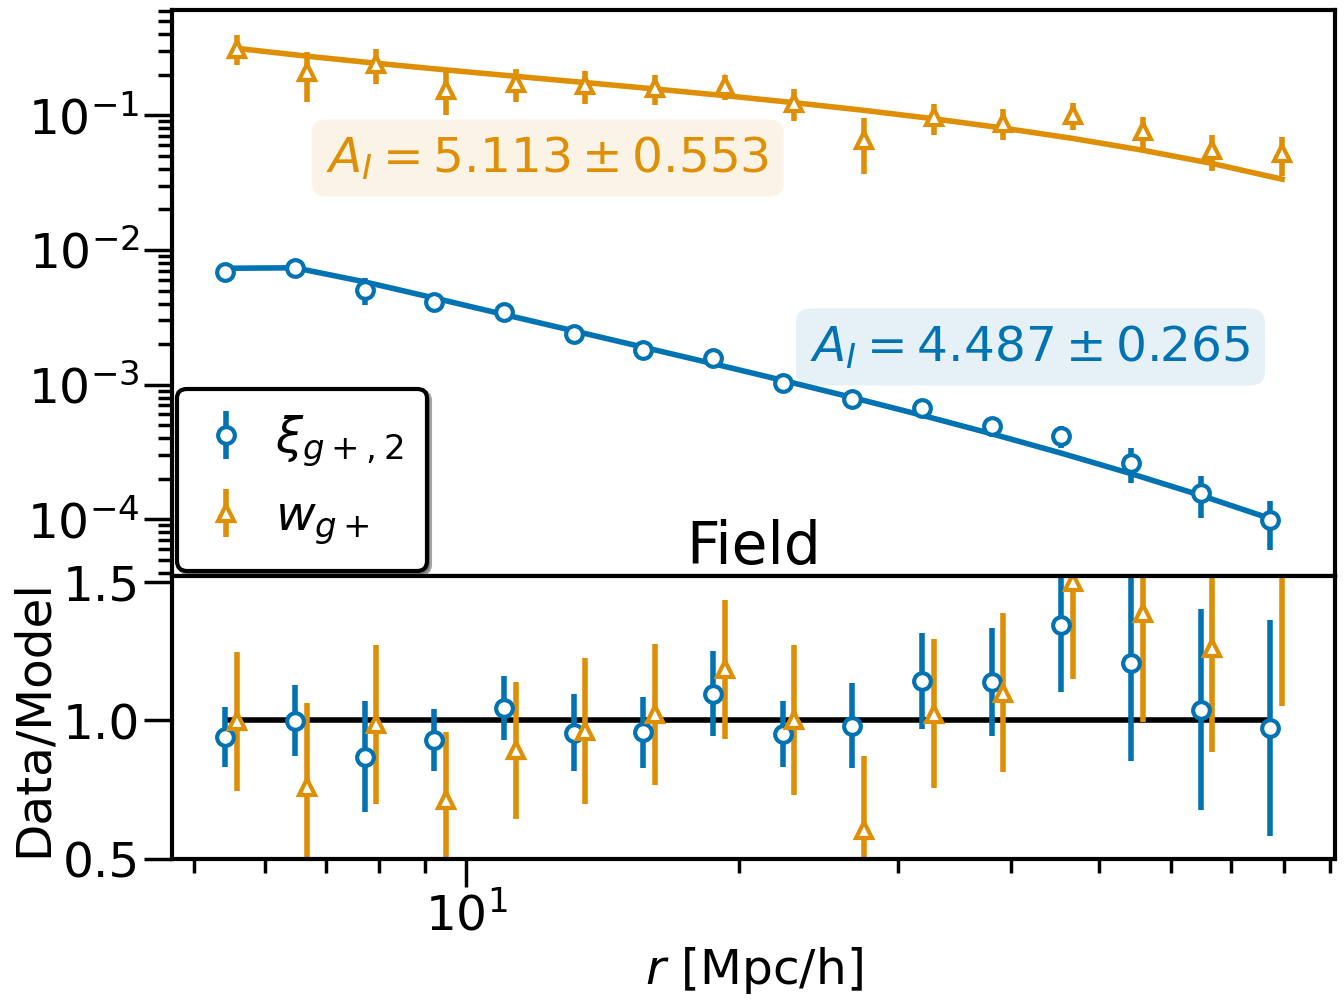

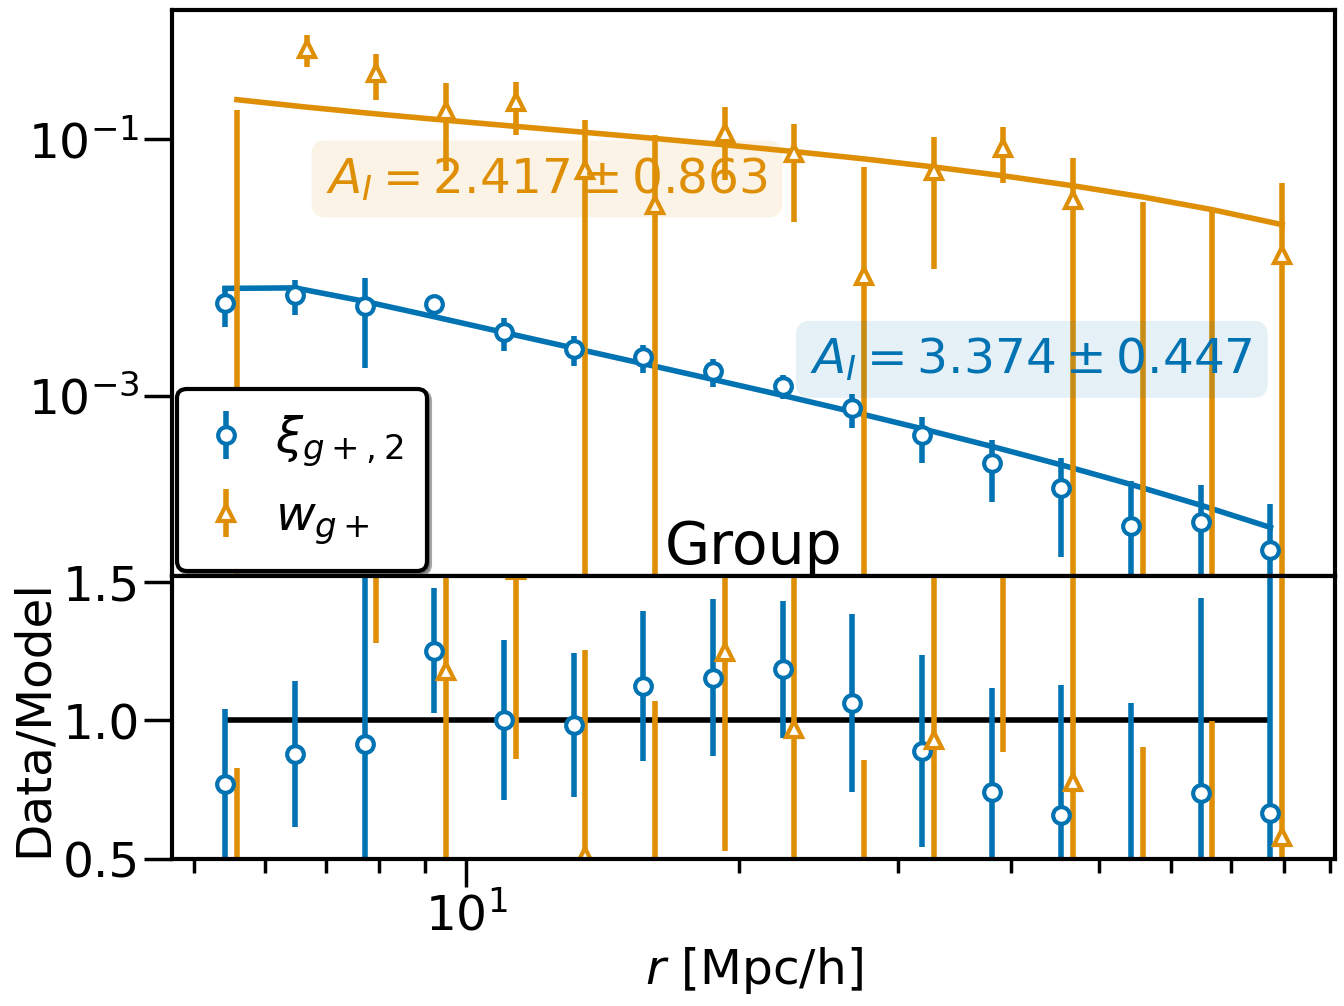

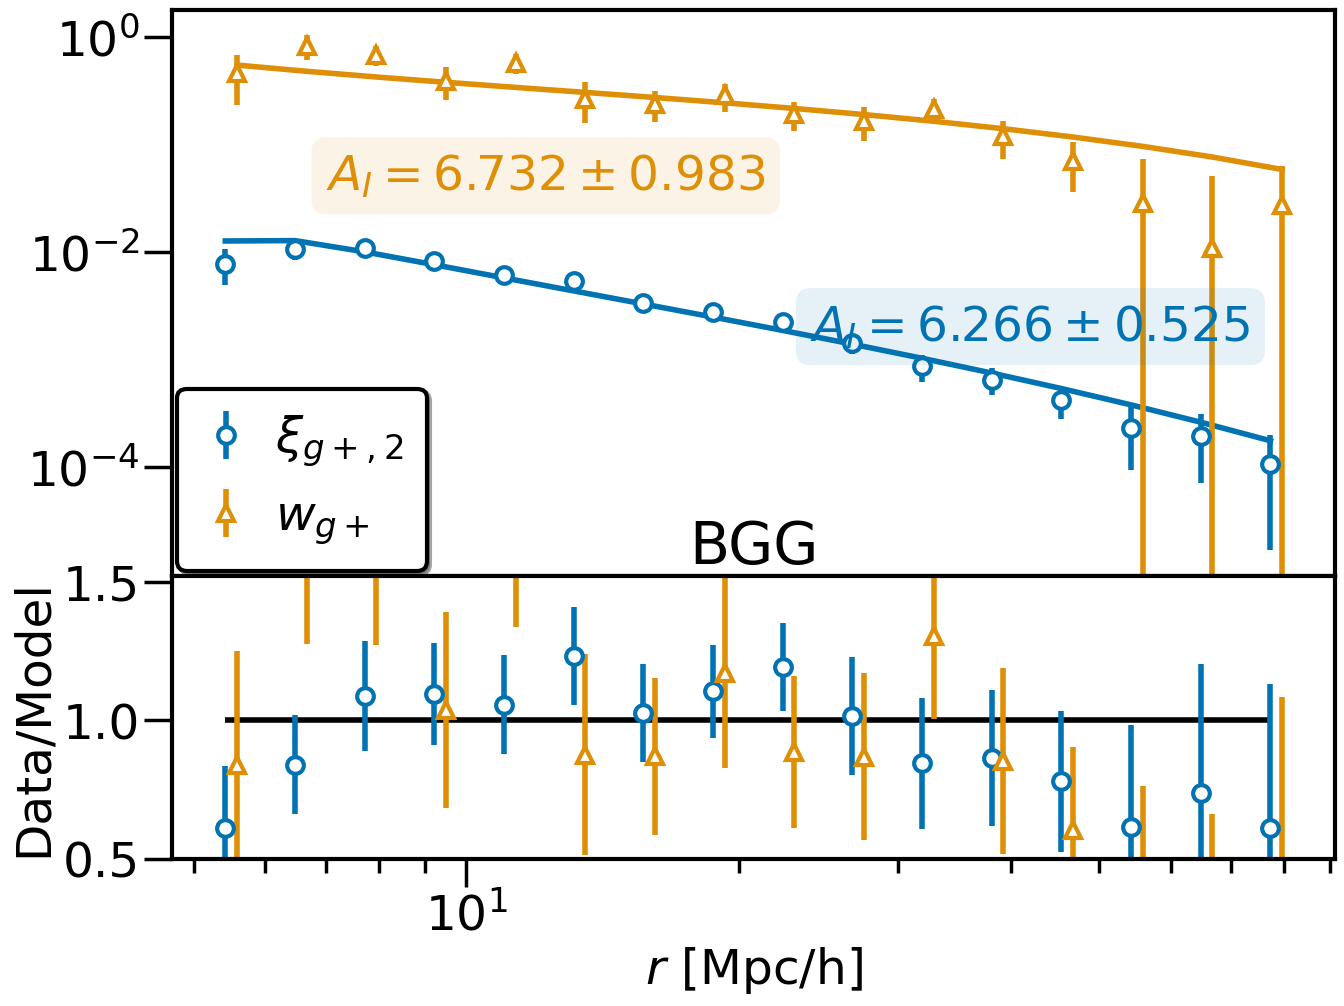

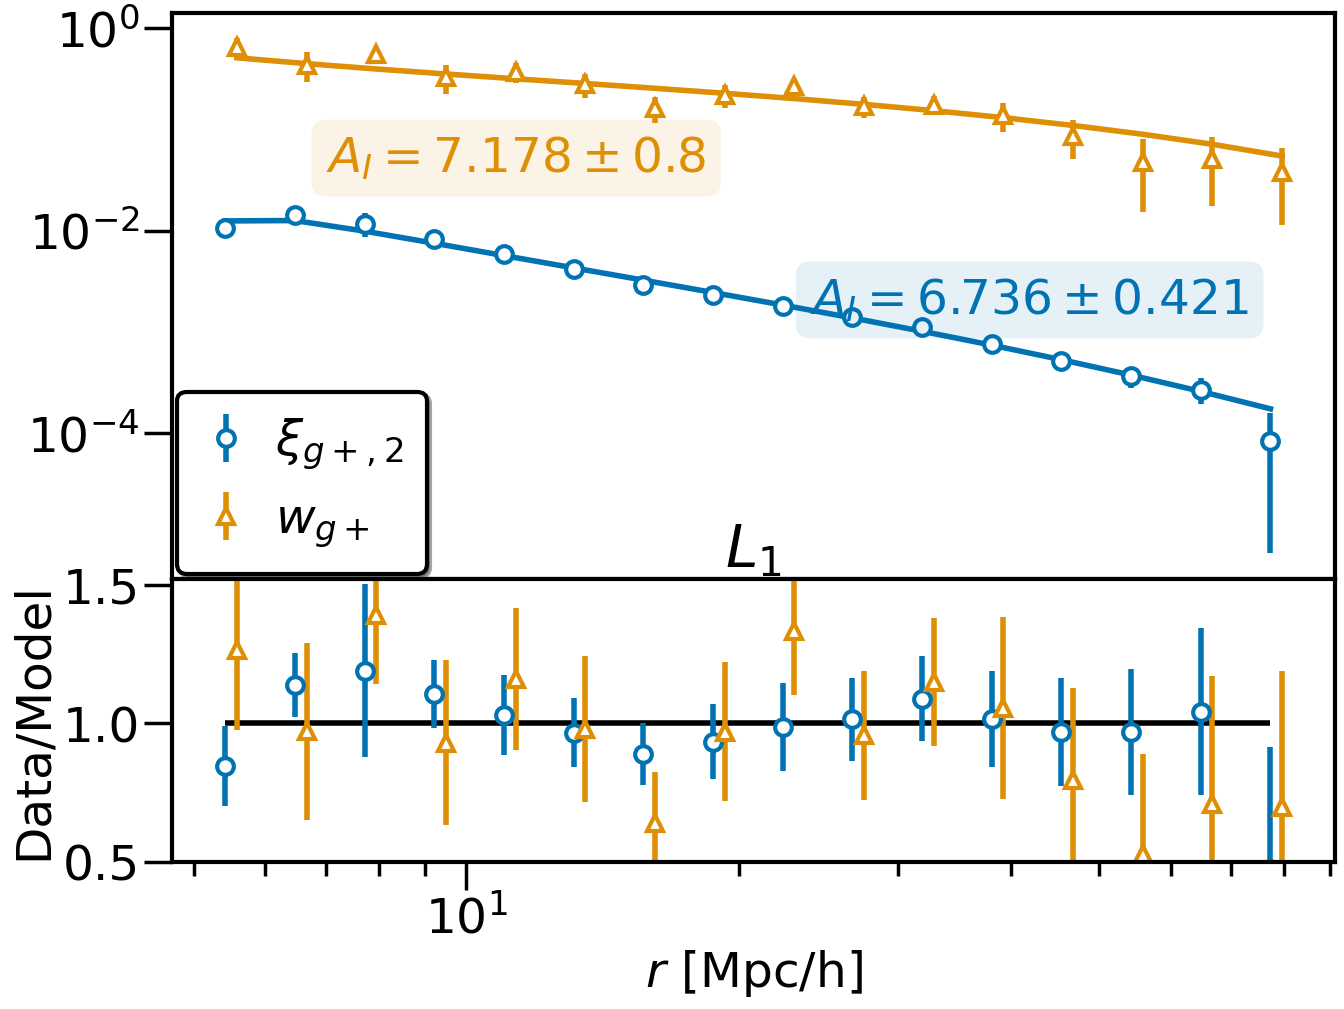

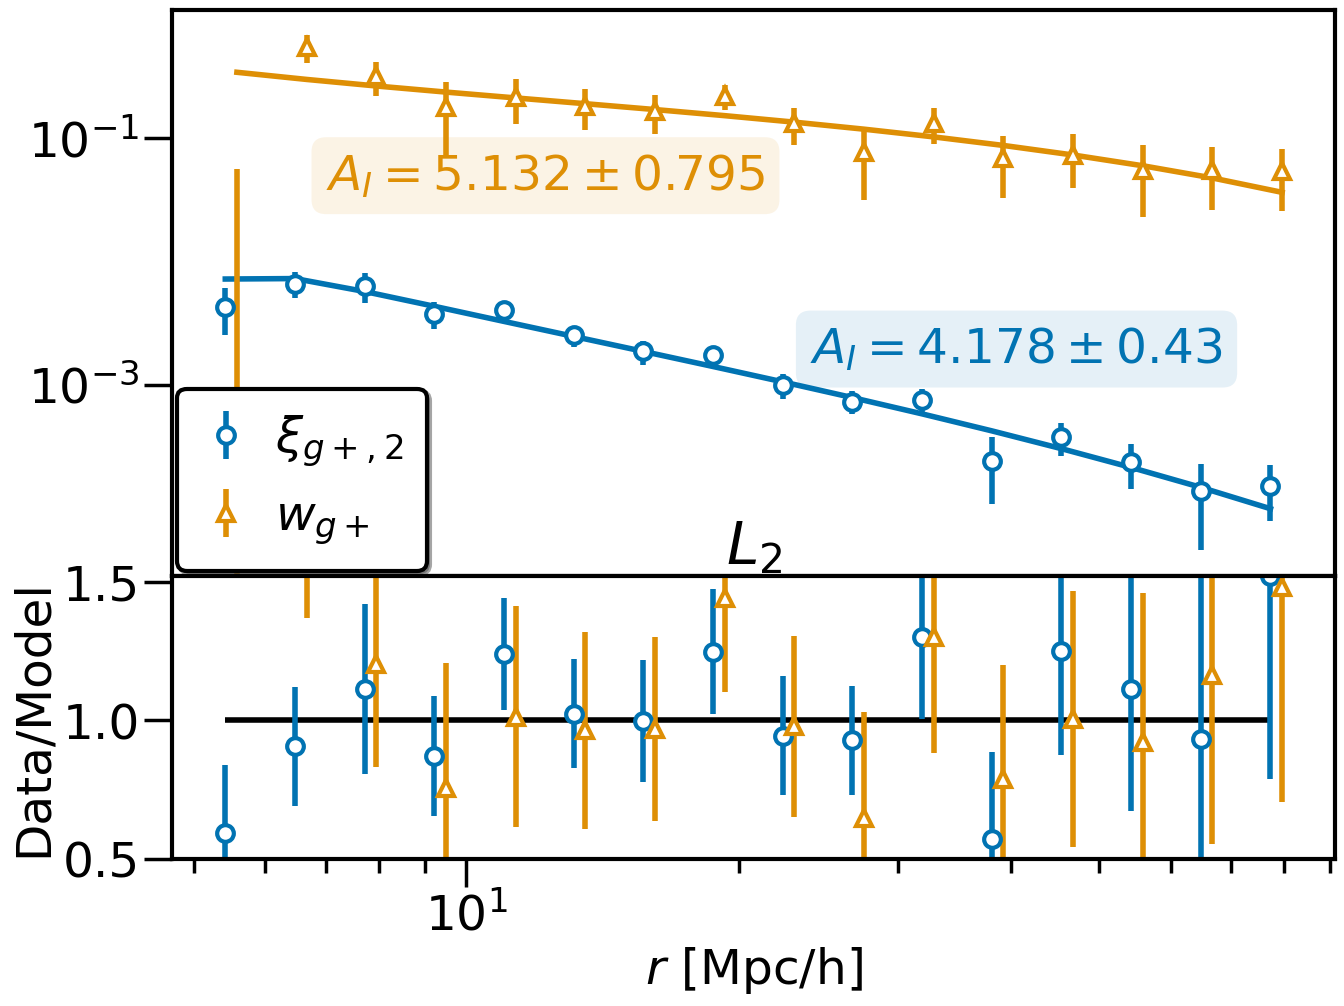

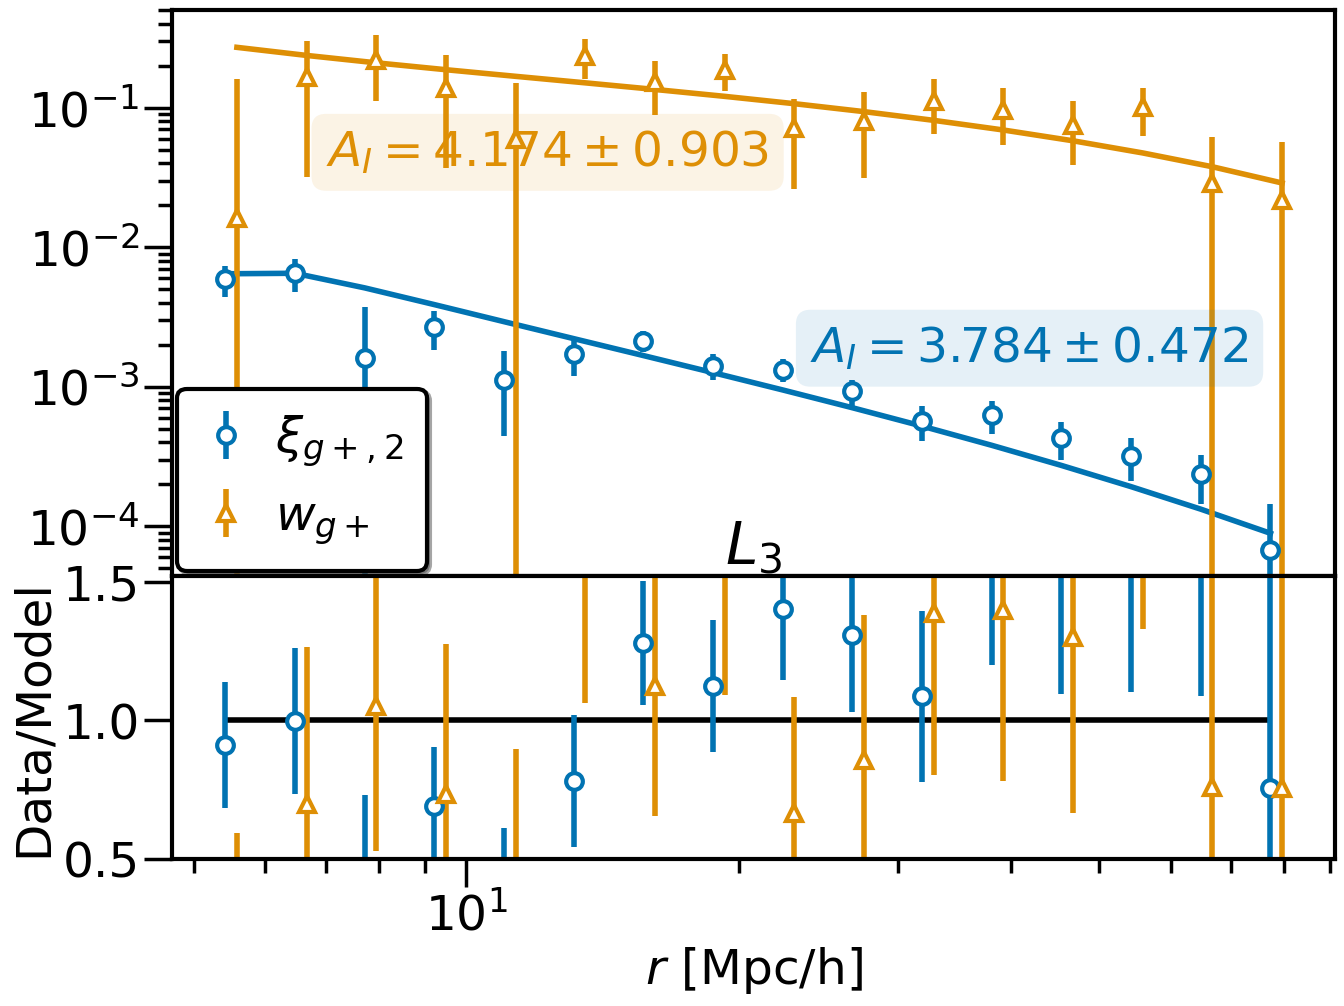

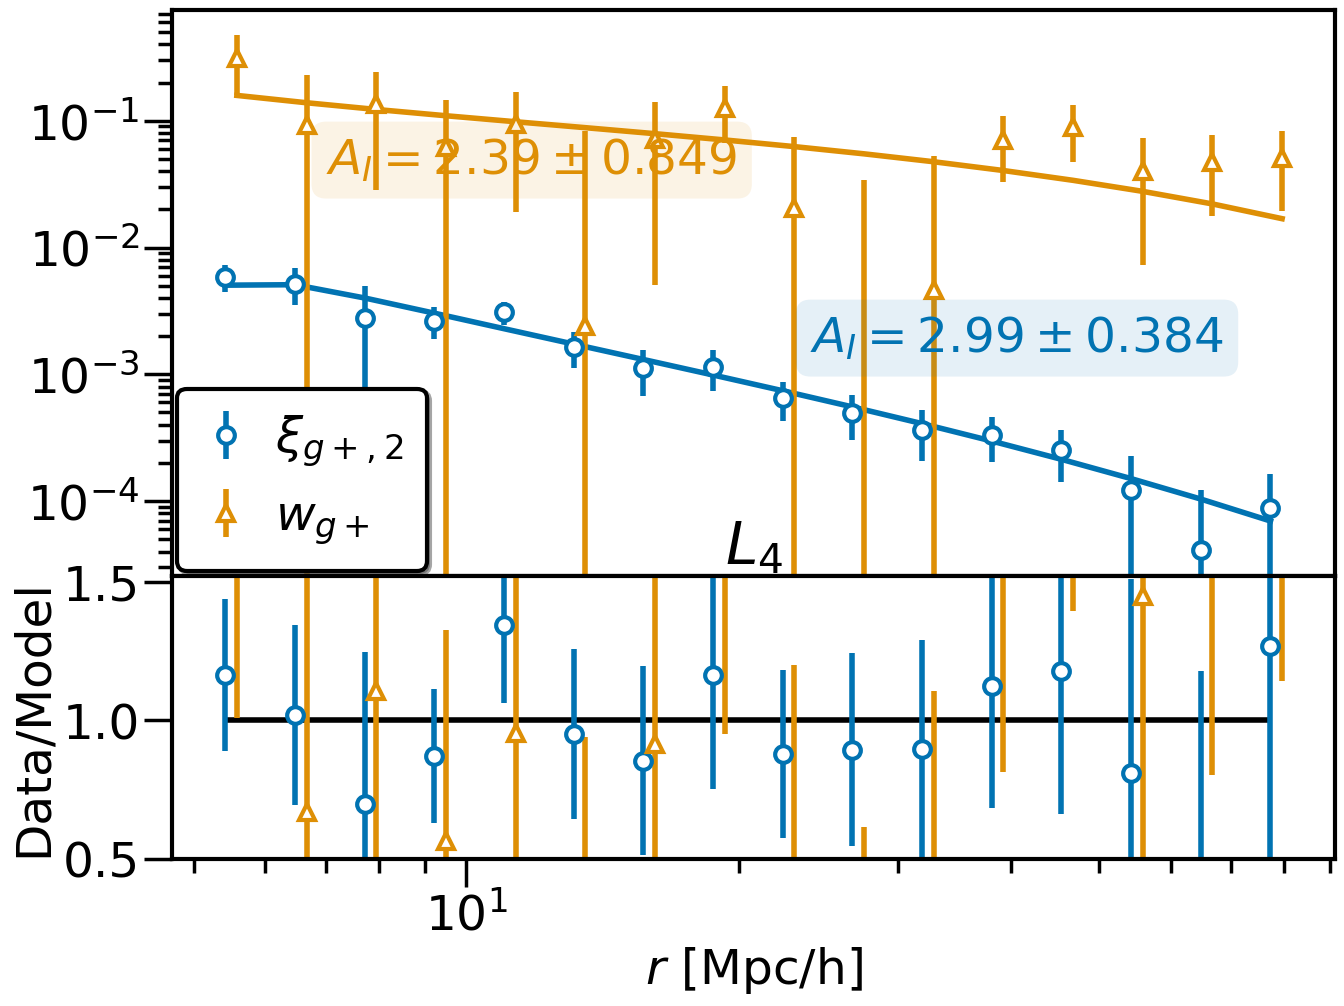

In [151]:
samp='satellite'
for samp in mutipole_fits.keys():
# for _ in range(1):
    fig,axes =subplots(nrows=2, ncols=1, sharex=True, sharey=False,squeeze=True,figsize=(15,11.25),height_ratios=[2,1])
    ai_p=axes[0]
    air_p=axes[1]
    ms=12
    mfc='white'
    mew=3
    i=0
    j=0
    mi=2
    
    ai_p.errorbar(mutipole_fits[samp]['m_gm']['r'],mutipole_fits[samp]['m_gm'][mi]['jk'],
                  mutipole_fits[samp]['m_gm'][mi]['jk_err'],label=r'$\xi_{g+,2}$', #samp_labels[samp],
                 c=colors2[i], fmt=markers[j%len(markers)],ms=ms,mfc=mfc,mew=mew)

    wgp_m=mutipole_fits[samp]['wgp_model']*mutipole_fits[samp]['params']['jk'][0]*mutipole_fits[samp]['params']['jk'][1]

    ai_p.plot(mutipole_fits[samp]['m_gm']['r'],wgp_m,c=colors2[i])

    air_p.errorbar(mutipole_fits[samp]['m_gm']['r'],
             mutipole_fits[samp]['m_gm'][mi]['jk']/wgp_m,mutipole_fits[samp]['m_gm'][mi]['jk_err']/wgp_m,
                  c=colors2[i], fmt=markers[j%len(markers)],ms=ms,mfc=mfc,mew=mew)
    
    n_around=3
    b_label='$A_I='+str(np.around(mutipole_fits[samp]['params']['jk'][1],n_around))
    b_label+='\pm'
    b_label+=str(np.around(mutipole_fits[samp]['params']['jk_err'][1],n_around))+'$'
    t=ai_p.text(x=24,y=0.0015,s=b_label,color=colors2[i])
    t.set_bbox(dict(facecolor=colors2[i], alpha=0.1, edgecolor=colors2[i],boxstyle='Round',lw=0))
    i+=1
    j+=1
    x_f=1.03
    ai_p.errorbar(w_fits[samp]['m_gm']['r']*x_f,w_fits[samp]['m_gm'][mi]['jk'],
                  w_fits[samp]['m_gm'][mi]['jk_err'],label=r'$w_{g+}$',#samp_labels[samp],
                 c=colors2[i], fmt=markers[j%len(markers)],ms=ms,mfc=mfc,mew=mew)
    
    wgp_m=w_fits[samp]['wgp_model']*w_fits[samp]['params']['jk'][0]*w_fits[samp]['params']['jk'][1]

    ai_p.plot(w_fits[samp]['m_gm']['r']*x_f,wgp_m,c=colors2[i])

    air_p.errorbar(w_fits[samp]['m_gm']['r']*x_f,
             w_fits[samp]['m_gm'][mi]['jk']/wgp_m,w_fits[samp]['m_gm'][mi]['jk_err']/np.abs(wgp_m),
                  c=colors2[i], fmt=markers[j%len(markers)],ms=ms,mfc=mfc,mew=mew)
    
    b_label='$A_I='+str(np.around(w_fits[samp]['params']['jk'][1],n_around))
    b_label+='\pm'
    b_label+=str(np.around(w_fits[samp]['params']['jk_err'][1],n_around))+'$'
    t=ai_p.text(x=7,y=.038,s=b_label,color=colors2[i])
    t.set_bbox(dict(facecolor=colors2[i], alpha=0.1, edgecolor=colors2[i],boxstyle='Round',lw=0))
    
    air_p.hlines(1,mutipole_fits[samp]['m_gm']['r'].min(),mutipole_fits[samp]['m_gm']['r'].max(),color='k',zorder=-10)
    ai_p.loglog()
    ai_p.legend(loc='lower left')
    air_p.set_ylim(0.5,1.52)
    air_p.set_xlabel(r'$r$ [Mpc/h]')
    air_p.set_title(samp_labels[samp])
#     ai_p.set_ylabel(r'$\xi_{gg,0}$')
    air_p.set_ylabel(r'Data/Model')
    fname='wgp_xigp_quadrupole_fit_'+samp+'.'
    savefig(fig_home+fname+fig_format,format=fig_format,bbox_inches='tight')


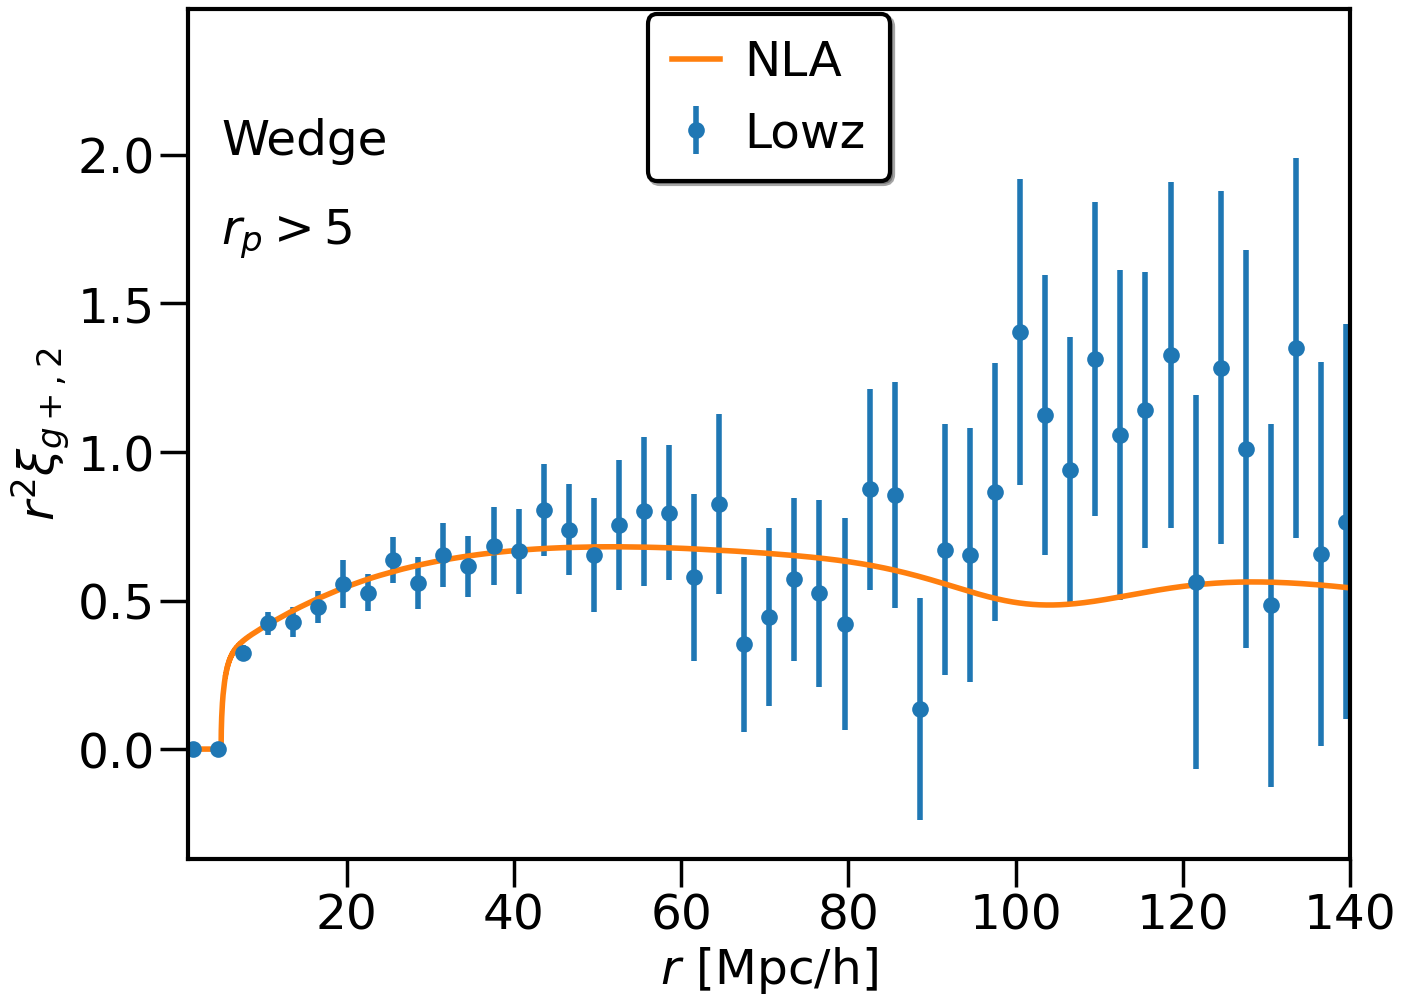

In [92]:
f_pow=2
errorbar(m_jk5_lin['r'],(m_jk5_lin['r']**f_pow)*m_jk5_lin[2]['jk'],(m_jk5_lin['r']**f_pow)*m_jk5_lin[2]['jk_err'],
         label='Lowz',fmt='o')
plot(rq[2],(rq[2]**f_pow)*xi_wq5[2]*wgp_f*-1,label='NLA')
legend(loc='upper center')
# loglog()
# yscale('log')
xlim(1,140)
# ylim(.00001,.1)
xlabel(r'$r$ [Mpc/h]')
ylabel(r'$r^2\xi_{g+,2}$')
text(x=5,y=1.7,s='$r_p>5$')
text(x=5,y=2.,s='Wedge')
# vlines(5,0.001,0.1,color='k',ls=':')

fname='xigp_bao_lowz.'
savefig(fig_home+fname+fig_format,format=fig_format,bbox_inches='tight')

In [93]:
m_jk5_lin.keys()

dict_keys([2, 4, 'r'])

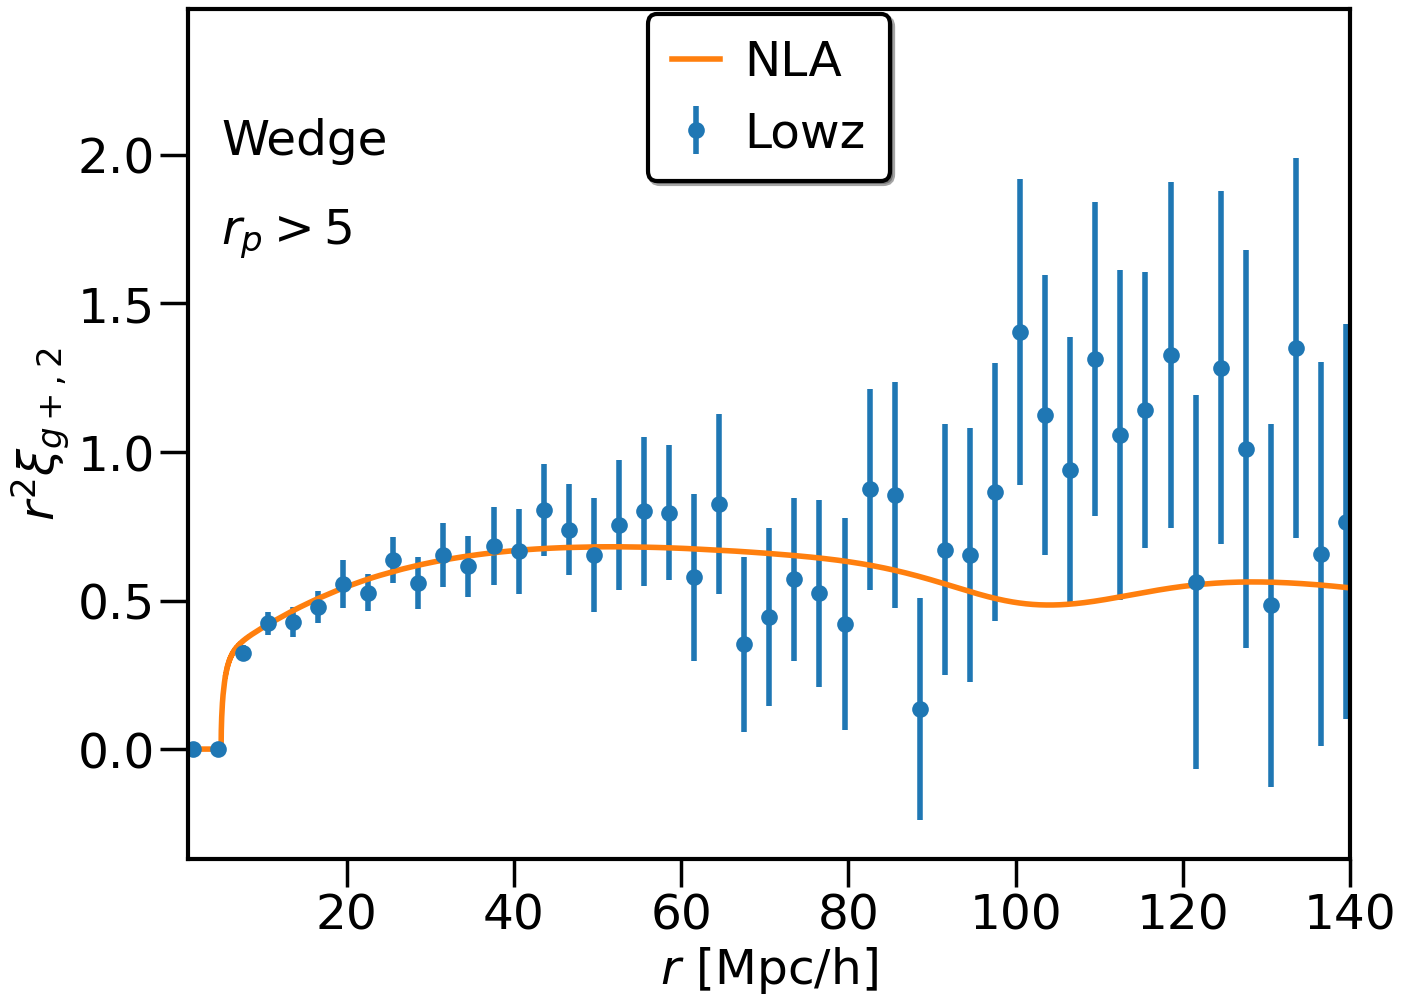

In [94]:
f_pow=2
errorbar(m_jk5_lin['r'],(m_jk5_lin['r']**f_pow)*m_jk5_lin[2]['jk'],(m_jk5_lin['r']**f_pow)*m_jk5_lin[2]['jk_err'],
         label='Lowz',fmt='o')
plot(rq[2],(rq[2]**f_pow)*xi_wq5[2]*wgp_f*-1,label='NLA')
legend(loc='upper center')
# loglog()
# yscale('log')
xlim(1,140)
# ylim(.00001,.1)
xlabel(r'$r$ [Mpc/h]')
ylabel(r'$r^2\xi_{g+,2}$')
text(x=5,y=1.7,s='$r_p>5$')
text(x=5,y=2.,s='Wedge')
# vlines(5,0.001,0.1,color='k',ls=':')

fname='xigp_bao_lowz.'
savefig(fig_home+fname+fig_format,format=fig_format,bbox_inches='tight')

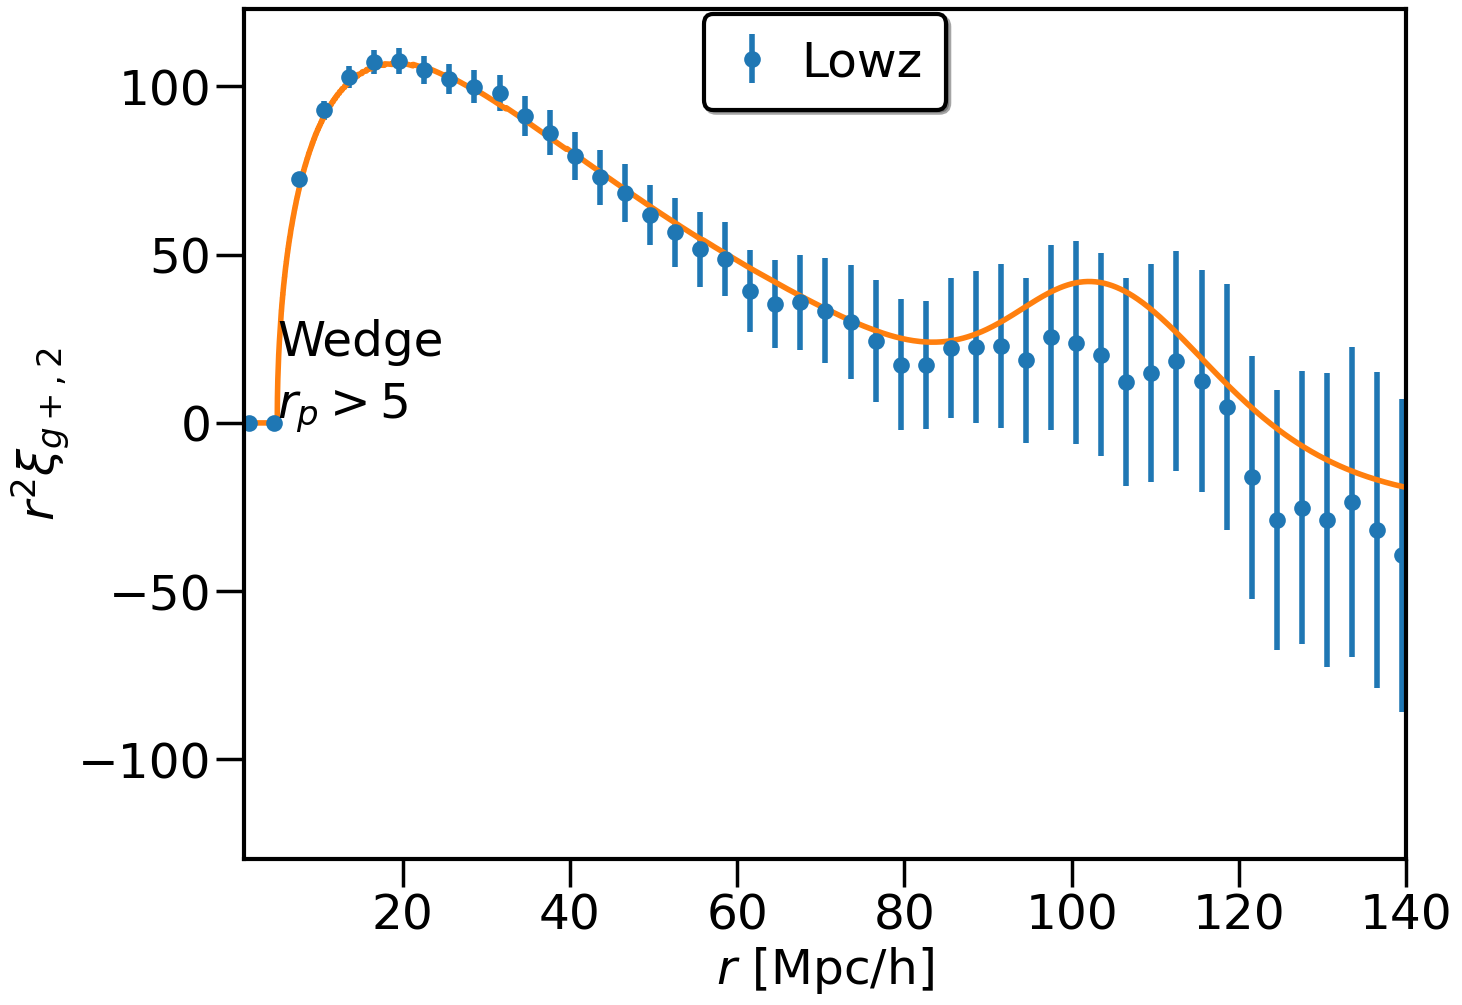

In [95]:
m_jk5_lin_gg
f_pow=2
errorbar(m_jk5_lin_gg['r'],(m_jk5_lin_gg['r']**f_pow)*m_jk5_lin_gg[0]['jk'],
         (m_jk5_lin_gg['r']**f_pow)*m_jk5_lin_gg[0]['jk_err'],
         label='Lowz',fmt='o')
plot(rq[2],(rq[2]**f_pow)*xi_wq5_gg[0]*wgg_f)
legend(loc='upper center')
# loglog()
# yscale('log')
xlim(1,140)
# ylim(.00001,.1)
xlabel(r'$r$ [Mpc/h]')
ylabel(r'$r^2\xi_{g+,2}$')
text(x=5,y=1.7,s='$r_p>5$')
text(x=5,y=20.,s='Wedge')
# vlines(5,0.001,0.1,color='k',ls=':')

fname='xigg_bao_lowz.'
savefig(fig_home+fname+fig_format,format=fig_format,bbox_inches='tight')

In [96]:
mutipole_fits[samp]['wgg_model']

array([0.32056803, 0.40334574, 0.3660146 , 0.30254827, 0.2363814 ,
       0.17918764, 0.13132542, 0.09368135, 0.0651584 , 0.04392756,
       0.02856522, 0.01788194, 0.01066653, 0.00595086, 0.00304855,
       0.00137915])

In [97]:
m_jk5_gg[2].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 'jk', 'jk_err', 'cov'])

In [98]:
rgg2,wgg_model2=multipole_wedge_model(rp_cut=5,spin=0)

//hildafs/projects/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.9/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [99]:
rgg2

{0: array([3.32808201e-02, 3.33333333e-02, 3.33859294e-02, ...,
        9.95281251e+03, 9.96851688e+03, 9.98424603e+03]),
 2: array([3.32808201e-02, 3.33333333e-02, 3.33859294e-02, ...,
        9.95281251e+03, 9.96851688e+03, 9.98424603e+03]),
 4: array([3.32808201e-02, 3.33333333e-02, 3.33859294e-02, ...,
        9.95281251e+03, 9.96851688e+03, 9.98424603e+03])}

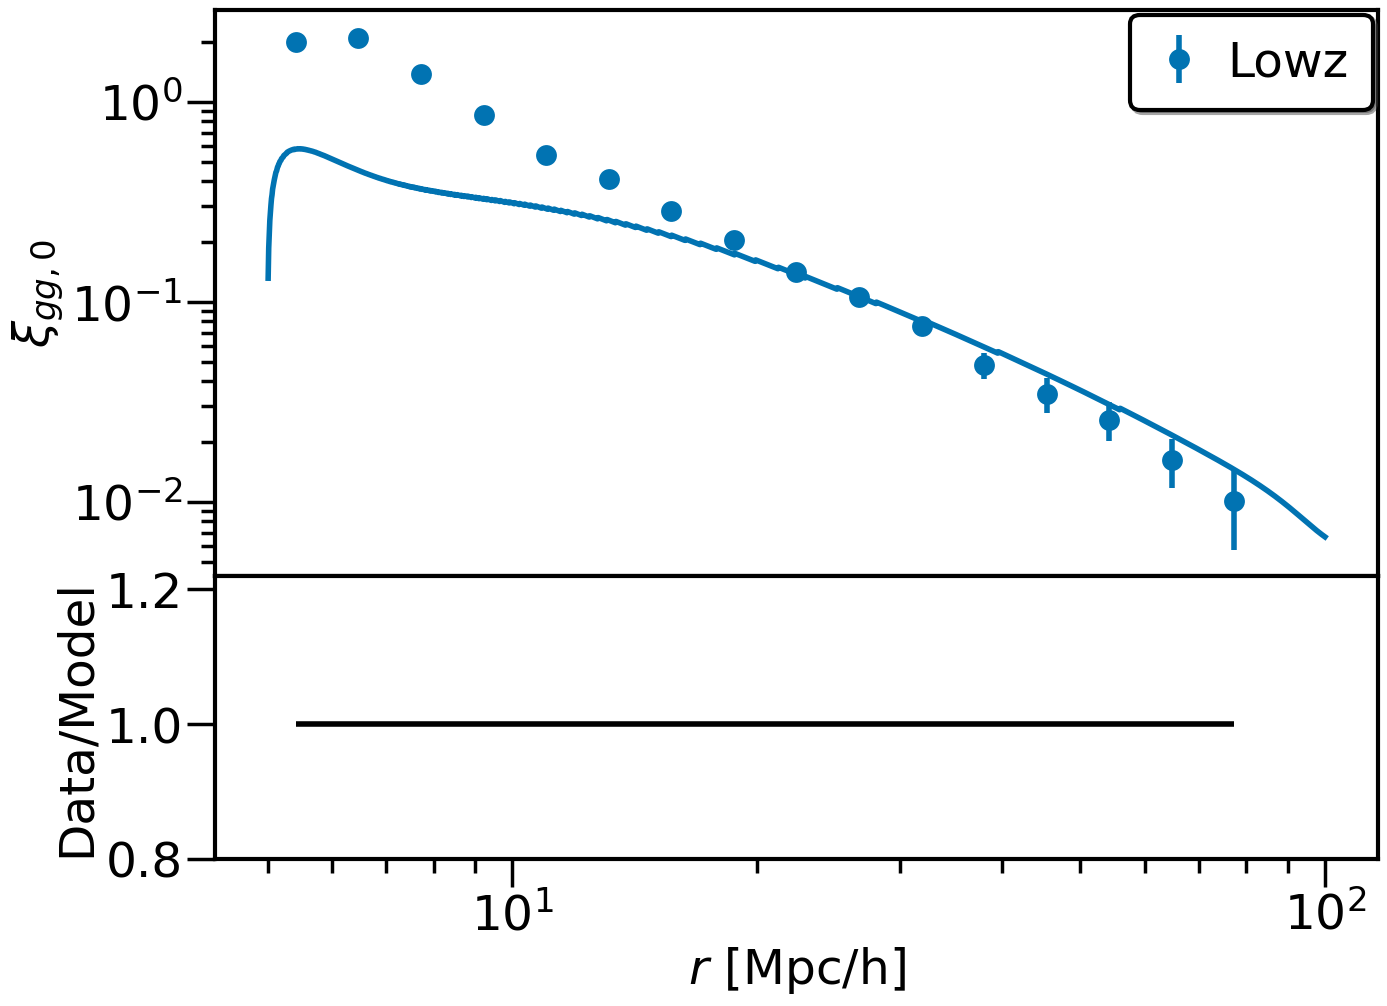

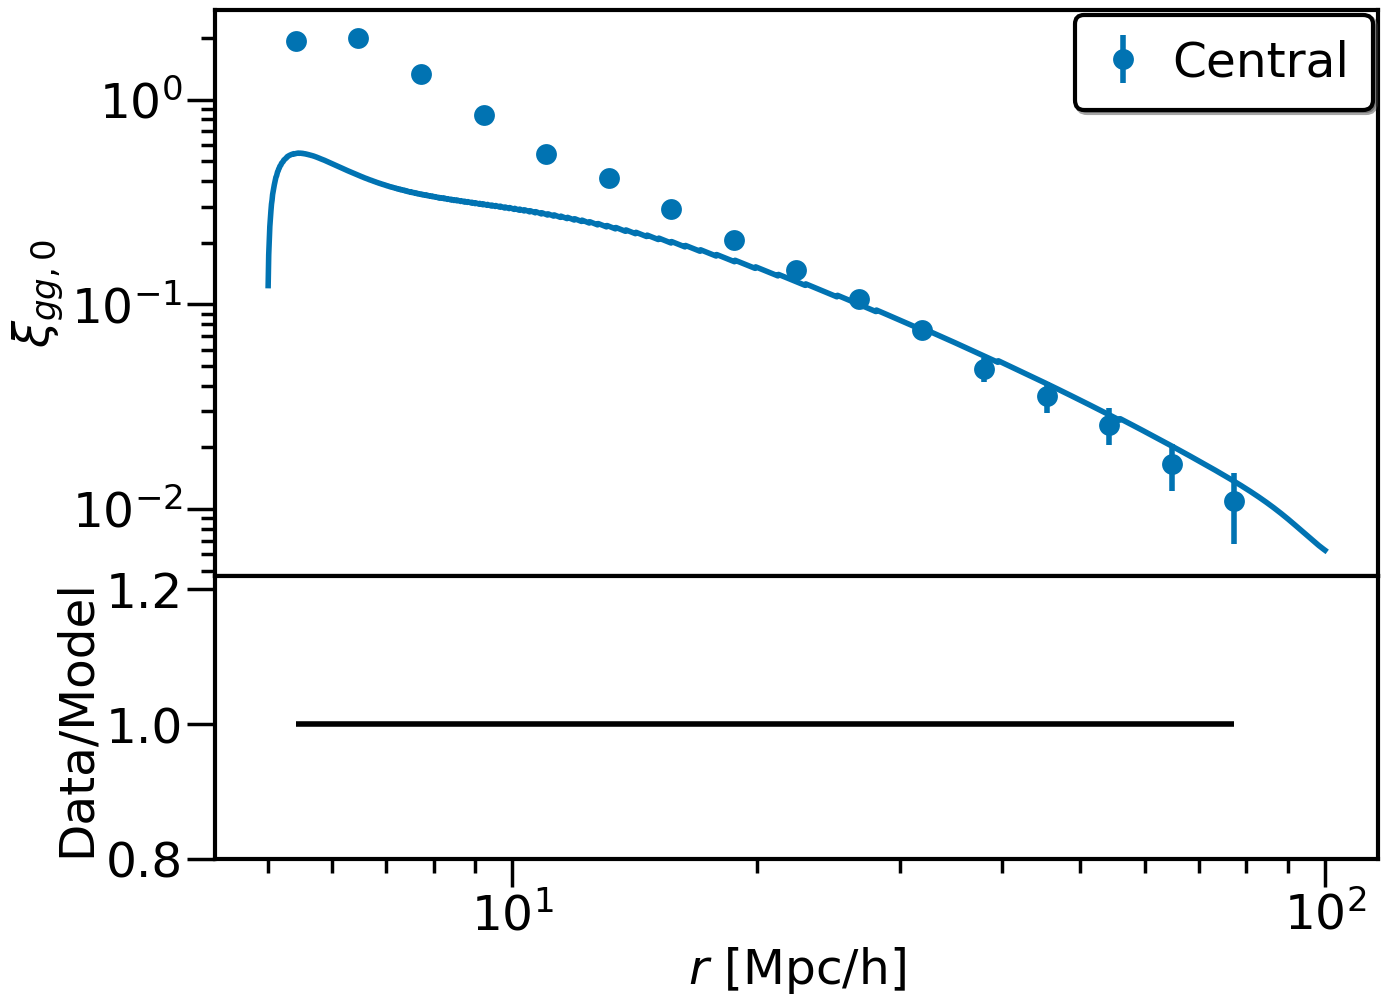

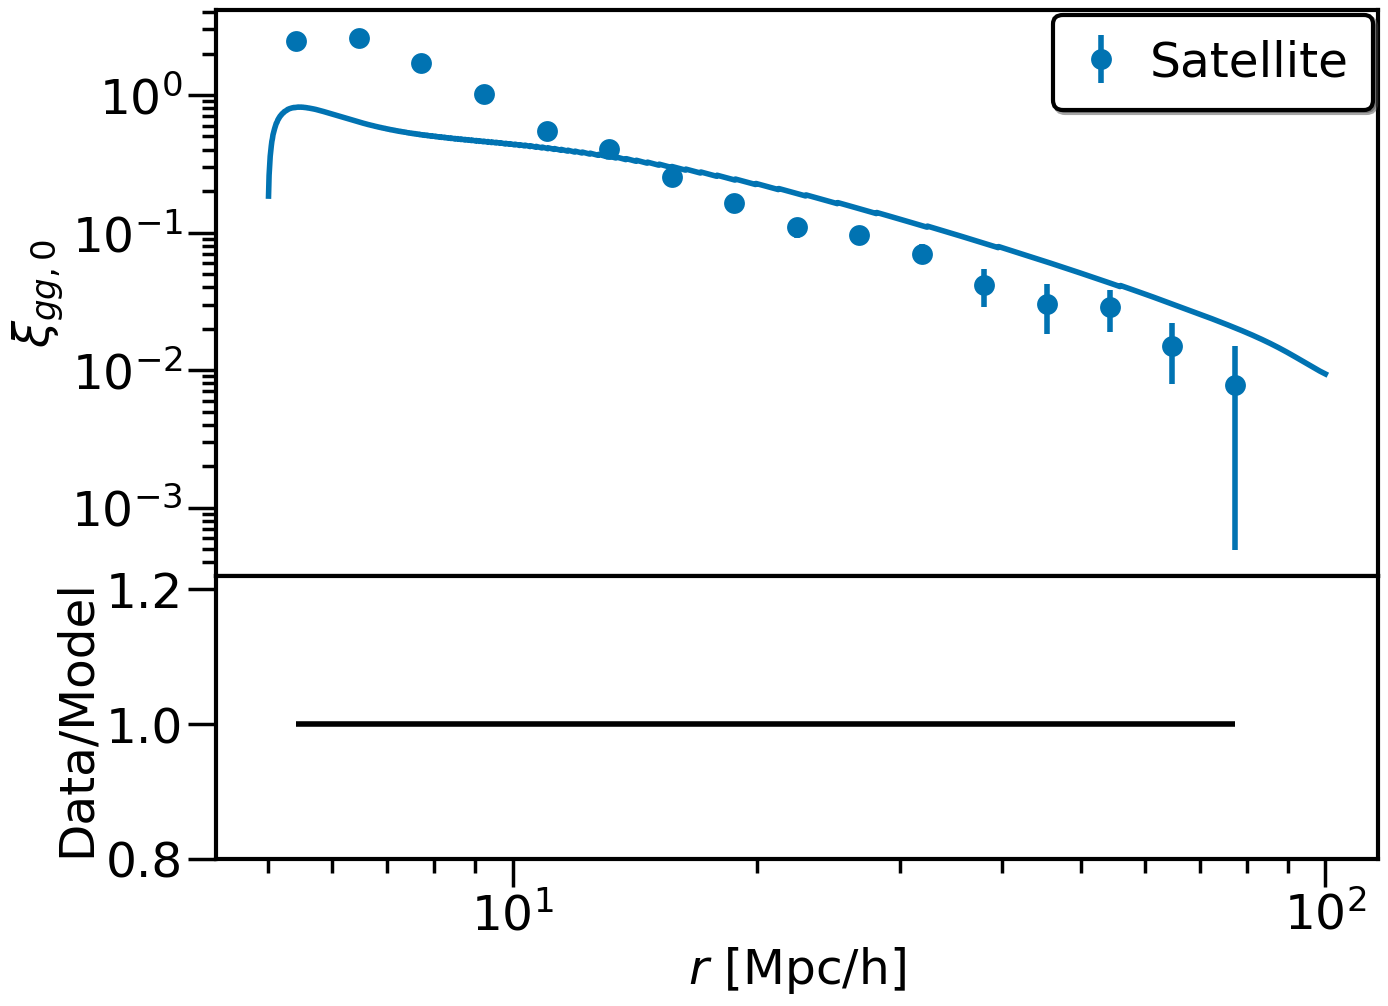

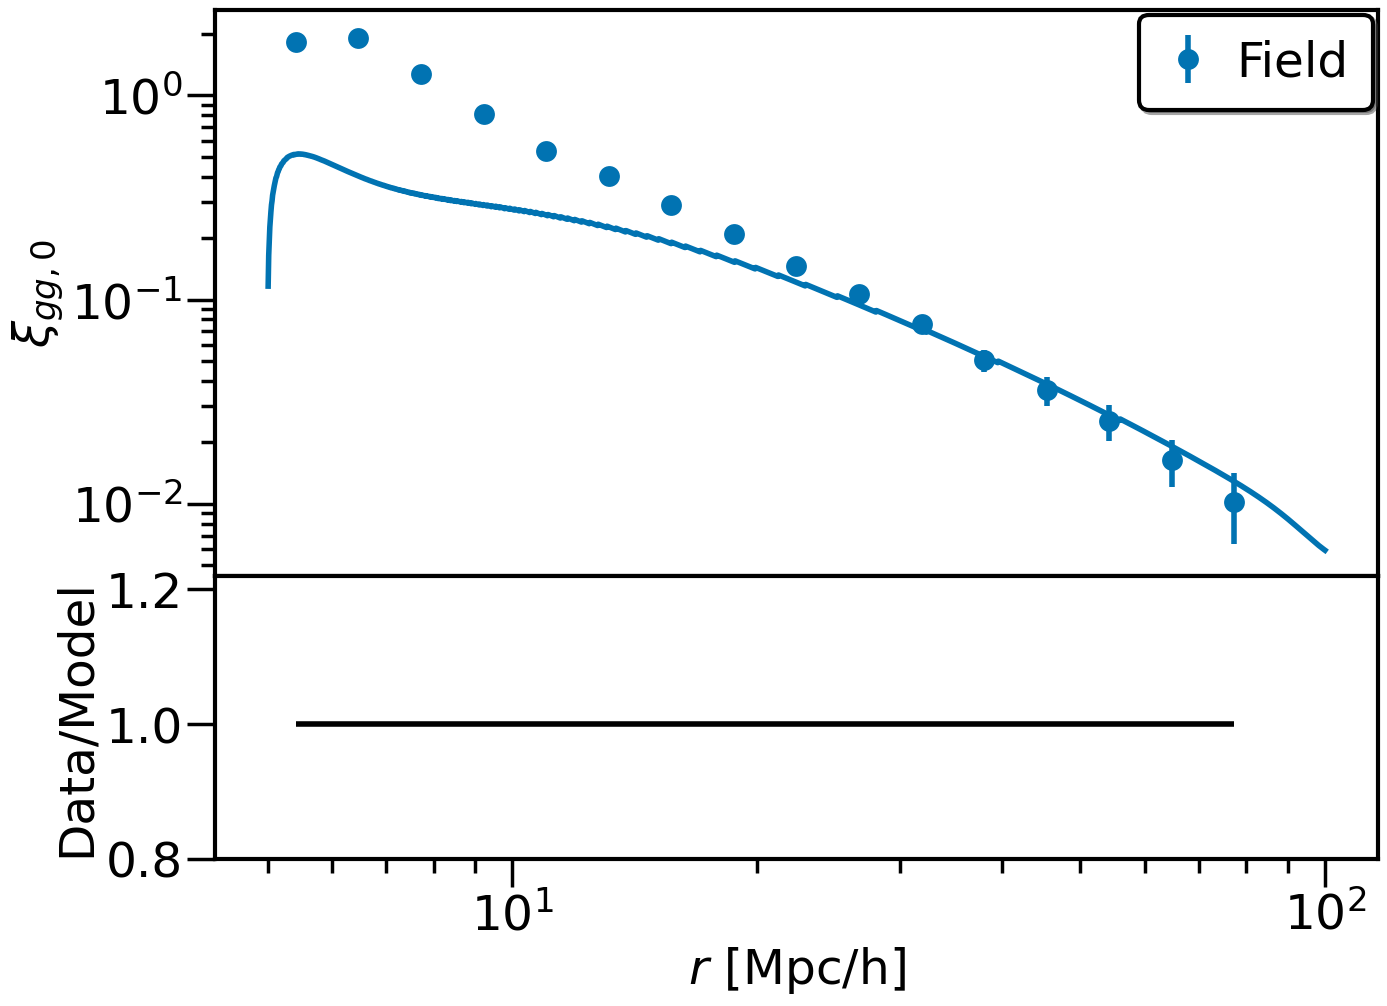

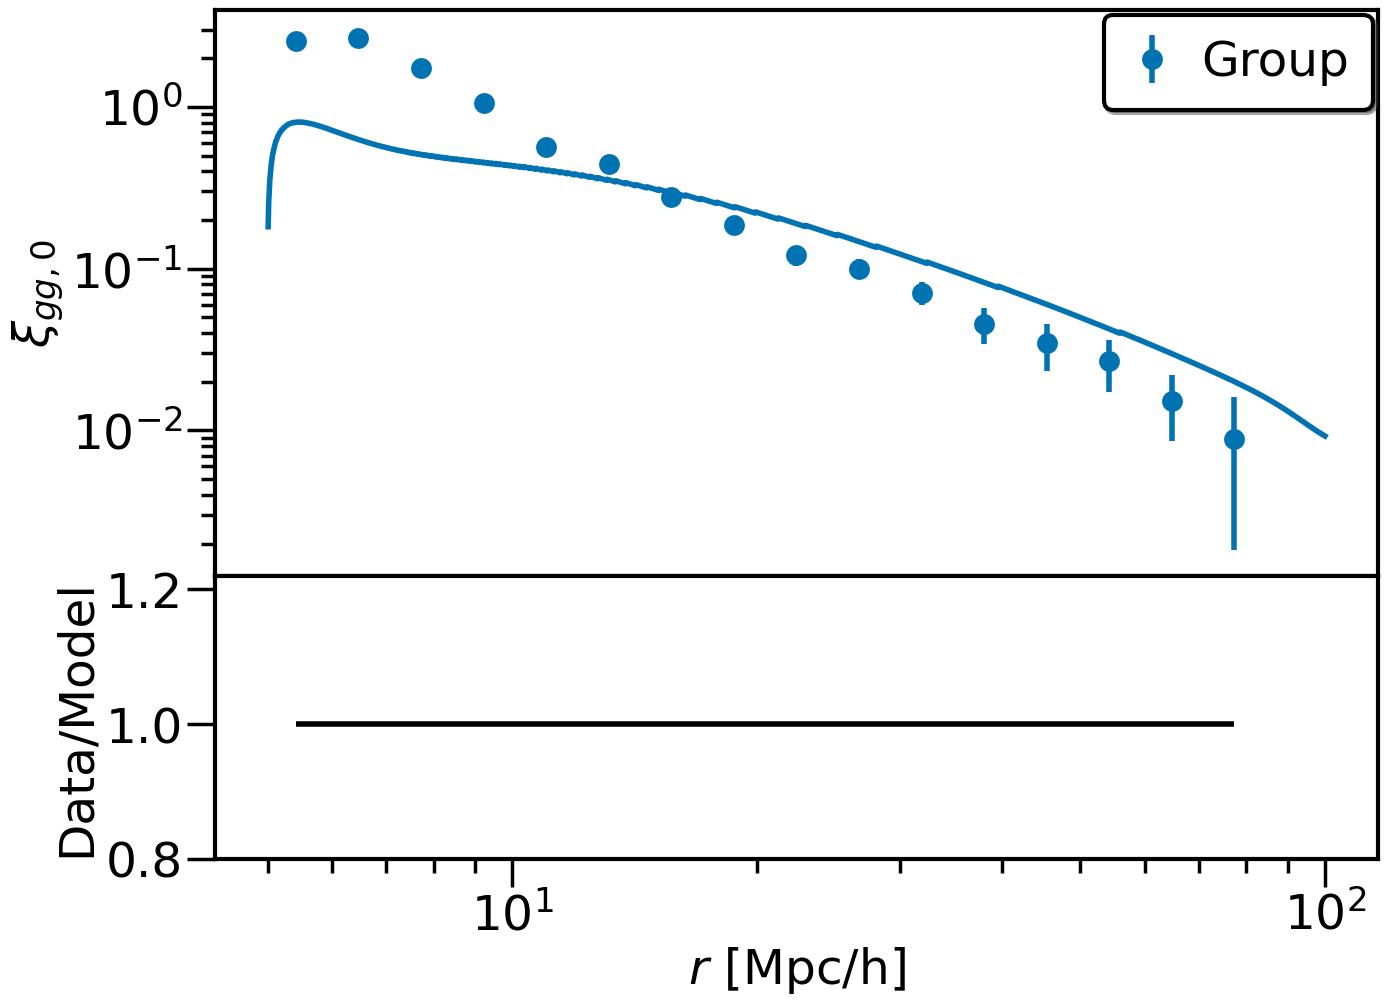

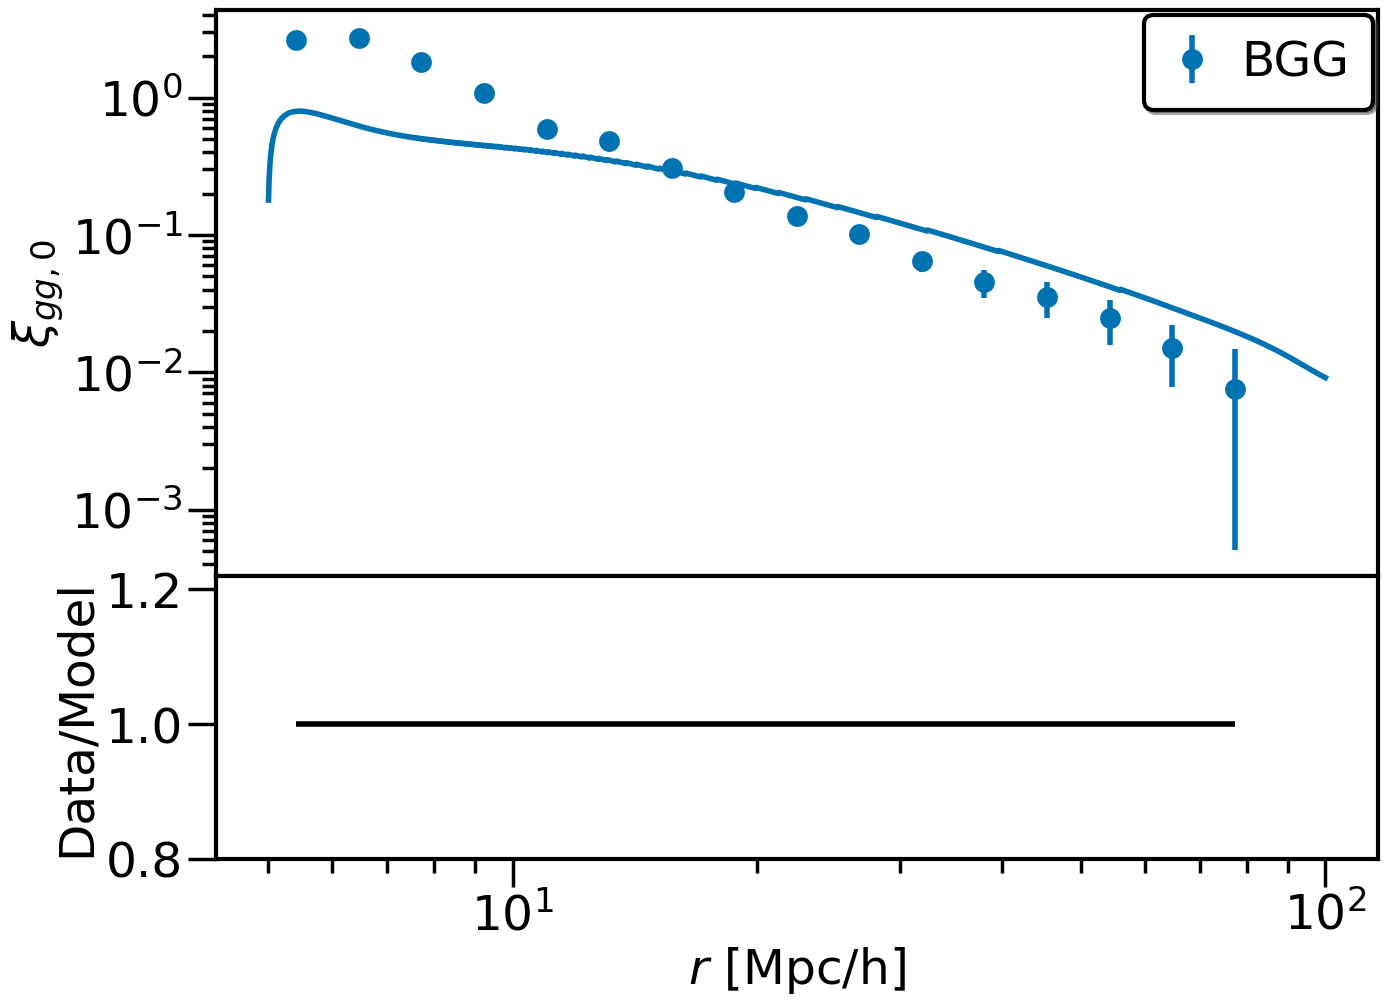

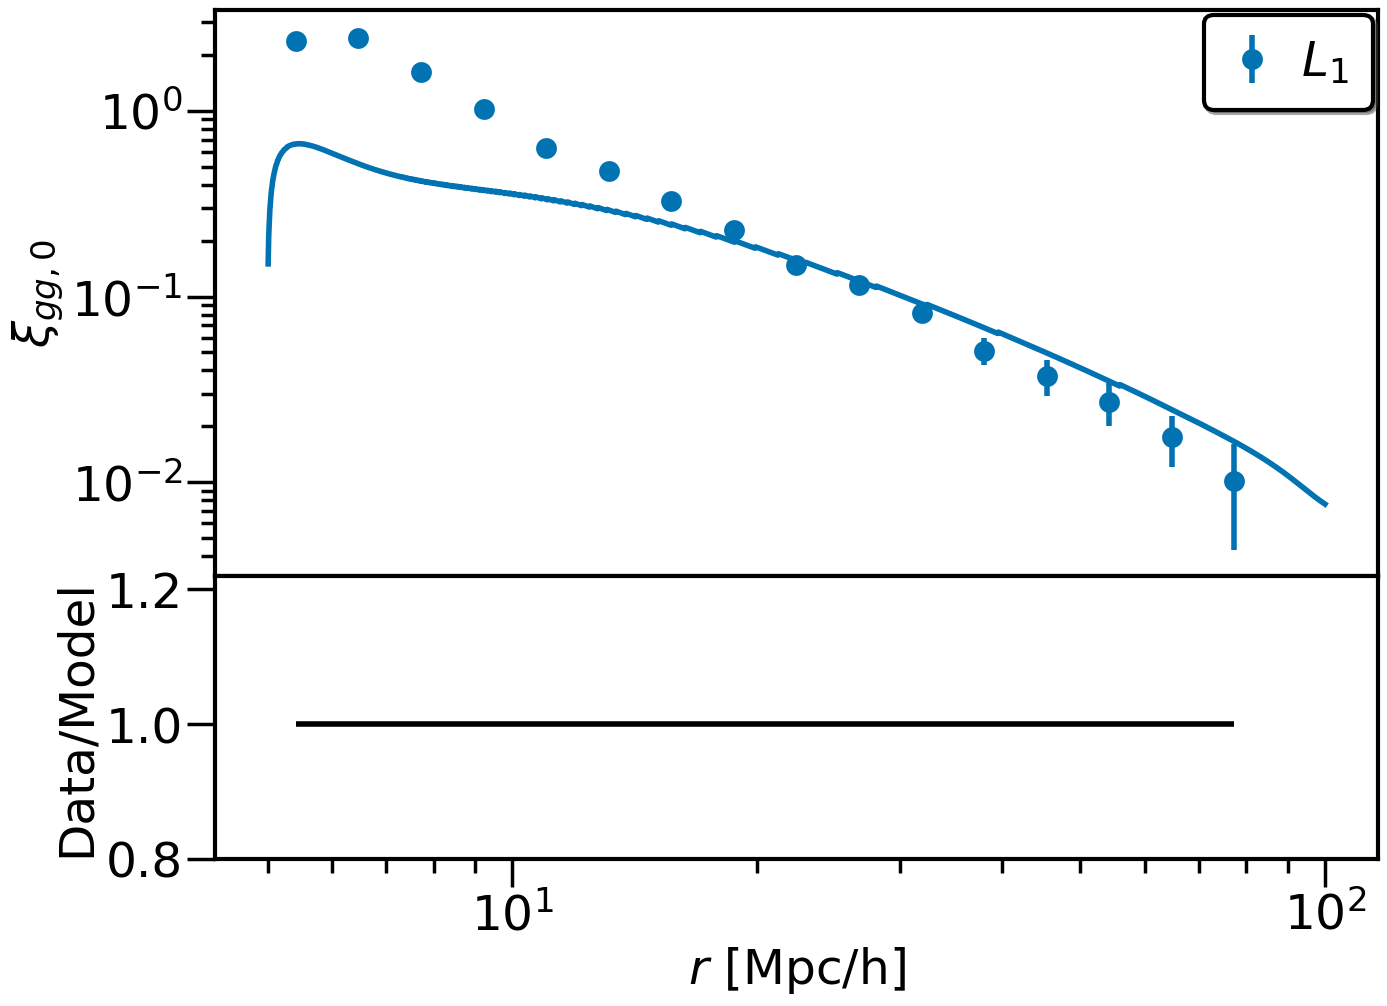

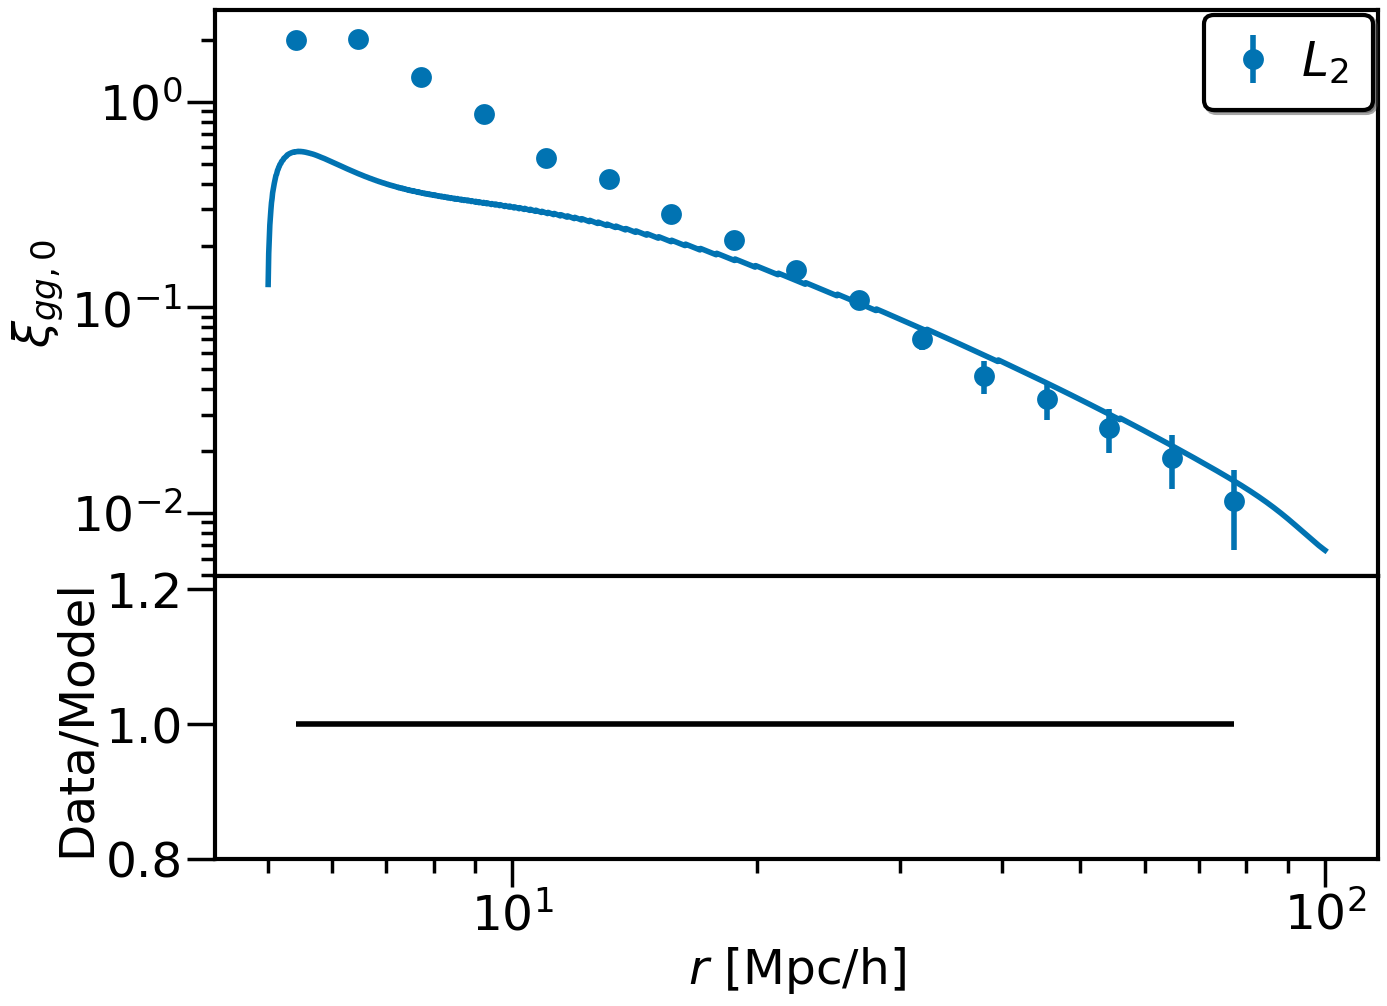

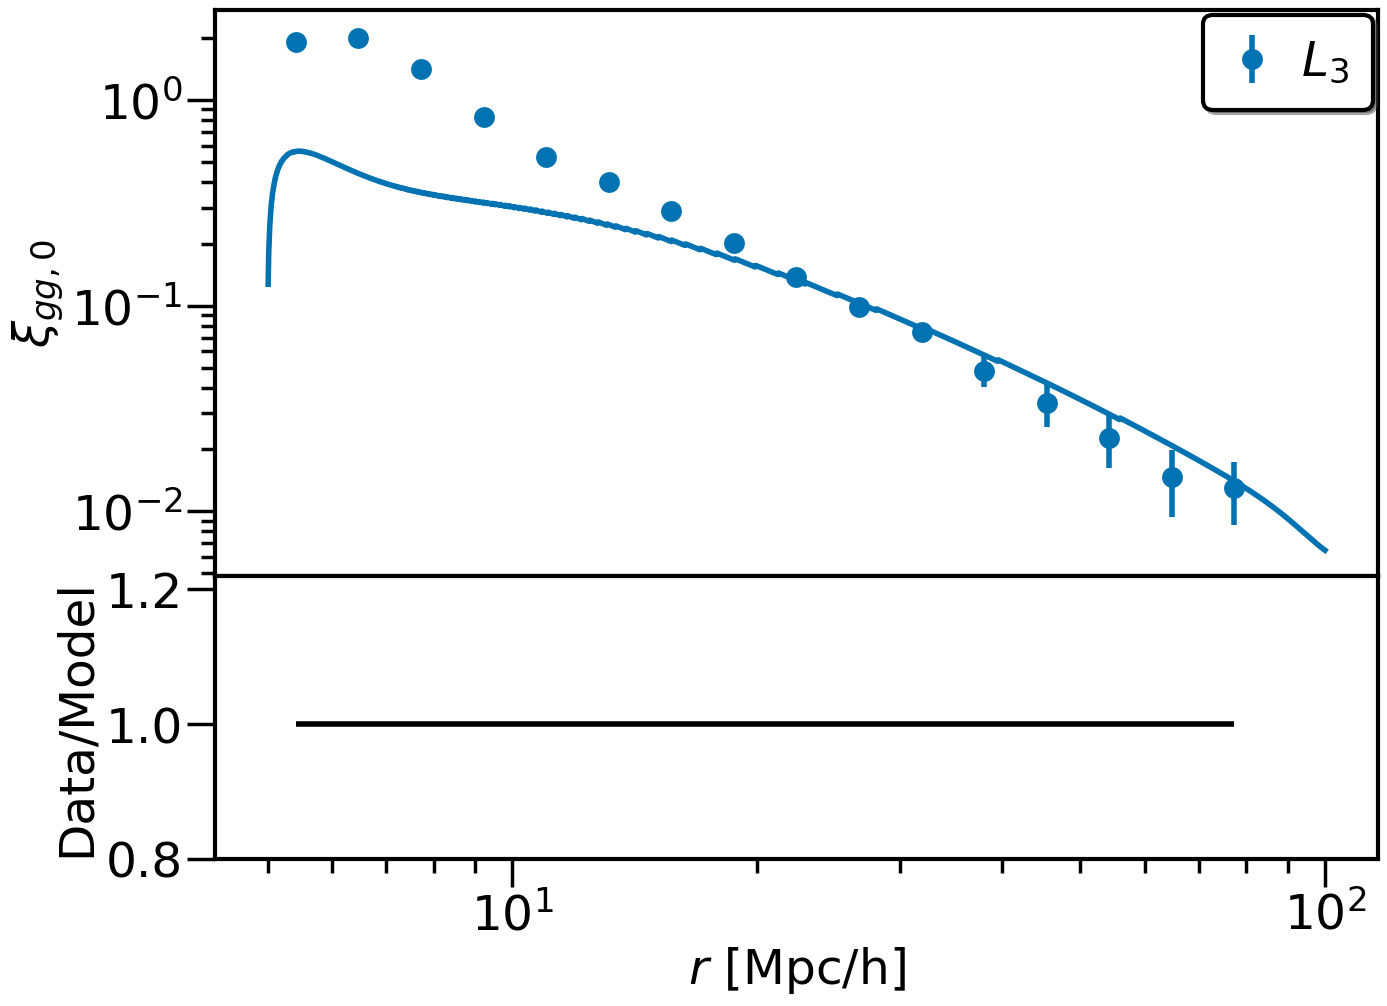

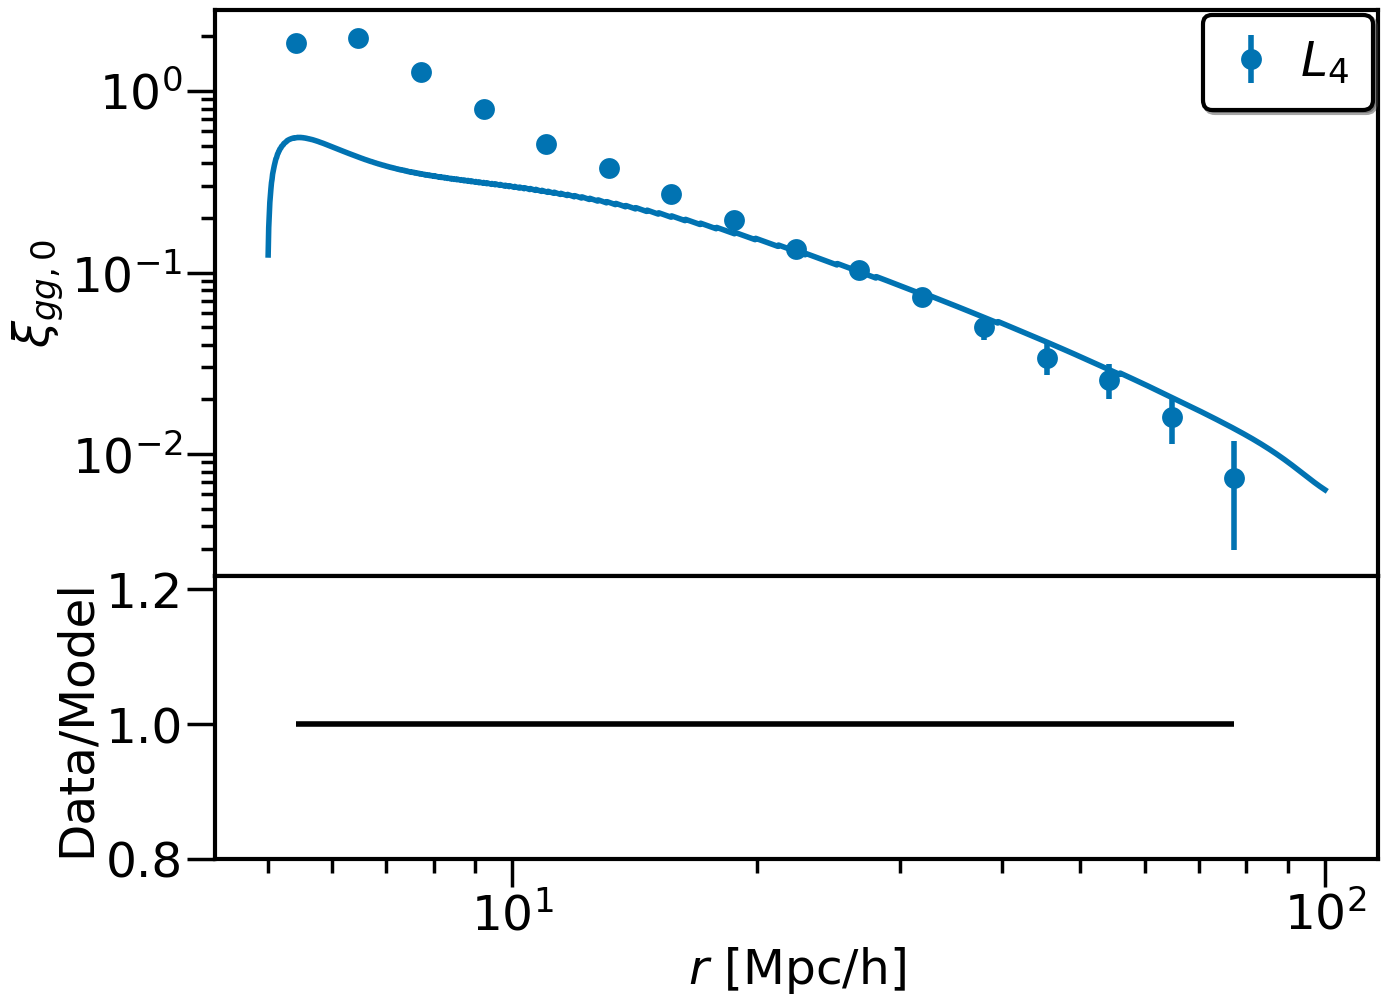

In [100]:
# samp='satellite'
for samp in mutipole_fits.keys():
    fig,axes =subplots(nrows=2, ncols=1, sharex=True, sharey=False,squeeze=True,figsize=(15,11.25),height_ratios=[2,1])
    ai_p=axes[0]
    air_p=axes[1]
    ms=15
    i=0
    j=0
    ai_p.errorbar(mutipole_fits[samp]['m_gm']['r'],mutipole_fits[samp]['m_gg'][2]['jk']*-1,
                  mutipole_fits[samp]['m_gg'][2]['jk_err'],label=samp_labels[samp],
                 c=colors2[i], fmt=markers[j%len(markers)],ms=ms)

    wgg_m=wgg_model2[2]*mutipole_fits[samp]['params']['jk'][0]*mutipole_fits[samp]['params']['jk'][0]
    
    x=rgg2[2]>5
    x*=rgg2[2]<100
    ai_p.plot(rgg2[2][x],wgg_m[x]*-1,c=colors2[i])

#     air_p.errorbar(mutipole_fits[samp]['m_gg']['r'],
#              mutipole_fits[samp]['m_gg'][2]['jk']*-1/wgg_m,mutipole_fits[samp]['m_gg'][2]['jk_err']/wgg_m,
#                   c=colors2[i], fmt=markers[j%len(markers)],ms=ms)
    air_p.hlines(1,mutipole_fits[samp]['m_gg']['r'].min(),mutipole_fits[samp]['m_gg']['r'].max(),color='k',zorder=-10)
    ai_p.loglog()
    ai_p.legend()
    air_p.set_ylim(0.8,1.22)
    air_p.set_xlabel(r'$r$ [Mpc/h]')
    ai_p.set_ylabel(r'$\xi_{gg,0}$')
    air_p.set_ylabel(r'Data/Model')
    fname='xigg_quadrupole_fit_'+samp+'.'
#     savefig(fig_home+fname+fig_format,format=fig_format,bbox_inches='tight')
